# **Driver Churn Prediction**


**Dataset**

| Feature              | Description                                                                                             |
|----------------------|---------------------------------------------------------------------------------------------------------|
| MMMM-YY              | Reporting Date (Monthly)                                                                                |
| Driver_ID            | Unique ID for drivers                                                                                   |
| Age                  | Age of the driver                                                                                       |
| Gender               | Gender of the driver â€“ Male : 0, Female: 1                                                              |
| City                 | City Code of the driver                                                                                 |
| Education_Level      | Education level â€“ 0 for 10+, 1 for 12+, 2 for graduate                                                  |
| Income               | Monthly average Income of the driver                                                                    |
| Date Of Joining      | Joining date for the driver                                                                             |
| LastWorkingDate      | Last date of working for the driver                                                                     |
| Joining Designation  | Designation of the driver at the time of joining                                                        |
| Grade                | Grade of the driver at the time of reporting                                                            |
| Total Business Value | The total business value acquired by the driver in a month (negative business indicates cancellation/refund or car EMI adjustments) |
| Quarterly Rating     | Quarterly rating of the driver: 1, 2, 3, 4, 5 (higher is better)                                        |



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('Driver_Info.csv')
df.head()

Unnamed: 0    MMM-YY  Driver_ID   Age  Gender City  Education_Level  \
0           0  01/01/19          1  28.0     0.0  C23                2   
1           1  02/01/19          1  28.0     0.0  C23                2   
2           2  03/01/19          1  28.0     0.0  C23                2   
3           3  11/01/20          2  31.0     0.0   C7                2   
4           4  12/01/20          2  31.0     0.0   C7                2   

   Income Dateofjoining LastWorkingDate  Joining Designation  Grade  \
0   57387      24/12/18             NaN                    1      1   
1   57387      24/12/18             NaN                    1      1   
2   57387      24/12/18        03/11/19                    1      1   
3   67016      11/06/20             NaN                    2      2   
4   67016      11/06/20             NaN                    2      2   

   Total Business Value  Quarterly Rating  
0               2381060                 2  
1               -665480                 2  
2                     0                 2  
3                     0                 1  
4                     0                 1

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            19104 non-null  int64  
 1   MMM-YY                19104 non-null  object 
 2   Driver_ID             19104 non-null  int64  
 3   Age                   19043 non-null  float64
 4   Gender                19052 non-null  float64
 5   City                  19104 non-null  object 
 6   Education_Level       19104 non-null  int64  
 7   Income                19104 non-null  int64  
 8   Dateofjoining         19104 non-null  object 
 9   LastWorkingDate       1616 non-null   object 
 10  Joining Designation   19104 non-null  int64  
 11  Grade                 19104 non-null  int64  
 12  Total Business Value  19104 non-null  int64  
 13  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(8), object(4)
memory usage: 2.0+ MB


In [4]:
df = df.iloc[:,1:]

In [5]:
df.isnull().sum().to_frame(name='null_count')

null_count
MMM-YY                         0
Driver_ID                      0
Age                           61
Gender                        52
City                           0
Education_Level                0
Income                         0
Dateofjoining                  0
LastWorkingDate            17488
Joining Designation            0
Grade                          0
Total Business Value           0
Quarterly Rating               0

### **Observations**

- We can see that there are lot of missing values in the dataset for LastWorkingDate
- There are some missing values for Age and Gender

#### Data Cleaning and Feature Engineering

In [6]:
df['reporting_month_year'] = pd.to_datetime(df['MMM-YY'], format='%m/%d/%y')
df.drop(columns=['MMM-YY'], inplace=True)

df['Dateofjoining'] = pd.to_datetime(df['Dateofjoining'], format='%d/%m/%y', errors='coerce')
df['LastWorkingDate'] = pd.to_datetime(df['LastWorkingDate'], format='%d/%m/%y', errors='coerce')

df['Quarter'] = df['reporting_month_year'].dt.quarter
df['ReportingYear'] = df['reporting_month_year'].dt.year
df['ReportingYear_Quarter'] = df['ReportingYear'].astype(str) + '-' + df['Quarter'].astype(str)

In [7]:
df = df.drop_duplicates()

In [8]:
df[df["Gender"].isnull()]

Driver_ID   Age  Gender City  Education_Level  Income Dateofjoining  \
240           43  27.0     NaN  C15                0   12906    2018-07-13   
258           49  21.0     NaN  C20                0   53039    2018-05-25   
264           49  21.0     NaN  C20                0   53039    2018-05-25   
466           68  31.0     NaN  C29                0   79288    2015-10-18   
820          116  21.0     NaN  C11                0   16477    2018-04-12   
859          119  31.0     NaN  C29                1   71000    2019-11-16   
1514         225  32.0     NaN  C14                0   44792    2020-07-13   
1892         296  31.0     NaN  C20                1   65094    2018-10-06   
2277         354  31.0     NaN  C11                0   60555    2018-11-30   
2359         365  24.0     NaN  C22                0   44740    2020-01-02   
2683         407  40.0     NaN  C13                1   58207    2016-05-17   
2932         439  27.0     NaN   C3                1   60246    2019-11-28   
2996         446  31.0     NaN  C22                0   50832    2020-01-02   
3289         489  31.0     NaN  C12                2   49475    2019-10-18   
3436         516  26.0     NaN  C29                0   41099    2019-04-07   
3627         541  27.0     NaN   C1                2   71812    2017-10-02   
4206         611  32.0     NaN  C10                1   39216    2020-01-13   
4378         640  26.0     NaN   C8                1  105931    2019-07-12   
4766         709  31.0     NaN  C13                1  135436    2018-04-08   
5366         793  26.0     NaN   C7                2   92670    2020-10-30   
5939         888  31.0     NaN   C1                1   51539    2018-06-16   
6378         951  40.0     NaN  C13                0   70478    2019-10-31   
6695        1004  31.0     NaN  C14                0   58588    2018-11-18   
6810        1023  27.0     NaN  C26                2   79926    2019-12-24   
6820        1028  26.0     NaN  C15                2   63844    2020-06-14   
7635        1143  32.0     NaN  C29                2   30860    2018-05-14   
7724        1156  31.0     NaN  C27                1   46239    2018-09-17   
8104        1205  27.0     NaN  C14                1   95465    2018-07-21   
8880        1312  21.0     NaN   C6                0   22115    2018-05-30   
9484        1407  26.0     NaN  C26                1   27806    2019-09-12   
9772        1452  31.0     NaN  C24                2   61218    2020-01-14   
10125       1508  32.0     NaN  C23                0  108452    2013-07-21   
10843       1621  27.0     NaN  C25                2   29043    2018-01-19   
12092       1804  31.0     NaN  C15                2   86813    2020-04-10   
12676       1877  40.0     NaN  C26                0  116992    2019-04-29   
13052       1936  26.0     NaN  C22                1   25818    2018-04-09   
13812       2057  32.0     NaN  C27                1   40198    2018-10-30   
13907       2073  21.0     NaN  C27                0   42380    2018-12-31   
14035       2093  31.0     NaN  C19                2   58872    2019-08-10   
14951       2215  27.0     NaN   C6                1   23801    2018-05-21   
15084       2228  54.0     NaN  C27                0   79243    2018-07-21   
16717       2478  26.0     NaN   C2                2   68294    2018-11-06   
17066       2517  32.0     NaN  C26                1   83236    2015-05-31   
17832       2607  40.0     NaN  C17                1   21636    2018-12-24   
18418       2693  24.0     NaN   C7                0   58571    2018-04-05   
18572       2716  31.0     NaN  C29                1   38744    2019-06-16   
18691       2728  27.0     NaN  C19                2   28318    2020-11-03   
18754       2732  32.0     NaN  C12                0   53480    2016-06-21   
18785       2738  24.0     NaN  C17                0   23068    2018-08-09   
18928       2760  31.0     NaN  C20                0   51471    2019-03-10   
18953       2765  26.0     Na

In [9]:
df[df["Driver_ID"] == 305].sort_values("reporting_month_year").head(20)

Driver_ID   Age  Gender City  Education_Level  Income Dateofjoining  \
1927        305   NaN     0.0   C9                0   20176    2018-08-26   
1928        305  24.0     0.0   C9                0   20176    2018-08-26   

     LastWorkingDate  Joining Designation  Grade  Total Business Value  \
1927             NaT                    1      1                     0   
1928      2019-08-02                    1      1                     0   

      Quarterly Rating reporting_month_year  Quarter  ReportingYear  \
1927                 1           2019-01-01        1           2019   
1928                 1           2019-02-01        1           2019   

     ReportingYear_Quarter  
1927                2019-1  
1928                2019-1

In [10]:
from sklearn.impute import KNNImputer

list_of_columns = [
    'Driver_ID',
    'Age',
    'Gender',
    'Education_Level',
    'Income',
    'Joining Designation',
    'Grade',
    'Total Business Value',
    'Quarterly Rating'
]

df_subset = df[list_of_columns].copy()

k_imputer = KNNImputer(n_neighbors=5, weights='distance')

df_imputed = pd.DataFrame(
    k_imputer.fit_transform(df_subset),
    columns=list_of_columns
)

df['Age'] = df['Age'].fillna(df_imputed['Age'].round().astype('Int64'))
df['Gender'] = df['Gender'].fillna(df_imputed['Gender'].round().astype('Int64'))

df.head()


Driver_ID   Age  Gender City  Education_Level  Income Dateofjoining  \
0          1  28.0     0.0  C23                2   57387    2018-12-24   
1          1  28.0     0.0  C23                2   57387    2018-12-24   
2          1  28.0     0.0  C23                2   57387    2018-12-24   
3          2  31.0     0.0   C7                2   67016    2020-06-11   
4          2  31.0     0.0   C7                2   67016    2020-06-11   

  LastWorkingDate  Joining Designation  Grade  Total Business Value  \
0             NaT                    1      1               2381060   
1             NaT                    1      1               -665480   
2      2019-11-03                    1      1                     0   
3             NaT                    2      2                     0   
4             NaT                    2      2                     0   

   Quarterly Rating reporting_month_year  Quarter  ReportingYear  \
0                 2           2019-01-01        1           2019   
1                 2           2019-02-01        1           2019   
2                 2           2019-03-01        1           2019   
3                 1           2020-11-01        4           2020   
4                 1           2020-12-01        4           2020   

  ReportingYear_Quarter  
0                2019-1  
1                2019-1  
2                2019-1  
3                2020-4  
4                2020-4

In [11]:
df = df.sort_values(['Driver_ID', 'reporting_month_year'])

df['LastWorkingDate'] = df.groupby('Driver_ID')['LastWorkingDate'].transform(lambda x: x.ffill())

df['Churned'] = df['LastWorkingDate'].notnull().astype(int)

df['Had_Negative_Business'] = (df['Total Business Value'] < 0).astype(int)

df['Income_first'] = df.groupby('Driver_ID')['Income'].transform('first')
df['Income_last'] = df.groupby('Driver_ID')['Income'].transform('last')
df['Has_Income_Increased'] = (df['Income_last'] > df['Income_first']).astype(int)

df['Rating_first'] = df.groupby('Driver_ID')['Quarterly Rating'].transform('first')
df['Rating_last'] = df.groupby('Driver_ID')['Quarterly Rating'].transform('last')
df['Has_Rating_Increased'] = (df['Rating_last'] > df['Rating_first']).astype(int)

In [12]:
df = df.sort_values(['Driver_ID', 'reporting_month_year'])

first_income = df.groupby('Driver_ID')['Income'].transform('first')
last_income = df.groupby('Driver_ID')['Income'].transform('last')

df['diff_Income'] = last_income - first_income

result_df = df[df['diff_Income'] > 0]

result_df[['Driver_ID', 'reporting_month_year', 'Income', 'diff_Income']].head(20)

Driver_ID reporting_month_year  Income  diff_Income
138         26           2019-01-01  121529        11048
139         26           2019-02-01  121529        11048
140         26           2019-03-01  121529        11048
141         26           2019-04-01  121529        11048
142         26           2019-05-01  121529        11048
143         26           2019-06-01  121529        11048
144         26           2019-07-01  121529        11048
145         26           2019-08-01  121529        11048
146         26           2019-09-01  121529        11048
147         26           2019-10-01  121529        11048
148         26           2019-11-01  121529        11048
149         26           2019-12-01  121529        11048
150         26           2020-01-01  121529        11048
151         26           2020-02-01  121529        11048
152         26           2020-03-01  132577        11048
153         26           2020-04-01  132577        11048
154         26           2020-05-01  132577        11048
155         26           2020-06-01  132577        11048
156         26           2020-07-01  132577        11048
157         26           2020-08-01  132577        11048

In [13]:
df = df.sort_values(['Driver_ID', 'reporting_month_year'])

first_grade = df.groupby('Driver_ID')['Grade'].transform('first')
last_grade = df.groupby('Driver_ID')['Grade'].transform('last')

df['diff_grade'] = last_grade - first_grade

result_driver_ids = df.loc[df['diff_grade'] > 0, 'Driver_ID'].drop_duplicates().reset_index(drop=True)
result_driver_ids.head(20)

0       26
1       54
2       60
3       98
4      275
5      307
6      320
7      368
8      434
9      537
10     568
11     580
12     638
13     716
14     789
15     888
16    1031
17    1050
18    1161
19    1165
Name: Driver_ID, dtype: int64

In [14]:
grouped = df.groupby('Driver_ID').agg({
    'reporting_month_year': 'max',
    'Dateofjoining': 'max',
    'LastWorkingDate': 'max'
}).reset_index()

grouped.rename(columns={
    'reporting_month_year': 'max_reporting_month_year',
    'Dateofjoining': 'max_Dateofjoining',
    'LastWorkingDate': 'max_LastWorkingDate'
}, inplace=True)

filtered = grouped[grouped['max_LastWorkingDate'] < grouped['max_Dateofjoining']]
filtered.head()

Driver_ID max_reporting_month_year max_Dateofjoining max_LastWorkingDate
3           5               2019-03-01        2019-09-01          2019-07-03
12         18               2019-05-01        2019-09-01          2019-04-30
23         35               2020-05-01        2020-07-03          2020-05-05
45         59               2019-03-01        2019-06-01          2019-03-28
66         82               2020-08-01        2020-11-04          2020-07-29

In [15]:
agg_df = df.groupby('Driver_ID').agg(
    max_qr=('Quarterly Rating', 'max'),
    min_qr=('Quarterly Rating', 'min'),
    avg_qr=('Quarterly Rating', 'mean'),
    count_qr=('Quarterly Rating', 'count')
).reset_index()

agg_df = agg_df.sort_values('count_qr', ascending=False)
agg_df.head()

Driver_ID  max_qr  min_qr  avg_qr  count_qr
1794       2110       2       1   1.375        24
2235       2617       2       1   1.750        24
1380       1623       3       2   2.250        24
1398       1642       4       1   2.250        24
1400       1644       3       1   2.125        24

In [16]:
df[df["Total Business Value"] == 0].head(10)

Driver_ID   Age  Gender City  Education_Level  Income Dateofjoining  \
2           1  28.0     0.0  C23                2   57387    2018-12-24   
3           2  31.0     0.0   C7                2   67016    2020-06-11   
4           2  31.0     0.0   C7                2   67016    2020-06-11   
5           4  43.0     0.0  C13                2   65603    2019-07-12   
6           4  43.0     0.0  C13                2   65603    2019-07-12   
7           4  43.0     0.0  C13                2   65603    2019-07-12   
9           4  43.0     0.0  C13                2   65603    2019-07-12   
10          5  29.0     0.0   C9                0   46368    2019-09-01   
12          5  29.0     0.0   C9                0   46368    2019-09-01   
13          6  31.0     1.0  C11                1   78728    2020-07-31   

   LastWorkingDate  Joining Designation  Grade  ...  Churned  \
2       2019-11-03                    1      1  ...        1   
3              NaT                    2      2  ...        0   
4              NaT                    2      2  ...        0   
5              NaT                    2      2  ...        0   
6              NaT                    2      2  ...        0   
7              NaT                    2      2  ...        0   
9       2020-04-27                    2      2  ...        1   
10             NaT                    1      1  ...        0   
12      2019-07-03                    1      1  ...        1   
13             NaT                    3      3  ...        0   

    Had_Negative_Business Income_first  Income_last  Has_Income_Increased  \
2                       0        57387        57387                     0   
3                       0        67016        67016                     0   
4                       0        67016        67016                     0   
5                       0        65603        65603                     0   
6                       0        65603        65603                     0   
7                       0        65603        65603                     0   
9                       0        65603        65603                     0   
10                      0        46368        46368                     0   
12                      0        46368        46368                     0   
13                      0        78728        78728                     0   

   Rating_first  Rating_last  Has_Rating_Increased  diff_Income  diff_grade  
2             2            2                     0            0           0  
3             1            1                     0            0           0  
4             1            1                     0            0           0  
5             1            1                     0            0           0  
6             1            1                     0            0           0  
7             1            1                     0            0           0  
9             1            1                     0            0           0  
10            1            1                     0            0           0  
12            1            1                     0            0           0  
13            1            2                     1            0           0  

[10 rows x 26 columns]

In [17]:
print(df['LastWorkingDate'].max())

2020-12-28 00:00:00


In [18]:
print(df['reporting_month_year'].max())

2020-12-01 00:00:00


In [19]:
df_sorted = df.sort_values(['Driver_ID', 'reporting_month_year'])
grouped = df_sorted.groupby("Driver_ID", group_keys=False)

agg_df = pd.DataFrame({
    'Date_Of_Joining': grouped['Dateofjoining'].first(),
    'Total_Business_Value': grouped['Total Business Value'].sum(),
    'Total_Had_Negative_Business': grouped['Had_Negative_Business'].sum(),
    'Has_Income_Increased': grouped['Has_Income_Increased'].max(),
    'Has_Rating_Increased': grouped['Has_Rating_Increased'].max(),
    'Avg_Business_Value': grouped['Total Business Value'].mean().astype(int),
    'Last_Reporting_Month': grouped['reporting_month_year'].last(),
    'Age': grouped['Age'].max(),
    'Gender': grouped['Gender'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan),
    'Income': grouped['Income'].last(),
    'Total_Income': grouped['Income'].sum(),                        
    'Education_Level': grouped['Education_Level'].first(),           
    'City': grouped['City'].last(),
    'Joining_Designation': grouped['Joining Designation'].first(),
    'Grade': grouped['Grade'].last(),
    'Quarterly_Rating': grouped['Quarterly Rating'].last(),
    'Last_Working_Date': grouped['LastWorkingDate'].max(),
    'Churned': grouped['Churned'].max()
}).reset_index()

merged_df = agg_df.drop_duplicates('Driver_ID')
merged_df.head()

Driver_ID Date_Of_Joining  Total_Business_Value  \
0          1      2018-12-24               1715580   
1          2      2020-06-11                     0   
2          4      2019-07-12                350000   
3          5      2019-09-01                120360   
4          6      2020-07-31               1265000   

   Total_Had_Negative_Business  Has_Income_Increased  Has_Rating_Increased  \
0                            1                     0                     0   
1                            0                     0                     0   
2                            0                     0                     0   
3                            0                     0                     0   
4                            0                     0                     1   

   Avg_Business_Value Last_Reporting_Month   Age  Gender  Income  \
0              571860           2019-03-01  28.0     0.0   57387   
1                   0           2020-12-01  31.0     0.0   67016   
2               70000           2020-04-01  43.0     0.0   65603   
3               40120           2019-03-01  29.0     0.0   46368   
4              253000           2020-12-01  31.0     1.0   78728   

   Total_Income  Education_Level City  Joining_Designation  Grade  \
0        172161                2  C23                    1      1   
1        134032                2   C7                    2      2   
2        328015                2  C13                    2      2   
3        139104                0   C9                    1      1   
4        393640                1  C11                    3      3   

   Quarterly_Rating Last_Working_Date  Churned  
0                 2        2019-11-03        1  
1                 1               NaT        0  
2                 1        2020-04-27        1  
3                 1        2019-07-03        1  
4                 2               NaT        0

In [20]:
merged_df['Date_Of_Joining'] = pd.to_datetime(merged_df['Date_Of_Joining'])
merged_df['Last_Working_Date'] = pd.to_datetime(merged_df['Last_Working_Date'])

default_date = pd.to_datetime("2020-12-31")

merged_df['Tenure'] = (
    (merged_df['Last_Working_Date'].fillna(default_date) - merged_df['Date_Of_Joining'])
    .dt.days.abs()
)

merged_df['Date_Of_Joining_month'] = merged_df['Date_Of_Joining'].dt.month
merged_df['Date_Of_Joining_year'] = merged_df['Date_Of_Joining'].dt.year

merged_df['Is_Valuable_Driver'] = (
    (merged_df['Total_Business_Value'] > merged_df['Total_Income']).astype(int)
)

merged_df.head(5)


Driver_ID Date_Of_Joining  Total_Business_Value  \
0          1      2018-12-24               1715580   
1          2      2020-06-11                     0   
2          4      2019-07-12                350000   
3          5      2019-09-01                120360   
4          6      2020-07-31               1265000   

   Total_Had_Negative_Business  Has_Income_Increased  Has_Rating_Increased  \
0                            1                     0                     0   
1                            0                     0                     0   
2                            0                     0                     0   
3                            0                     0                     0   
4                            0                     0                     1   

   Avg_Business_Value Last_Reporting_Month   Age  Gender  ...  City  \
0              571860           2019-03-01  28.0     0.0  ...   C23   
1                   0           2020-12-01  31.0     0.0  ...    C7   
2               70000           2020-04-01  43.0     0.0  ...   C13   
3               40120           2019-03-01  29.0     0.0  ...    C9   
4              253000           2020-12-01  31.0     1.0  ...   C11   

   Joining_Designation  Grade Quarterly_Rating  Last_Working_Date  Churned  \
0                    1      1                2         2019-11-03        1   
1                    2      2                1                NaT        0   
2                    2      2                1         2020-04-27        1   
3                    1      1                1         2019-07-03        1   
4                    3      3                2                NaT        0   

   Tenure Date_Of_Joining_month  Date_Of_Joining_year  Is_Valuable_Driver  
0     314                    12                  2018                   1  
1     203                     6                  2020                   0  
2     290                     7                  2019                   1  
3      60                     9                  2019                   0  
4     153                     7                  2020                   1  

[5 rows x 23 columns]

In [21]:
df.drop(columns = ['diff_Income', 'diff_grade', 'Income_first', 'Income_last', 'Rating_first', 'Rating_last'], inplace=True)

In [22]:
df

Driver_ID   Age  Gender City  Education_Level  Income Dateofjoining  \
0              1  28.0     0.0  C23                2   57387    2018-12-24   
1              1  28.0     0.0  C23                2   57387    2018-12-24   
2              1  28.0     0.0  C23                2   57387    2018-12-24   
3              2  31.0     0.0   C7                2   67016    2020-06-11   
4              2  31.0     0.0   C7                2   67016    2020-06-11   
...          ...   ...     ...  ...              ...     ...           ...   
19099       2788  30.0     0.0  C27                2   70254    2020-08-06   
19100       2788  30.0     0.0  C27                2   70254    2020-08-06   
19101       2788  30.0     0.0  C27                2   70254    2020-08-06   
19102       2788  30.0     0.0  C27                2   70254    2020-08-06   
19103       2788  30.0     0.0  C27                2   70254    2020-08-06   

      LastWorkingDate  Joining Designation  Grade  Total Business Value  \
0                 NaT                    1      1               2381060   
1                 NaT                    1      1               -665480   
2          2019-11-03                    1      1                     0   
3                 NaT                    2      2                     0   
4                 NaT                    2      2                     0   
...               ...                  ...    ...                   ...   
19099             NaT                    2      2                740280   
19100             NaT                    2      2                448370   
19101             NaT                    2      2                     0   
19102             NaT                    2      2                200420   
19103             NaT                    2      2                411480   

       Quarterly Rating reporting_month_year  Quarter  ReportingYear  \
0                     2           2019-01-01        1           2019   
1                     2           2019-02-01        1           2019   
2                     2           2019-03-01        1           2019   
3                     1           2020-11-01        4           2020   
4                     1           2020-12-01        4           2020   
...                 ...                  ...      ...            ...   
19099                 3           2020-08-01        3           2020   
19100                 3           2020-09-01        3           2020   
19101                 2           2020-10-01        4           2020   
19102                 2           2020-11-01        4           2020   
19103                 2           2020-12-01        4           2020   

      ReportingYear_Quarter  Churned  Had_Negative_Business  \
0                    2019-1        0                      0   
1                    2019-1        0                      1   
2                    2019-1        1                      0   
3                    2020-4        0                      0   
4                    2020-4        0                      0   
...                     ...      ...                    ...   
19099                2020-3        0                      0   
19100                2020-3        0                      0   
19101                2020-4        0                      0   
19102                2020-4        0                      0   
19103                2020-4        0                      0   

       Has_Income_Increased  Has_Rating_Increased  
0                         0                     0  
1                         0                     0  
2                         0                     0  
3                         0                     0  
4                         0                     0  
...                     ...                   ...  
19099                     0                     1  
19100                     0                     1  
19101                     0                     1  
19102                     0

#### **Univariate Analysis**

In [23]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Driver_ID                    2381 non-null   int64         
 1   Date_Of_Joining              2381 non-null   datetime64[ns]
 2   Total_Business_Value         2381 non-null   int64         
 3   Total_Had_Negative_Business  2381 non-null   int32         
 4   Has_Income_Increased         2381 non-null   int32         
 5   Has_Rating_Increased         2381 non-null   int32         
 6   Avg_Business_Value           2381 non-null   int32         
 7   Last_Reporting_Month         2381 non-null   datetime64[ns]
 8   Age                          2381 non-null   float64       
 9   Gender                       2381 non-null   float64       
 10  Income                       2381 non-null   int64         
 11  Total_Income                 2381 non-null 

In [24]:
merged_df.describe().T

count                           mean  \
Driver_ID                    2381.0                    1397.559009   
Date_Of_Joining                2381  2019-01-27 12:58:58.009239808   
Total_Business_Value         2381.0                 4586741.822764   
Total_Had_Negative_Business  2381.0                       0.062579   
Has_Income_Increased         2381.0                        0.01806   
Has_Rating_Increased         2381.0                       0.150357   
Avg_Business_Value           2381.0                  312085.152037   
Last_Reporting_Month           2381  2020-03-31 15:04:09.475010560   
Age                          2381.0                      33.745905   
Gender                       2381.0                       0.410332   
Income                       2381.0                   59334.157077   
Total_Income                 2381.0                  526760.305754   
Education_Level              2381.0                        1.00756   
Joining_Designation          2381.0                       1.820244   
Grade                        2381.0                       2.096598   
Quarterly_Rating             2381.0                       1.427971   
Last_Working_Date              1616  2019-12-26 23:22:34.455445760   
Churned                      2381.0                       0.678706   
Tenure                       2381.0                     462.698026   
Date_Of_Joining_month        2381.0                       6.958001   
Date_Of_Joining_year         2381.0                    2018.536329   
Is_Valuable_Driver           2381.0                       0.640907   

                                             min                  25%  \
Driver_ID                                    1.0                695.0   
Date_Of_Joining              2013-01-04 00:00:00  2018-06-26 00:00:00   
Total_Business_Value                  -1385530.0                  0.0   
Total_Had_Negative_Business                  0.0                  0.0   
Has_Income_Increased                         0.0                  0.0   
Has_Rating_Increased                         0.0                  0.0   
Avg_Business_Value                     -197932.0                  0.0   
Last_Reporting_Month         2019-01-01 00:00:00  2019-09-01 00:00:00   
Age                                         21.0                 29.0   
Gender                                       0.0                  0.0   
Income                                   10747.0              39104.0   
Total_Income                             10883.0             139895.0   
Education_Level                              0.0                  0.0   
Joining_Designation                          1.0                  1.0   
Grade                                        1.0                  1.0   
Quarterly_Rating                             1.0                  1.0   
Last_Working_Date            2018-12-31 00:00:00  2019-06-10 00:00:00   
Churned                                      0.0                  0.0   
Tenure                                       0.0                116.0   
Date_Of_Joining_month                        1.0                  5.0   
Date_Of_Joining_year                      2013.0               2018.0   
Is_Valuable_Driver                           0.0                  0.0   

                                             50%                  75%  \
Driver_ID                                 1400.0               2100.0   
Date_Of_Joining              2019-06-23 00:00:00  2020-04-14 00:00:00   
Total_Business_Value                    817680.0            4173650.0   
Total_Had_Negative_Business                  0.0                  0.0   
Has_Income_Increased                         0.0                  0.0   
Has_Rating_Increased                         0.0                  0.0   
Avg_Business_Value                      150624.0             429498.0   
Last_Reporting_Month         2020-06-01 00:00:00  2020-12-01 00:00:00   
Age                                         33.0                 37.0   
Gender   

In [25]:
merged_df[merged_df["Tenure"]==0].T

220                  1026  \
Driver_ID                                    264                 1207   
Date_Of_Joining              2020-12-18 00:00:00  2020-12-04 00:00:00   
Total_Business_Value                           0                    0   
Total_Had_Negative_Business                    0                    0   
Has_Income_Increased                           0                    0   
Has_Rating_Increased                           0                    0   
Avg_Business_Value                             0                    0   
Last_Reporting_Month         2020-12-01 00:00:00  2020-04-01 00:00:00   
Age                                         25.0                 28.0   
Gender                                       0.0                  0.0   
Income                                     49439                56498   
Total_Income                               49439                56498   
Education_Level                                2                    0   
City                                         C11                  C24   
Joining_Designation                            1                    2   
Grade                                          1                    2   
Quarterly_Rating                               1                    1   
Last_Working_Date            2020-12-18 00:00:00  2020-12-04 00:00:00   
Churned                                        1                    1   
Tenure                                         0                    0   
Date_Of_Joining_month                         12                   12   
Date_Of_Joining_year                        2020                 2020   
Is_Valuable_Driver                             0                    0   

                                            1344                 2041  
Driver_ID                                   1581                 2397  
Date_Of_Joining              2019-06-30 00:00:00  2020-05-15 00:00:00  
Total_Business_Value                           0                    0  
Total_Had_Negative_Business                    0                    0  
Has_Income_Increased                           0                    0  
Has_Rating_Increased                           0                    0  
Avg_Business_Value                             0                    0  
Last_Reporting_Month         2019-07-01 00:00:00  2020-05-01 00:00:00  
Age                                         29.0                 38.0  
Gender                                       0.0                  1.0  
Income                                     25873                47818  
Total_Income                               25873                47818  
Education_Level                                0                    0  
City                                         C15                   C8  
Joining_Designation                            1                    2  
Grade                                          1                    2  
Quarterly_Rating                               1                    1  
Last_Working_Date            2019-06-30 00:00:00  2020-05-15 00:00:00  
Churned                                        1                    1  
Tenure                                         0                    0  
Date_Of_Joining_month                          6                    5  
Date_Of_Joining_year                        2019                 2020  
Is_Valuable_Driver                             0                    0

### **Observations**

- We can see that there are some drivers who left on same day they joined.

### **Outlier Detection**

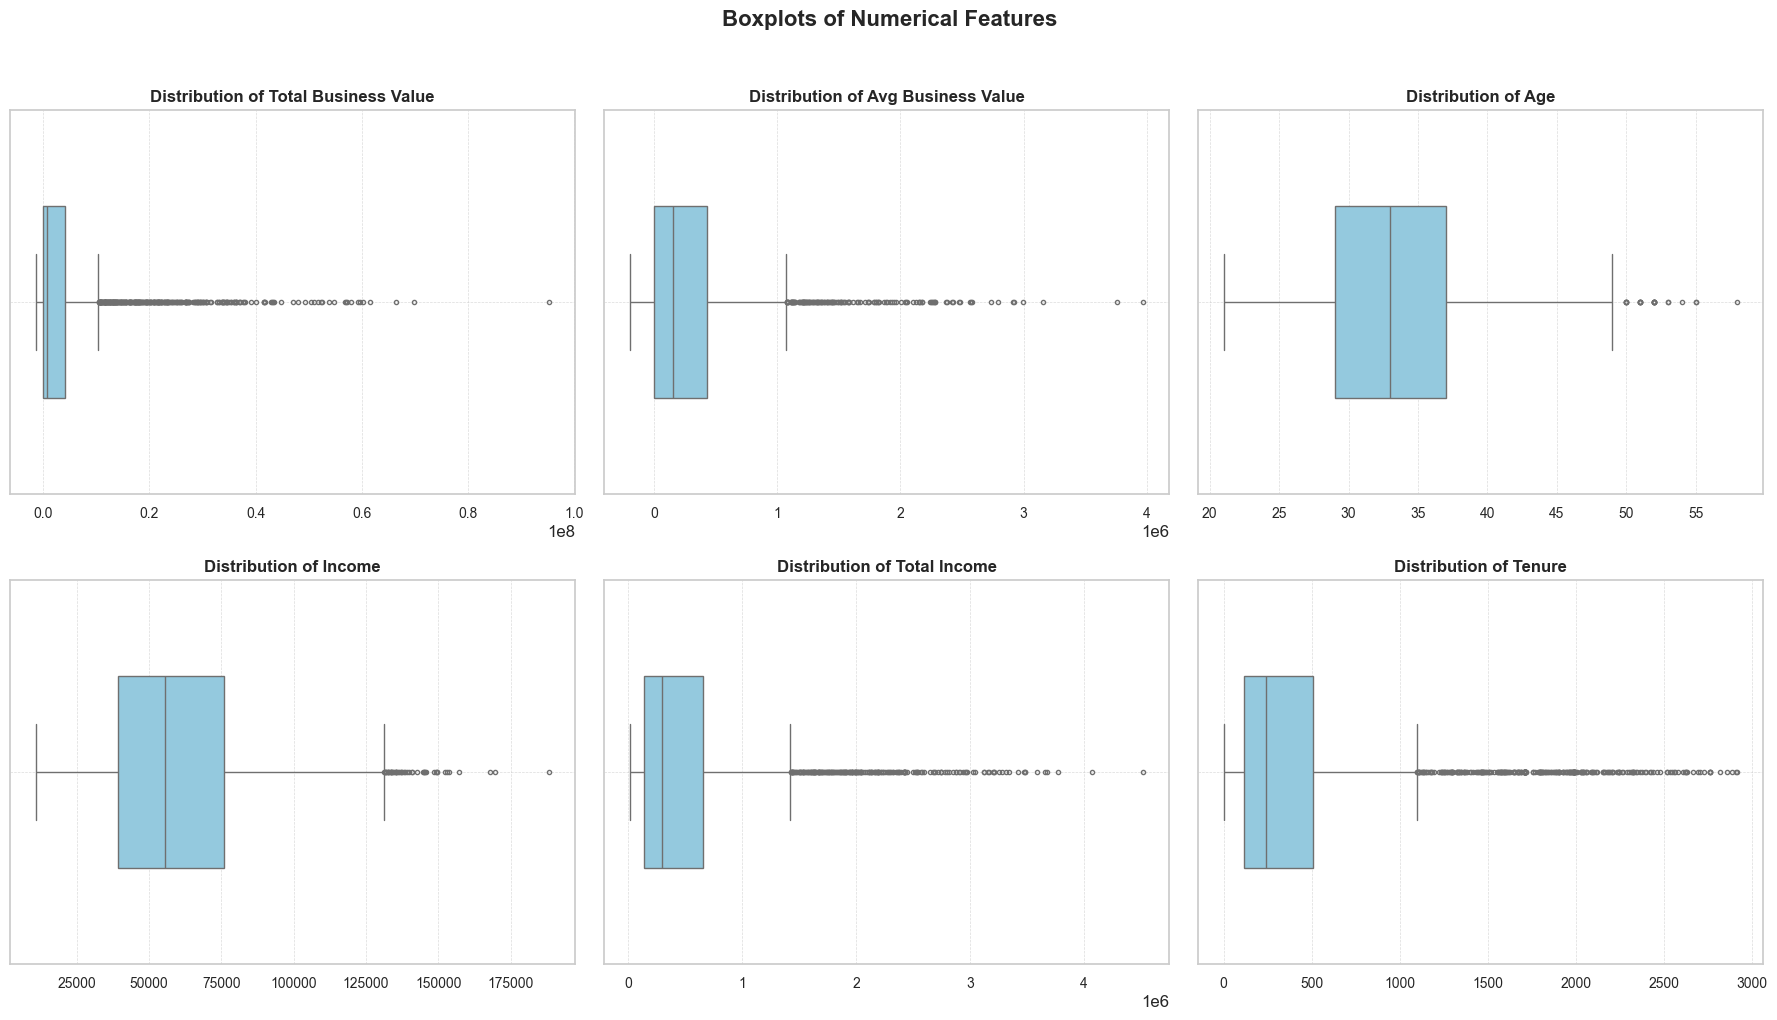

In [26]:
sns.set(style="whitegrid", palette="pastel", font_scale=1.1)

numerical_cols = ['Total_Business_Value', 'Avg_Business_Value', 'Age', 'Income', 'Total_Income', 'Tenure']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for i, col in enumerate(numerical_cols):
    ax = axes[i // 3, i % 3]
    sns.boxplot(x=merged_df[col], ax=ax, color='skyblue', width=0.5, fliersize=3, linewidth=1)
    ax.set_title(f'Distribution of {col.replace("_", " ")}', fontsize=12, fontweight='bold')
    ax.set_xlabel("")
    ax.tick_params(axis='x', labelsize=10)
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.suptitle("Boxplots of Numerical Features", fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### **Observations**

- From above plot we can see there are some outliers in total business value and average business value

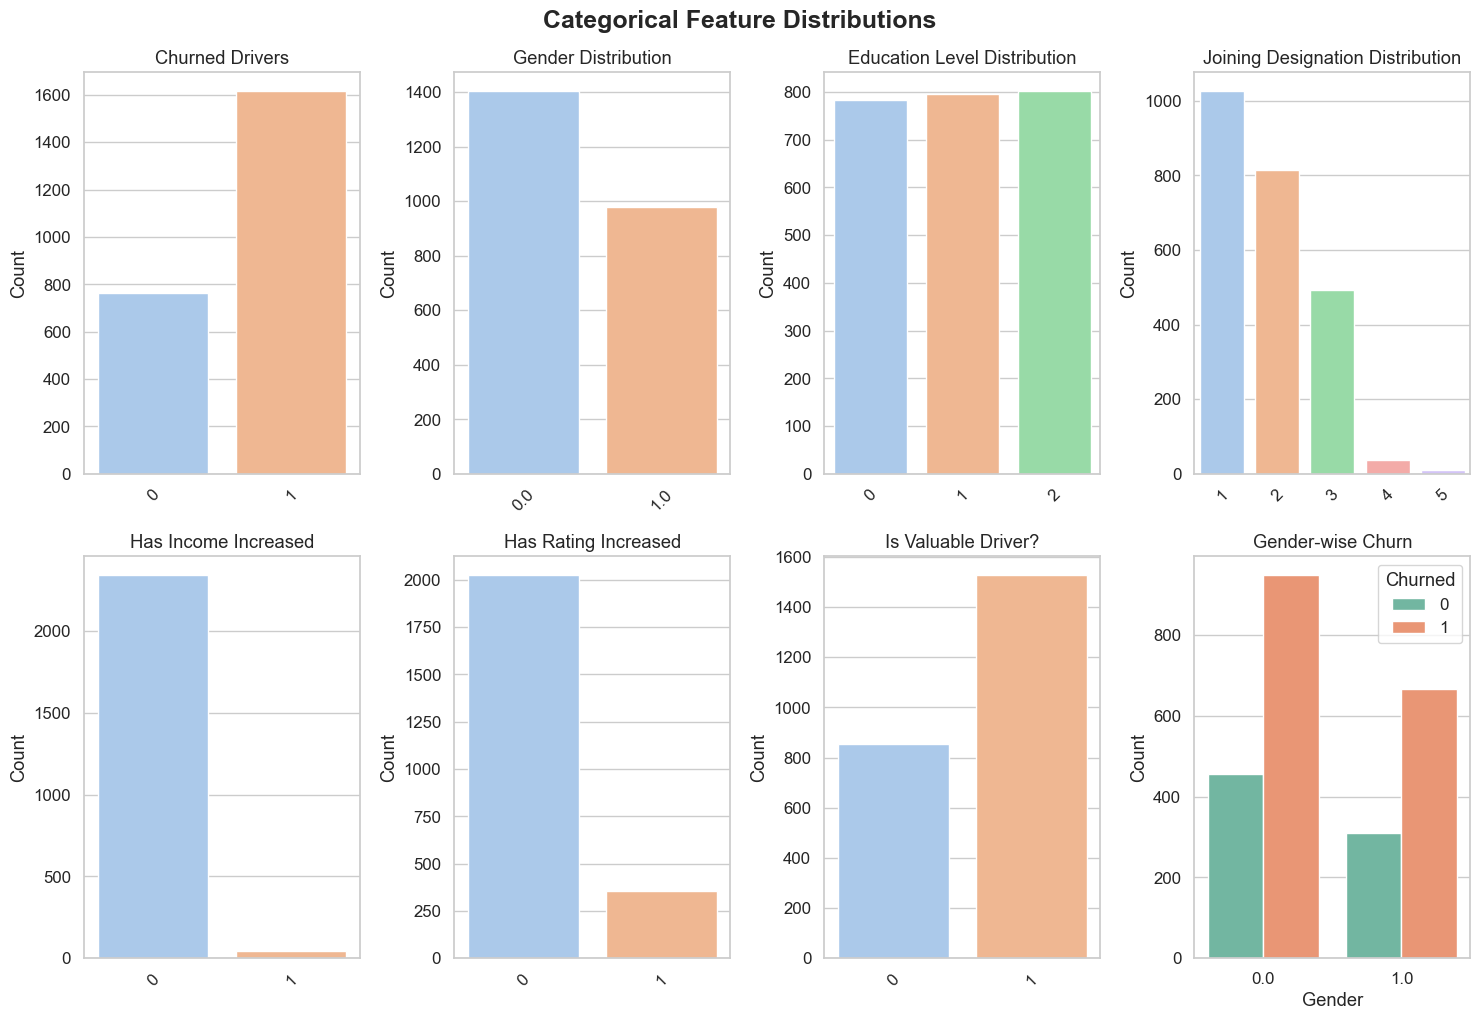

In [ ]:
sns.set(style="whitegrid", font_scale=1.1)

cat_cols = [
    ("Churned", "Churned Drivers"),
    ("Gender", "Gender Distribution"),
    ("Education_Level", "Education Level Distribution"),
    ("Joining_Designation", "Joining Designation Distribution"),
    ("Has_Income_Increased", "Has Income Increased"),
    ("Has_Rating_Increased", "Has Rating Increased"),
    ("Is_Valuable_Driver", "Is Valuable Driver?")
]

fig, axes = plt.subplots(2, 4, figsize=(15, 10))
axes = axes.flatten()

for i, (col, title) in enumerate(cat_cols):
    order = merged_df[col].value_counts().index if merged_df[col].dtype == 'O' else None
    sns.countplot(x=col, data=merged_df, ax=axes[i], palette="pastel", order=order)
    axes[i].set_title(title)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', rotation=45)

sns.countplot(x="Gender", hue="Churned", data=merged_df, palette="Set2", ax=axes[-1])
axes[-1].set_title("Gender-wise Churn")
axes[-1].set_xlabel("Gender")
axes[-1].set_ylabel("Count")
axes[-1].legend(title="Churned")

plt.tight_layout()
plt.suptitle("Categorical Feature Distributions", fontsize=18, fontweight='bold', y=1.02)
plt.show()

### **Observations**

- In the dataset there are 1616 churned drivers
- There are 1404 male and 977 female drivers
- Almost all educations levels of drivers aew same
- Most drivers joined at 1 designation
- We can see that only 43 drivers have increased their income
- Out of all the drivers only 358 drivers has increased their rating 
- 668 female drivers have churned
- 948 male drivers have churned

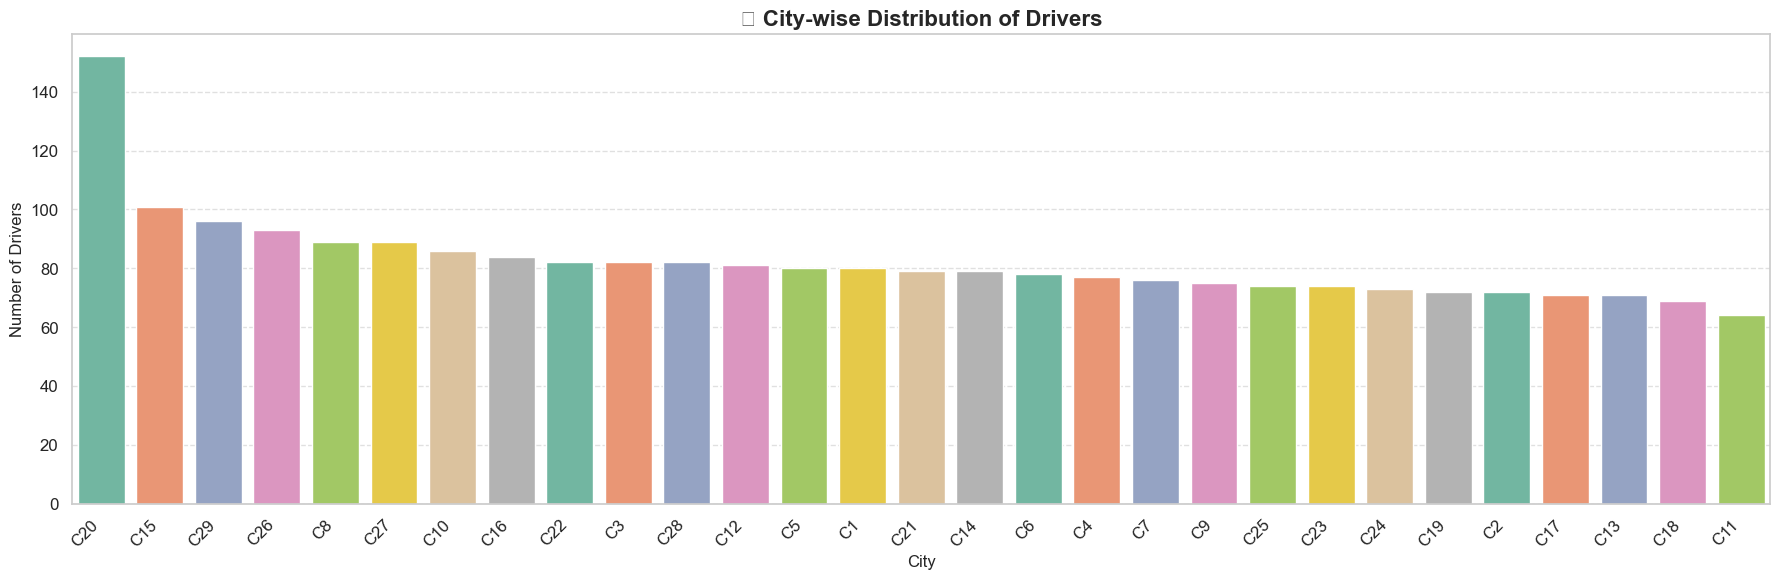

In [28]:
city_order = merged_df['City'].value_counts().index

sns.set(style="whitegrid", font_scale=1.1)

plt.figure(figsize=(18, 6))
sns.countplot(data=merged_df, x="City", order=city_order, palette="Set2")

plt.title("ðŸš• City-wise Distribution of Drivers", fontsize=16, fontweight='bold')
plt.xlabel("City", fontsize=12)
plt.ylabel("Number of Drivers", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

### **Observations**

- We can see that C20 has the highest number of drivers

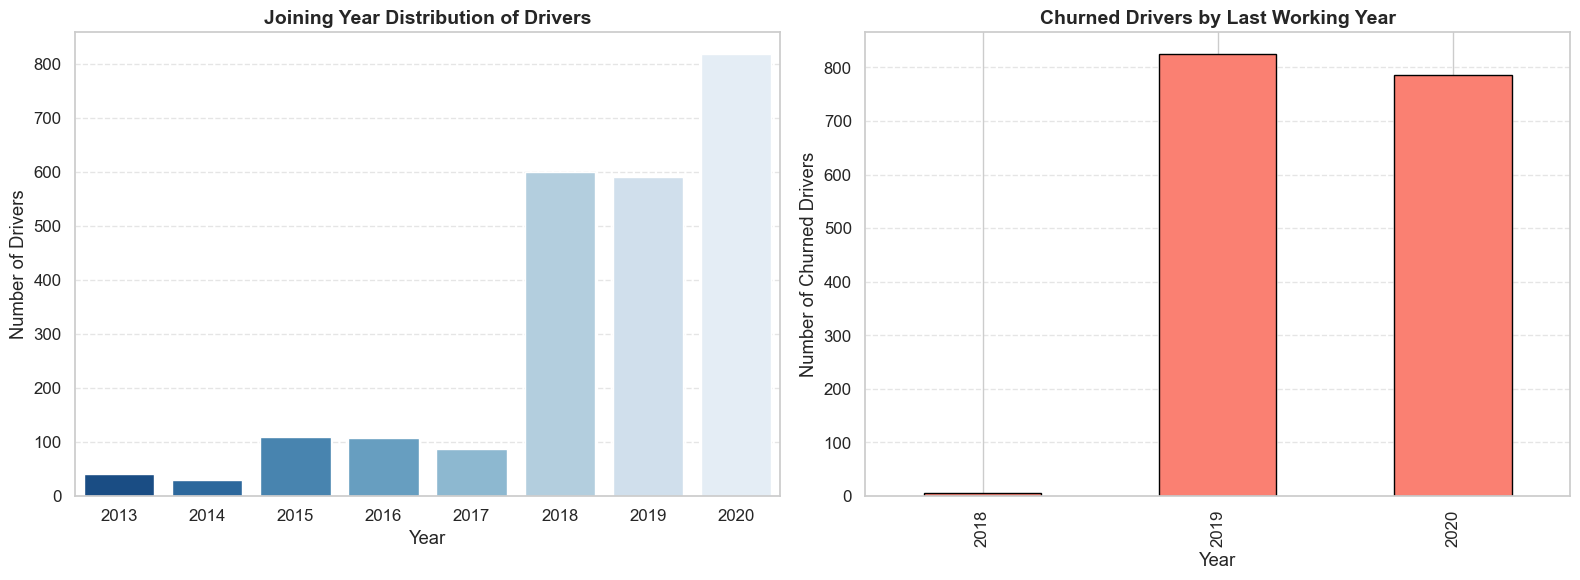

In [29]:
sns.set(style="whitegrid", font_scale=1.1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.countplot(
    x="Date_Of_Joining_year",
    data=merged_df,
    palette="Blues_r",
    ax=ax[0]
)
ax[0].set_title("Joining Year Distribution of Drivers", fontsize=14, fontweight="bold")
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Number of Drivers")
ax[0].grid(axis='y', linestyle='--', alpha=0.5)

merged_df[merged_df["Churned"] == 1]["Last_Working_Date"].dt.year.value_counts().sort_index().plot(
    kind="bar",
    ax=ax[1],
    color="salmon",
    edgecolor="black"
)
ax[1].set_title("Churned Drivers by Last Working Year", fontsize=14, fontweight="bold")
ax[1].set_xlabel("Year")
ax[1].set_ylabel("Number of Churned Drivers")
ax[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### **Observations**

- We can see that there was large number of drivers who joined during 2018, and large exit of drivers during 2019

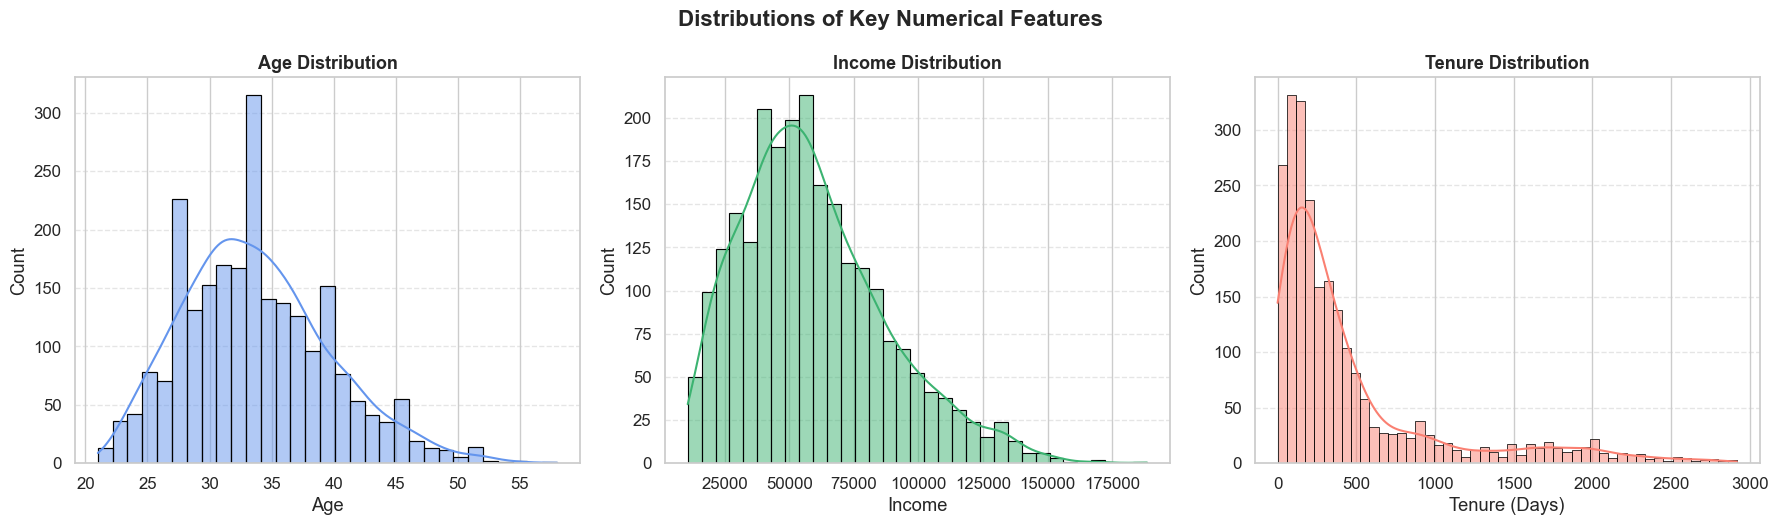

In [30]:
sns.set(style="whitegrid", font_scale=1.1)

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(merged_df["Age"], kde=True, color="cornflowerblue", ax=ax[0], edgecolor="black")
ax[0].set_title("Age Distribution", fontsize=13, fontweight='bold')
ax[0].set_xlabel("Age")
ax[0].set_ylabel("Count")
ax[0].grid(axis='y', linestyle='--', alpha=0.5)

sns.histplot(merged_df["Income"], kde=True, color="mediumseagreen", ax=ax[1], edgecolor="black")
ax[1].set_title("Income Distribution", fontsize=13, fontweight='bold')
ax[1].set_xlabel("Income")
ax[1].set_ylabel("Count")
ax[1].grid(axis='y', linestyle='--', alpha=0.5)

sns.histplot(merged_df["Tenure"], kde=True, color="salmon", ax=ax[2], edgecolor="black")
ax[2].set_title("Tenure Distribution", fontsize=13, fontweight='bold')
ax[2].set_xlabel("Tenure (Days)")
ax[2].set_ylabel("Count")
ax[2].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.suptitle("Distributions of Key Numerical Features", fontsize=16, fontweight='bold', y=1.05)
plt.show()

### **Observations**

1. **Age Distribution**:

   * Most drivers are aged **between 28 and 38 years**, with a slight **right skew**.
   * Indicates a young to mid-career workforce.

2. **Income Distribution**:

   * Follows a **positively skewed** (right-skewed) distribution.
   * Majority earn **â‚¹40,000â€“â‚¹70,000**, with a few high-income outliers above â‚¹1.5 lakh.

3. **Tenure Distribution**:

   * Highly **right-skewed** â€” most drivers have **shorter tenures (<500 days)**.
   * Suggests frequent churn or short-term contracts.


#### **Bivariate Analysis**

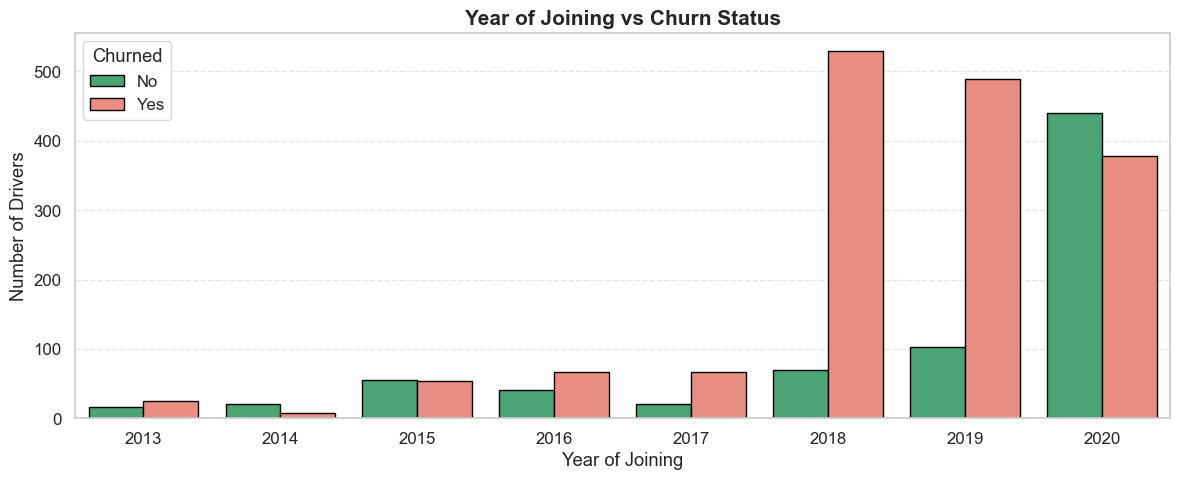

In [31]:
sns.set(style="whitegrid", font_scale=1.1)

plt.figure(figsize=(12, 5))
sns.countplot(
    x="Date_Of_Joining_year",
    data=merged_df,
    hue="Churned",
    palette={0: "mediumseagreen", 1: "salmon"},
    edgecolor="black"
)

plt.title("Year of Joining vs Churn Status", fontsize=15, fontweight='bold')
plt.xlabel("Year of Joining")
plt.ylabel("Number of Drivers")
plt.legend(title="Churned", labels=["No", "Yes"])
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### **Observations**

- We can see that there was big churn of drivers who joined in 2018, 2019 and 2020

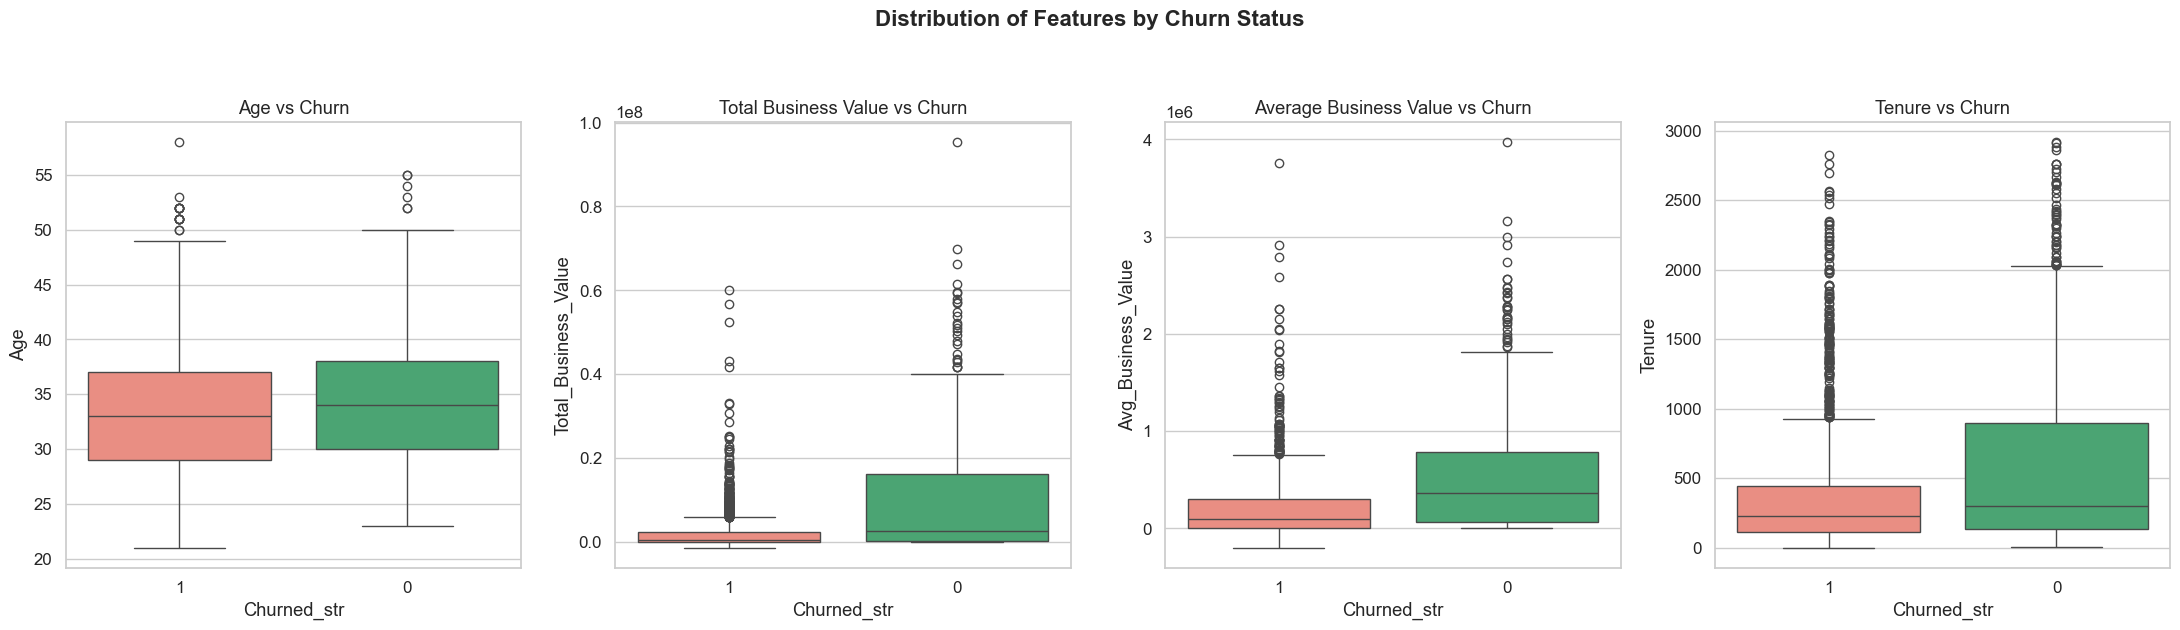

In [32]:
merged_df["Churned_str"] = merged_df["Churned"].astype(str)

palette = {"0": "mediumseagreen", "1": "salmon"}

fig, ax = plt.subplots(1, 4, figsize=(22, 6))

sns.boxplot(data=merged_df, x="Churned_str", y="Age", palette=palette, ax=ax[0])
ax[0].set_title("Age vs Churn")

sns.boxplot(data=merged_df, x="Churned_str", y="Total_Business_Value", palette=palette, ax=ax[1])
ax[1].set_title("Total Business Value vs Churn")

sns.boxplot(data=merged_df, x="Churned_str", y="Avg_Business_Value", palette=palette, ax=ax[2])
ax[2].set_title("Average Business Value vs Churn")

sns.boxplot(data=merged_df, x="Churned_str", y="Tenure", palette=palette, ax=ax[3])
ax[3].set_title("Tenure vs Churn")

plt.suptitle("Distribution of Features by Churn Status", fontsize=16, fontweight="bold", y=1.05)
plt.tight_layout()
plt.show()

### **Observations**

* **Age vs Churn**:
  Thereâ€™s **no major age difference** between churned and retained drivers â€” suggesting age might not be a primary churn driver.

* **Total Business Value**:
  Drivers who **did not churn** clearly contributed **significantly more total business value**. This hints that **high-performing drivers are more likely to be retained**.

* **Tenure**:
  Tenure (time since joining) is **much shorter for churned drivers**, meaning **newer drivers are more likely to leave**, while long-tenured drivers are more loyal.

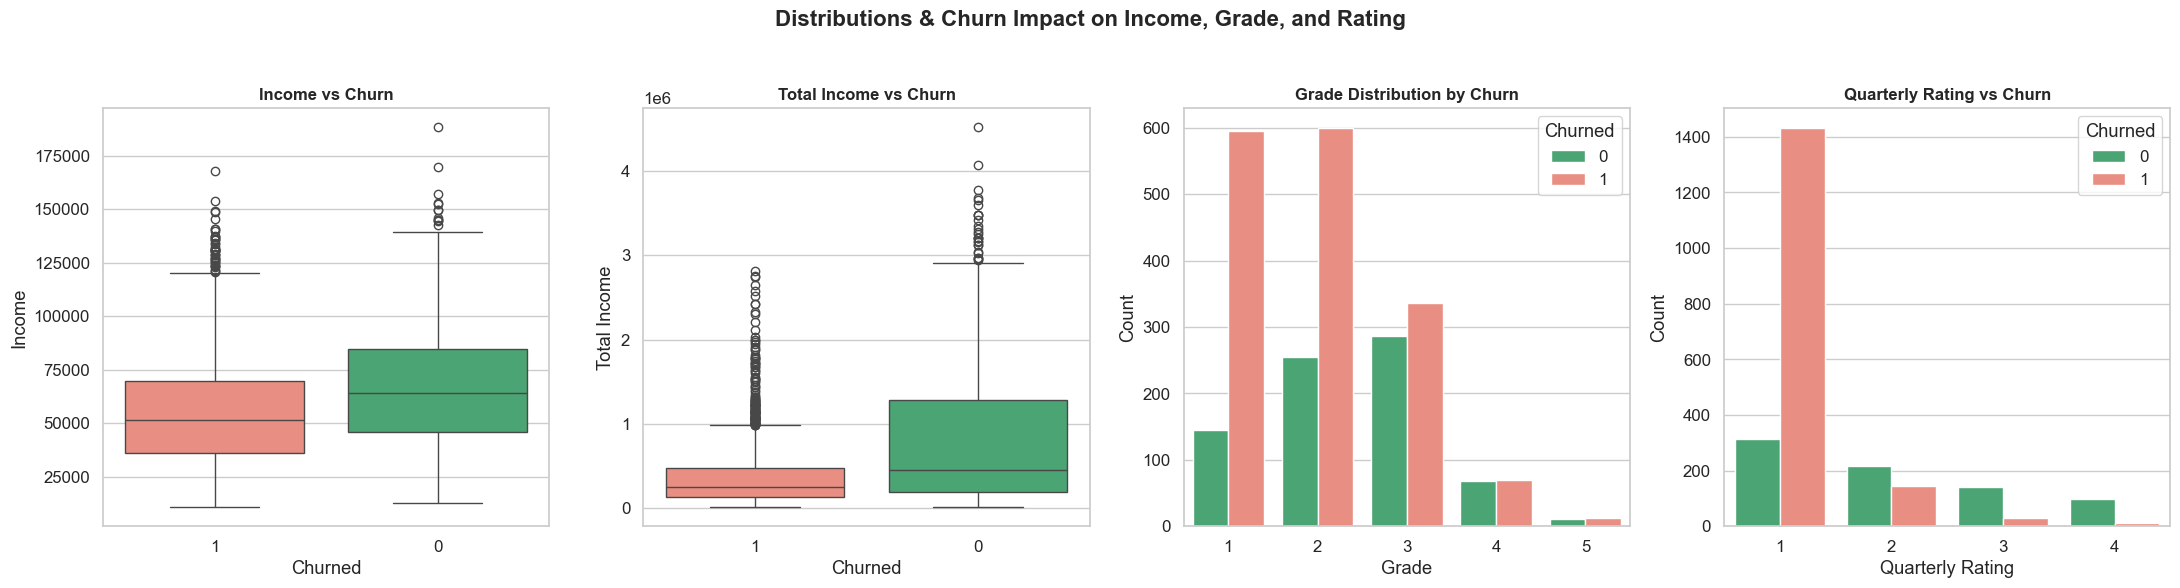

In [33]:
fig, ax = plt.subplots(1, 4, figsize=(22, 6))
fig.suptitle("Distributions & Churn Impact on Income, Grade, and Rating", fontsize=16, fontweight="bold")

sns.boxplot(data=merged_df, x="Churned_str", y="Income", palette={'0': "mediumseagreen", '1': "salmon"}, ax=ax[0])
ax[0].set_title("Income vs Churn", fontsize=12, fontweight="bold")
ax[0].set_xlabel("Churned")
ax[0].set_ylabel("Income")

sns.boxplot(data=merged_df, x="Churned_str", y="Total_Income", palette={'0': "mediumseagreen", '1': "salmon"}, ax=ax[1])
ax[1].set_title("Total Income vs Churn", fontsize=12, fontweight="bold")
ax[1].set_xlabel("Churned")
ax[1].set_ylabel("Total Income")

sns.countplot(data=merged_df, x="Grade", hue="Churned", palette={0: "mediumseagreen", 1: "salmon"}, ax=ax[2])
ax[2].set_title("Grade Distribution by Churn", fontsize=12, fontweight="bold")
ax[2].set_xlabel("Grade")
ax[2].set_ylabel("Count")
ax[2].legend(title="Churned")

sns.countplot(data=merged_df, x="Quarterly_Rating", hue="Churned", palette={0: "mediumseagreen", 1: "salmon"}, ax=ax[3])
ax[3].set_title("Quarterly Rating vs Churn", fontsize=12, fontweight="bold")
ax[3].set_xlabel("Quarterly Rating")
ax[3].set_ylabel("Count")
ax[3].legend(title="Churned")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### **Observations**

1. **Income Impact**
   * Drivers who **churned** tend to have significantly **lower income** and **total earnings** than those who stayed.

2. **Grade Distribution**

   * Most drivers fall within **Grade 1, 2, and 3**.
   * A **majority of churned drivers** are concentrated in **Grade 1 and 2**, suggesting that lower-ranked employees are more vulnerable to churn.
   * **Grade 4 and 5** drivers are **rare** and show **lower churn**, possibly due to better incentives or stability.

3. **Quarterly Rating Influence**

   * A striking number of **churned drivers** had a **rating of 1**, the lowest possible.
   * Very **few churned drivers** had high ratings (3 or 4).

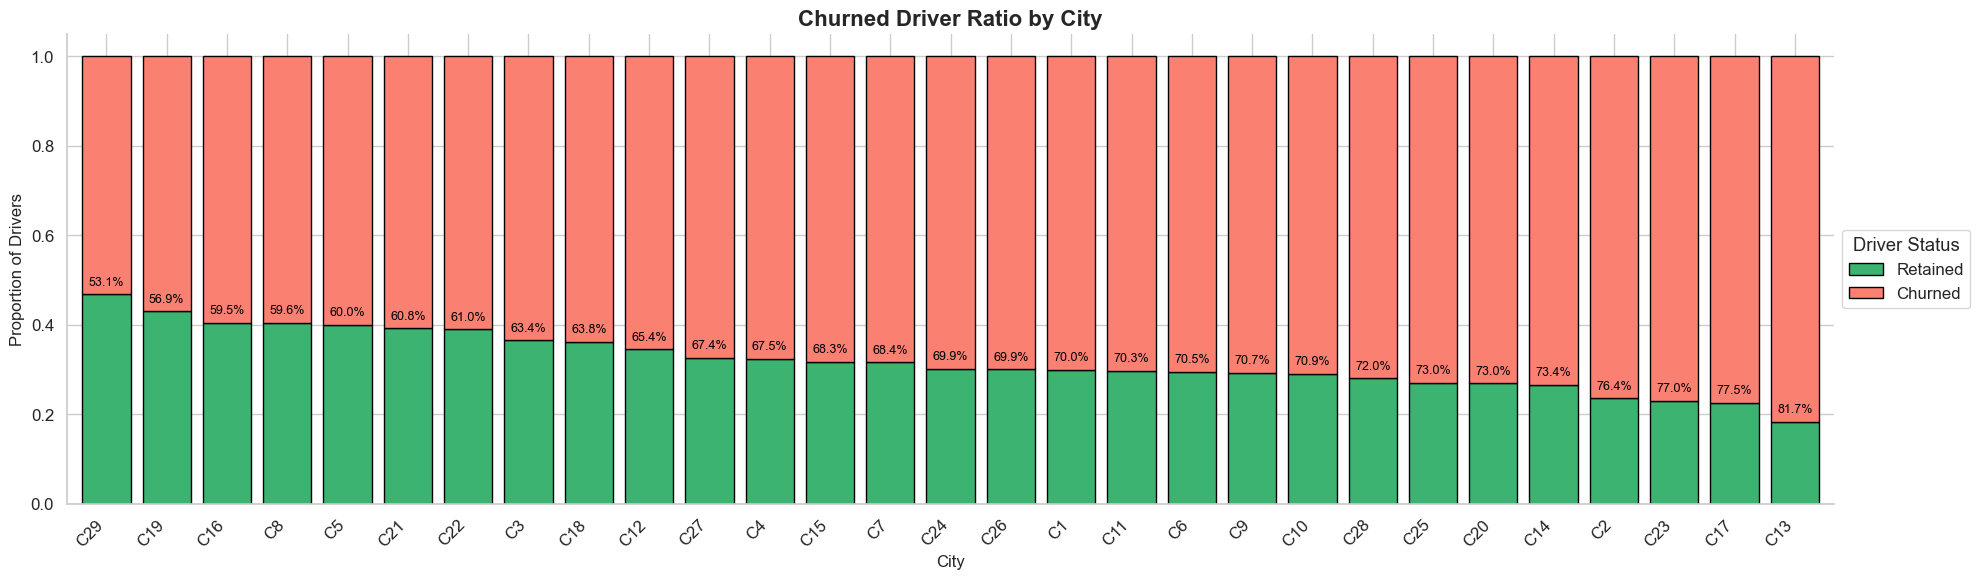

In [34]:
churn_by_city = pd.crosstab(merged_df["City"], merged_df["Churned"], normalize="index")

churn_by_city = churn_by_city.sort_values(1)
colors = ["mediumseagreen", "salmon"]

fig, ax = plt.subplots(figsize=(20, 6))

churn_by_city.plot(
    kind="bar",
    stacked=True,
    color=colors,
    ax=ax,
    edgecolor='black',
    width=0.8
)

ax.set_title("Churned Driver Ratio by City", fontsize=16, fontweight='bold')
ax.set_ylabel("Proportion of Drivers", fontsize=12)
ax.set_xlabel("City", fontsize=12)
plt.xticks(rotation=45, ha="right")

ax.legend(["Retained", "Churned"], title="Driver Status", loc='center left', bbox_to_anchor=(1, 0.5))
sns.despine()

for idx, row in enumerate(churn_by_city.itertuples()):
    churn_pct = row[2] * 100
    ax.text(idx, row[1] + 0.02, f"{churn_pct:.1f}%", ha='center', fontsize=9, color='black')

plt.tight_layout()
plt.show()

### **Observation**

1. **High Churn Cities**:

   * Cities like **C13 (81.7%)**, **C17 (77.5%)**, and **C23 (77.0%)** exhibit the **highest churn ratios**, indicating a potential issue with driver satisfaction, operations, or market conditions in these regions.

2. **Moderate Churn Cities**:

   * Cities such as **C10 to C15** show churn rates between **68% to 73%**, which are **above average** and still concerning.

3. **Low Churn Cities**:

   * Cities like **C29 (53.1%)**, **C19 (56.9%)**, and **C16 (59.5%)** have **better retention**, making them **relatively healthier regions** for operations.

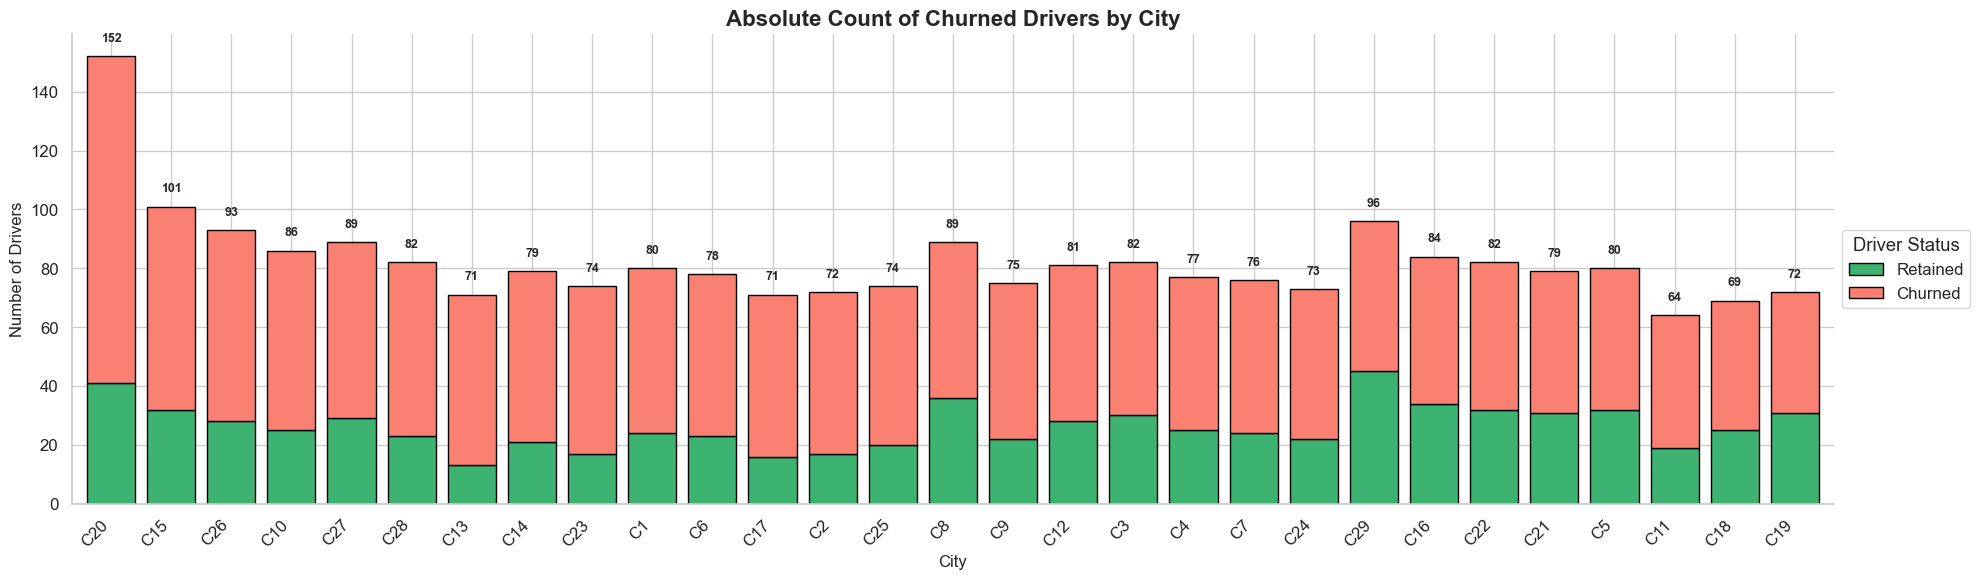

In [35]:
city_churn_counts = pd.crosstab(merged_df["City"], merged_df["Churned"])
city_churn_counts = city_churn_counts.sort_values(by=1, ascending=False)  # Sort by churn count

fig, ax = plt.subplots(figsize=(20, 6))
colors = ["mediumseagreen", "salmon"]

city_churn_counts.plot(
    kind="bar",
    stacked=True,
    color=colors,
    edgecolor="black",
    width=0.8,
    ax=ax
)

ax.set_title("Absolute Count of Churned Drivers by City", fontsize=16, fontweight='bold')
ax.set_xlabel("City", fontsize=12)
ax.set_ylabel("Number of Drivers", fontsize=12)
plt.xticks(rotation=45, ha="right")

ax.legend(["Retained", "Churned"], title="Driver Status", loc="center left", bbox_to_anchor=(1, 0.5))
sns.despine()

for idx, (city, row) in enumerate(city_churn_counts.iterrows()):
    total = row[0] + row[1]
    ax.text(idx, total + 5, f"{total}", ha="center", fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

### **Observations**

**1. Churned Driver Ratio by City (Proportional View)**

**Insight:**

* **City C13** has the **highest churn rate**, with over **80%** of its drivers having churned.
* Cities like **C17, C23, C2, C14, and C20** also show a **high proportion of churned drivers**, exceeding **70%**.
* **City C29** stands out with the **lowest churn rate** (\~53% churn), indicating better driver retention.

**2. Absolute Count of Churned Drivers by City**

**Insight:**

* **City C20** has the **highest absolute number of churned drivers** (\~150), making it a critical area for churn management.
* Despite its low churn rate, **C29** has a large driver base (close to 100 churned), indicating high volume but relatively better retention.
* Cities like **C10, C15, and C26** also show high churn volume.

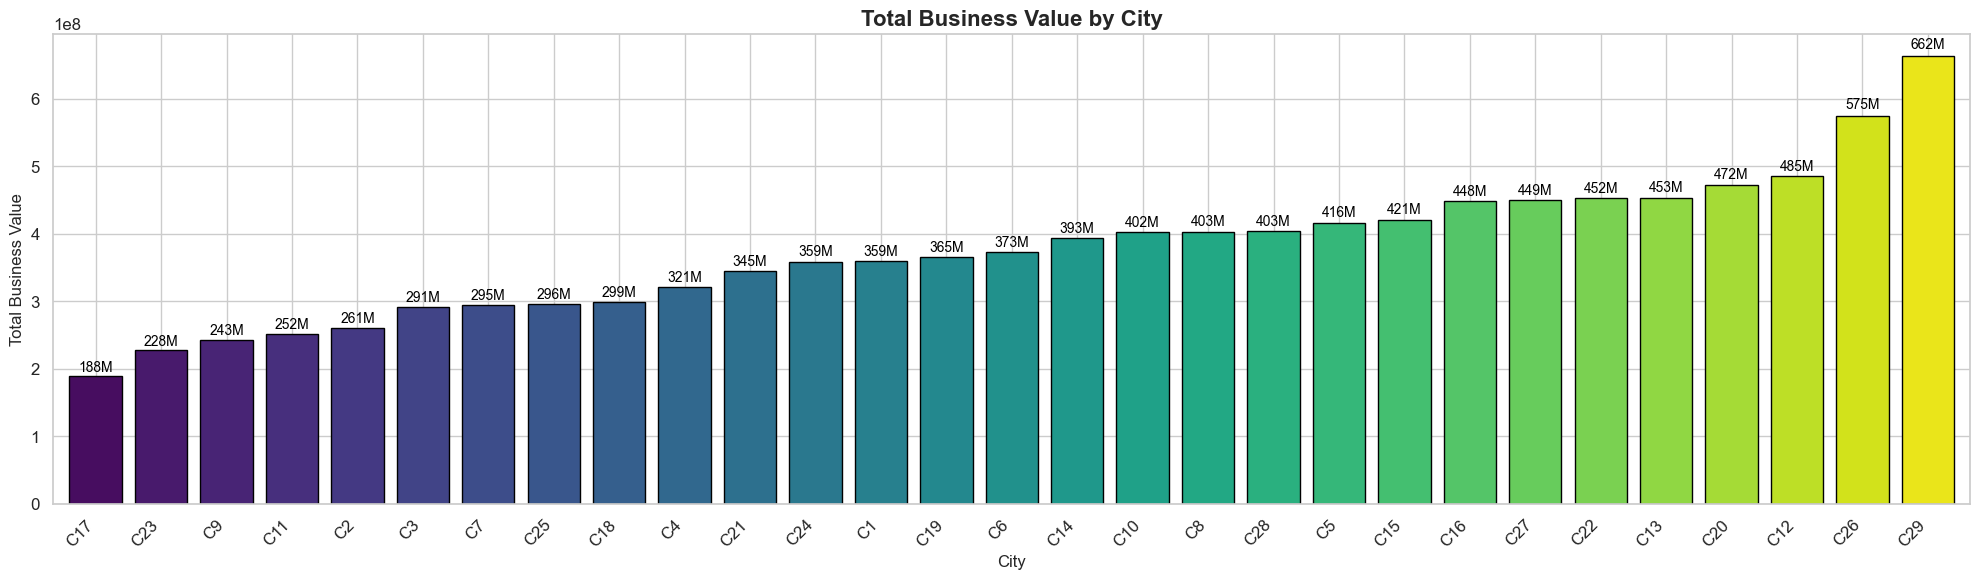

In [36]:
plt.figure(figsize=(20, 6))

ax = merged_df.groupby("City")["Total_Business_Value"].sum().sort_values().plot(
    kind="bar",
    color=sns.color_palette("viridis", len(merged_df["City"].unique())),
    edgecolor="black",
    width=0.8  
)

plt.title("Total Business Value by City", fontsize=16, fontweight="bold")
plt.xlabel("City", fontsize=12)
plt.ylabel("Total Business Value", fontsize=12)

plt.xticks(rotation=45, ha='right')

for p in ax.patches:
    value = p.get_height()
    if value > 0:
        ax.annotate(f'{int(value/1e6)}M',
                    (p.get_x() + p.get_width() / 2, value + (value * 0.01)), 
                    ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

### **Observations**
- From above plot we can see that C29 makes the highest revenue

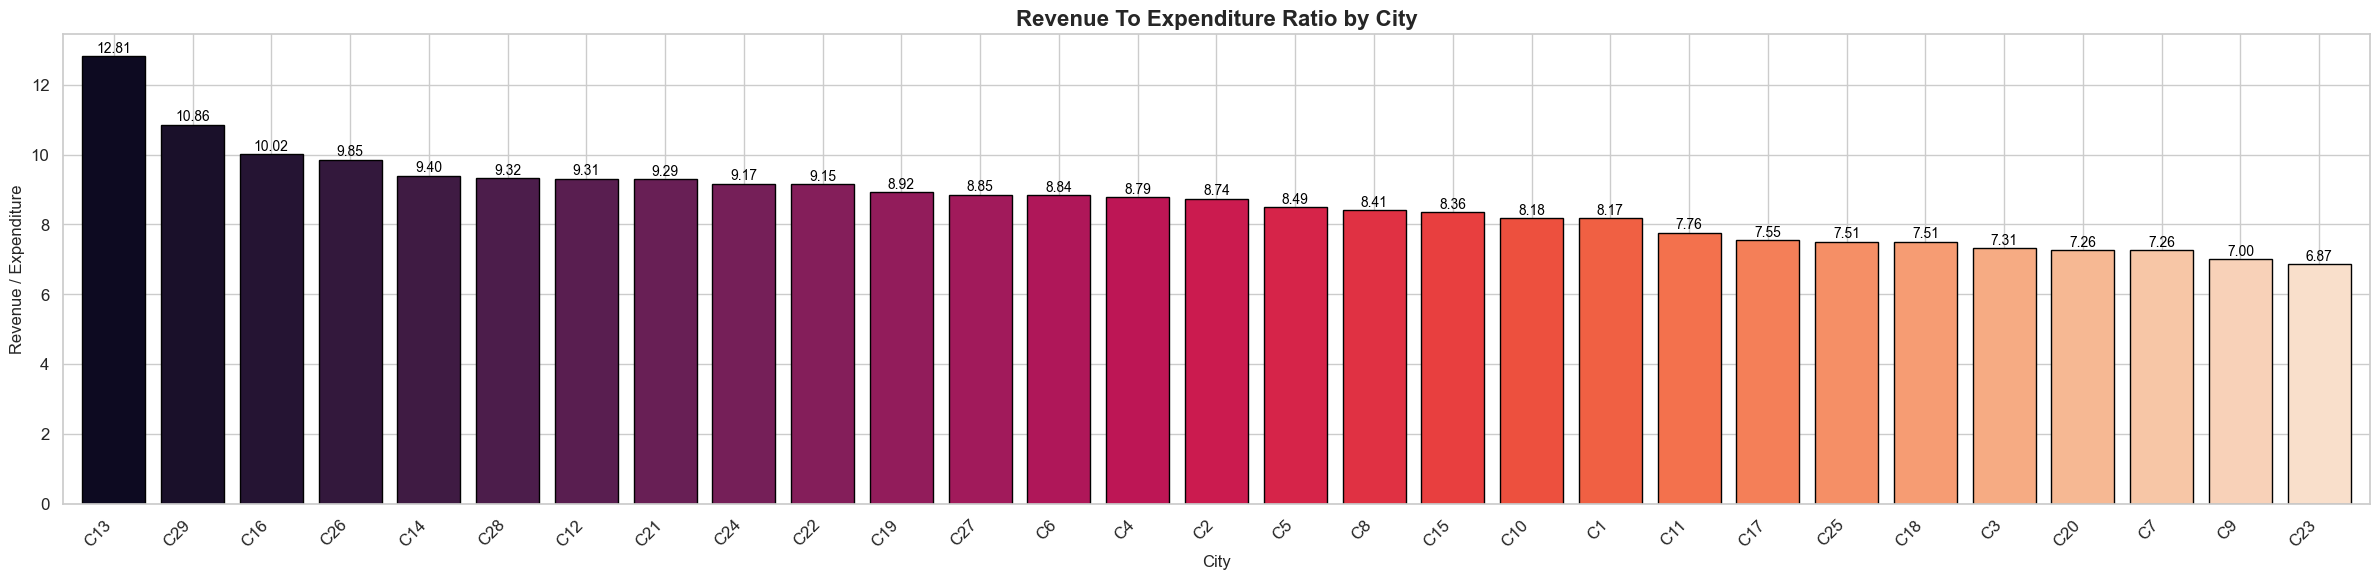

In [37]:
city_ratio_df = merged_df.groupby("City").agg({
    "Total_Business_Value": "sum",
    "Total_Income": "sum"
}).reset_index()

city_ratio_df["Revenue_To_Expenditure_Ratio"] = (city_ratio_df["Total_Business_Value"] / city_ratio_df["Total_Income"]).round(2)
city_ratio_df = city_ratio_df.sort_values("Revenue_To_Expenditure_Ratio", ascending=False)

ax = city_ratio_df.plot.bar(
    x="City",
    y="Revenue_To_Expenditure_Ratio",
    figsize=(24, 6),  # <-- FIGURE SIZE APPLIED HERE
    color=sns.color_palette("rocket", len(city_ratio_df)),
    edgecolor="black",
    width=0.8,
    legend=False
)

plt.title("Revenue To Expenditure Ratio by City", fontsize=16, fontweight="bold")
plt.xlabel("City", fontsize=12)
plt.ylabel("Revenue / Expenditure", fontsize=12)
plt.xticks(rotation=45, ha="right")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}',
                (p.get_x() + p.get_width() / 2, height + 0.02),
                ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

### **Observations**

- Above plot shows that C13 city has the best revenue to expense ratio

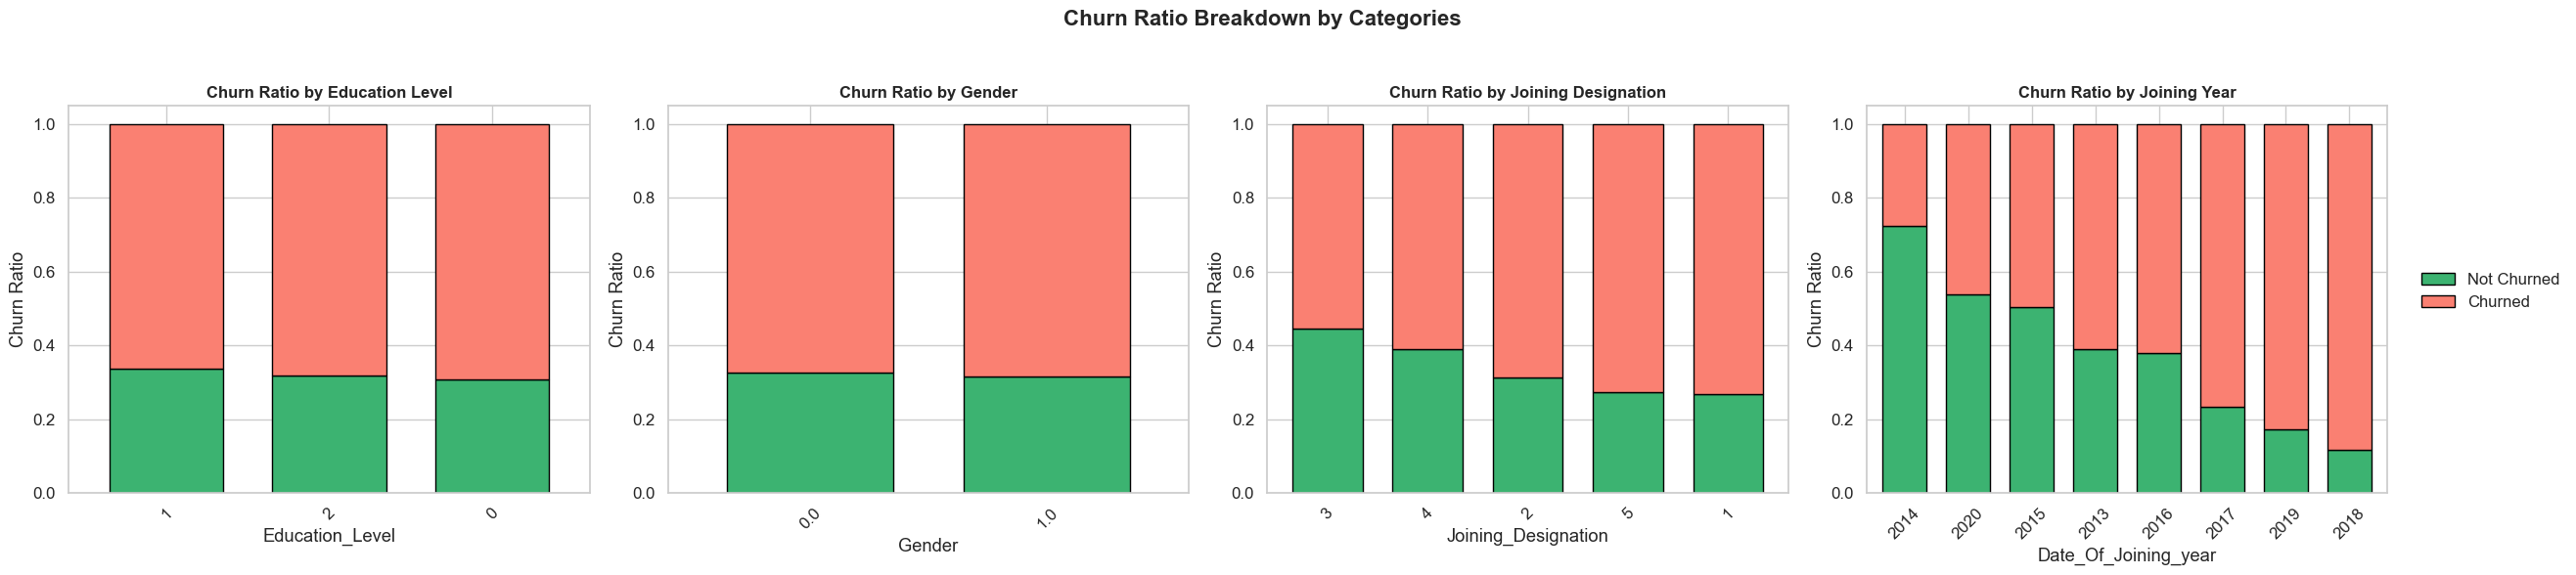

In [38]:
fig, ax = plt.subplots(1, 4, figsize=(26, 6))  
fig.suptitle("Churn Ratio Breakdown by Categories", fontsize=16, fontweight="bold")

plot_configs = [
    ("Education_Level", "Churn Ratio by Education Level"),
    ("Gender", "Churn Ratio by Gender"),
    ("Joining_Designation", "Churn Ratio by Joining Designation"),
    ("Date_Of_Joining_year", "Churn Ratio by Joining Year")
]

for i, (col, title) in enumerate(plot_configs):
    plot_data = pd.crosstab(merged_df[col], merged_df["Churned"], normalize="index").sort_values(1)
    plot_data.plot(
        kind="bar",
        stacked=True,
        ax=ax[i],
        color=["mediumseagreen", "salmon"],
        edgecolor="black",
        width=0.7,
        legend=False  
    )
    ax[i].set_title(title, fontsize=12, fontweight="bold")
    ax[i].set_ylabel("Churn Ratio")
    ax[i].tick_params(axis='x', rotation=45)

fig.legend(
    ["Not Churned", "Churned"],
    loc="center left",
    bbox_to_anchor=(0.95, 0.5),
    fontsize=12,
    frameon=False
)

plt.tight_layout(rect=[0, 0, 0.95, 0.95])
plt.show()


### **Observations**

- We can see that Gender and Education level donot have significant effect on Churn
- From above plot we can see that Joining designation and Joining year have significant effect on churn

    * **Joining Designation**: Higher churn in Designation 1 & 5.
    * **Year of Joining**: The drivers joined in 2018-2019 churned more, whereas drivers joint in 2014 churned less


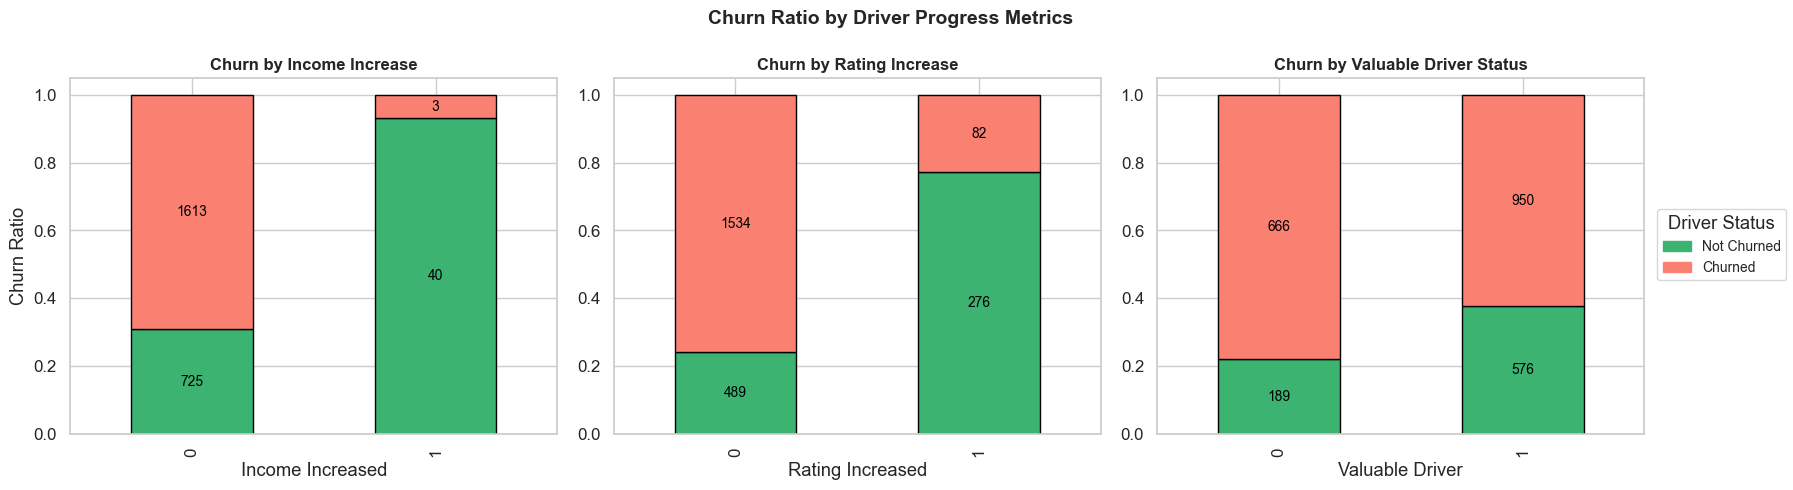

In [39]:
from matplotlib.patches import Patch

fig, ax = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

colors = ["mediumseagreen", "salmon"]

categories = [
    ("Has_Income_Increased", "Churn by Income Increase", "Income Increased"),
    ("Has_Rating_Increased", "Churn by Rating Increase", "Rating Increased"),
    ("Is_Valuable_Driver", "Churn by Valuable Driver Status", "Valuable Driver")
]

for i, (col, title, xlabel) in enumerate(categories):
    ctab = pd.crosstab(merged_df[col], merged_df["Churned"])
    norm_ctab = ctab.div(ctab.sum(axis=1), axis=0)
    
    norm_ctab.plot(kind="bar", stacked=True, ax=ax[i], color=colors, edgecolor="black", legend=False)
    ax[i].set_title(title, fontsize=12, fontweight="bold")
    ax[i].set_xlabel(xlabel)
    ax[i].set_ylabel("Churn Ratio" if i == 0 else "")

    for bar_group, total in zip(ax[i].containers, ctab.values.T):  
        for rect, val in zip(bar_group, total):
            height = rect.get_height()
            ax[i].text(
                rect.get_x() + rect.get_width() / 2,     
                rect.get_y() + height / 2,               
                str(val),                                
                ha='center', va='center', fontsize=10, color='black'
            )

legend_handles = [
    Patch(color="mediumseagreen", label="Not Churned"),
    Patch(color="salmon", label="Churned")
]
fig.legend(handles=legend_handles, loc='center right', title="Driver Status", fontsize=10)

plt.suptitle("Churn Ratio by Driver Progress Metrics", fontsize=14, fontweight="bold")
plt.tight_layout(rect=[0, 0, 0.93, 1])
plt.show()

### **Observations**

**1. Income Increase vs Churn**

* **Drivers without income increase (0):**

  * **Churned**: 1613 drivers
  * **Not Churned**: 725 drivers
  * Churn rate is significantly **higher** among drivers who didnâ€™t get an income increase.
* **Drivers with income increase (1):**

  * **Churned**: Only 3 drivers
  * **Not Churned**: 40 drivers
  * Indicates a **strong retention effect** of income growth.

**Insight**: **Lack of income growth** is highly associated with **churn**. Drivers rewarded with better pay are **far more likely to stay**.

---

**2. Rating Increase vs Churn**

* **Drivers with no rating increase (0):**

  * **Churned**: 1534 drivers
  * **Not Churned**: 489 drivers
* **Drivers with rating increase (1):**

  * **Churned**: 82 drivers
  * **Not Churned**: 276 drivers

**Insight**: Drivers who **improved their performance ratings** were **less likely to churn**. **Recognition and progress** matter for retention.

---

**3. Valuable Driver Status vs Churn**

* **Not Valuable (0):**

  * **Churned**: 666 drivers
  * **Not Churned**: 189 drivers
* **Valuable (1):**

  * **Churned**: 950 drivers
  * **Not Churned**: 576 drivers

**Insight**: Even among **valuable drivers**, churn still occursâ€”but retention is **notably better** compared to non-valuable ones.

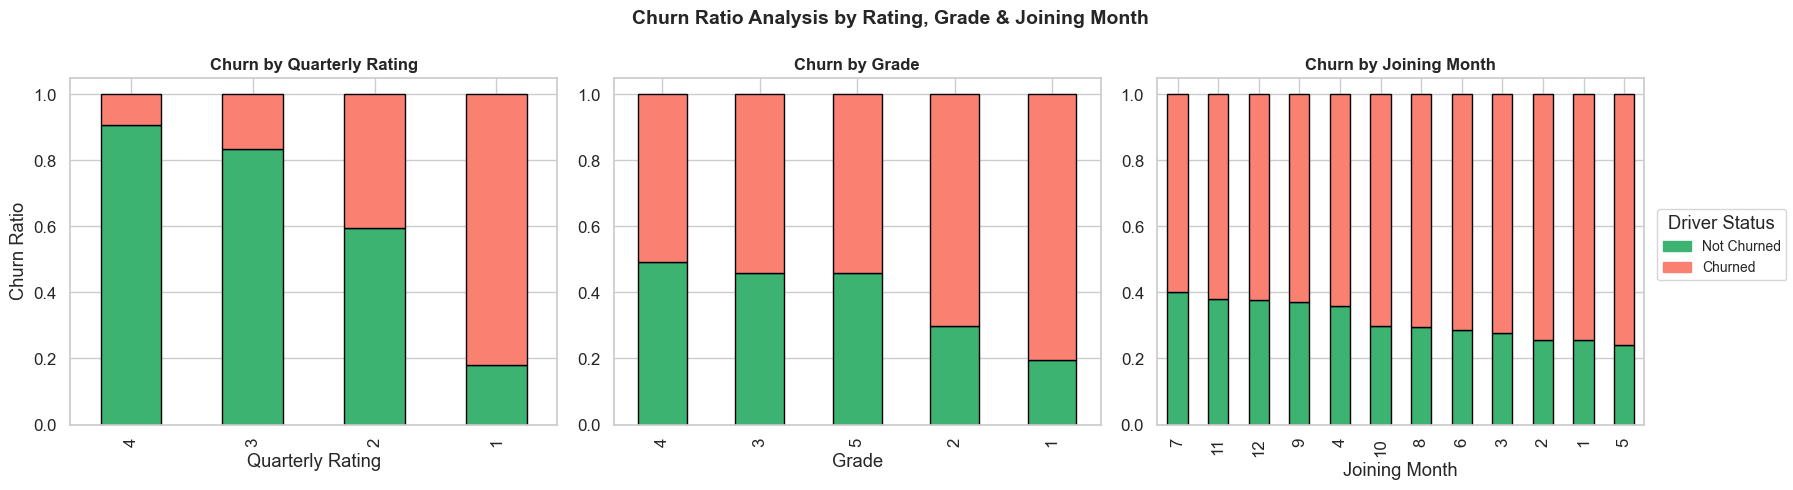

In [40]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

pd.crosstab(merged_df["Quarterly_Rating"], merged_df["Churned"], normalize="index") \
  .sort_values(1) \
  .plot(kind="bar", stacked=True, ax=ax[0], color=colors, edgecolor="black", legend=False)
ax[0].set_title("Churn by Quarterly Rating", fontsize=12, fontweight="bold")
ax[0].set_ylabel("Churn Ratio")
ax[0].set_xlabel("Quarterly Rating")

pd.crosstab(merged_df["Grade"], merged_df["Churned"], normalize="index") \
  .sort_values(1) \
  .plot(kind="bar", stacked=True, ax=ax[1], color=colors, edgecolor="black", legend=False)
ax[1].set_title("Churn by Grade", fontsize=12, fontweight="bold")
ax[1].set_ylabel("")
ax[1].set_xlabel("Grade")

pd.crosstab(merged_df["Date_Of_Joining_month"], merged_df["Churned"], normalize="index") \
  .sort_values(1) \
  .plot(kind="bar", stacked=True, ax=ax[2], color=colors, edgecolor="black", legend=False)
ax[2].set_title("Churn by Joining Month", fontsize=12, fontweight="bold")
ax[2].set_ylabel("")
ax[2].set_xlabel("Joining Month")

legend_handles = [
    Patch(color="mediumseagreen", label="Not Churned"),
    Patch(color="salmon", label="Churned")
]
fig.legend(handles=legend_handles, loc="center right", title="Driver Status", fontsize=10)

plt.suptitle("Churn Ratio Analysis by Rating, Grade & Joining Month", fontsize=14, fontweight="bold")
plt.tight_layout(rect=[0, 0, 0.93, 1])
plt.show()

### **Observations**

**Quarterly Rating vs Churn**

* From above plot we can see that **none of the drivers got Quarterly rating as 5**
* Drivers with **low ratings (1 and 2)** have significantly higher churn ratios.
* **Higher-rated drivers (3 and 4)** tend to **stay longer**, indicating **performance is positively correlated with retention**.

**Grade vs Churn**

* **Grade 1 and 2 drivers churn the most**, possibly due to lower compensation, limited growth, or job dissatisfaction.
* **Grade 4 drivers show the highest retention**, suggesting **senior positions are more stable**.

**Joining Month vs Churn**

* Drivers who joined in **May, January, and February** have **higher churn rates**.
* Joining in **July or November** appears to be **linked to better retention**

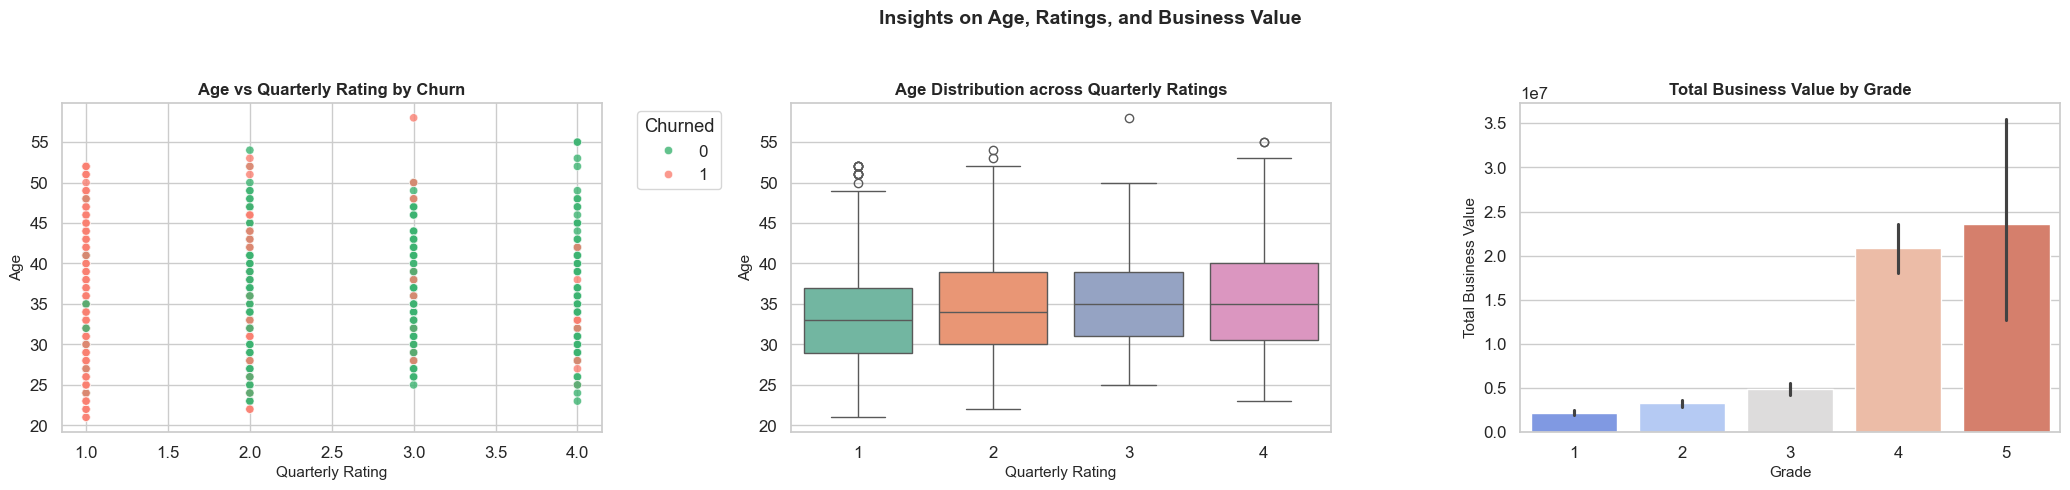

In [41]:
fig, ax = plt.subplots(1, 3, figsize=(22, 5))
palette = {0: "mediumseagreen", 1: "salmon"}

scatter = sns.scatterplot(
    data=merged_df, y="Age", x="Quarterly_Rating", hue="Churned",
    palette=palette, alpha=0.8, ax=ax[0]
)
ax[0].set_title("Age vs Quarterly Rating by Churn", fontsize=12, fontweight='bold')
ax[0].set_xlabel("Quarterly Rating", fontsize=11)
ax[0].set_ylabel("Age", fontsize=11)

ax[0].legend(title="Churned", bbox_to_anchor=(1.05, 1), loc='upper left')

sns.boxplot(
    data=merged_df, y="Age", x="Quarterly_Rating", palette="Set2", ax=ax[1]
)
ax[1].set_title("Age Distribution across Quarterly Ratings", fontsize=12, fontweight='bold')
ax[1].set_xlabel("Quarterly Rating", fontsize=11)
ax[1].set_ylabel("Age", fontsize=11)

sns.barplot(
    data=merged_df, y="Total_Business_Value", x="Grade", palette="coolwarm", ax=ax[2]
)
ax[2].set_title("Total Business Value by Grade", fontsize=12, fontweight='bold')
ax[2].set_xlabel("Grade", fontsize=11)
ax[2].set_ylabel("Total Business Value", fontsize=11)

plt.suptitle("Insights on Age, Ratings, and Business Value", fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 0.95, 0.95])  
plt.show()

### **Observations**

1. **Age vs Quarterly Rating by Churn**:

   * Drivers with a **Quarterly Rating of 1** are more likely to churn.
   * Across all ratings, churned drivers (red) are present across all age groups, but **higher ratings show lower churn**.

2. **Age Distribution across Quarterly Ratings**:

   * Median age is relatively **consistent across ratings**.
   * **Rating 4 drivers** show slightly **wider age spread**, indicating more experienced/older drivers may perform better.

3. **Total Business Value by Grade**:

   * **Grade 4 and 5 drivers** contribute significantly more to the **Total Business Value**.
   * This suggests **higher grade drivers are more valuable** to the business.


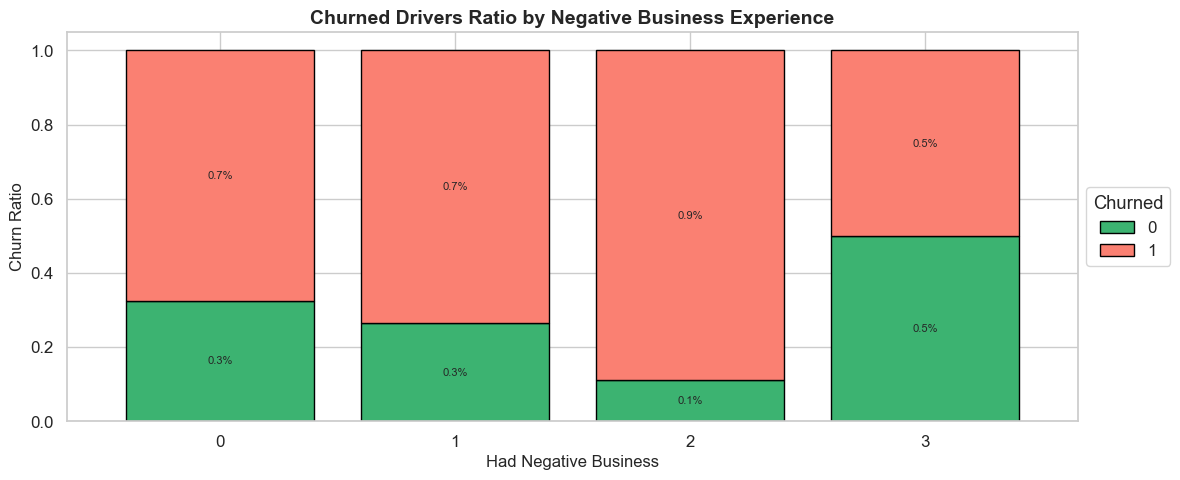

In [42]:
ct = pd.crosstab(
    merged_df["Total_Had_Negative_Business"], 
    merged_df["Churned"], 
    normalize="index"
)

fig, ax = plt.subplots(figsize=(12, 5))
ct.plot(kind="bar", stacked=True, ax=ax, color=["mediumseagreen", "salmon"], edgecolor="black", width=0.8)

ax.set_title("Churned Drivers Ratio by Negative Business Experience", fontsize=14, fontweight='bold')
ax.set_xlabel("Had Negative Business", fontsize=12)
ax.set_ylabel("Churn Ratio", fontsize=12)
ax.legend(title="Churned", loc="center left", bbox_to_anchor=(1, 0.5))

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center', fontsize=8)

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### **Observations**

* **0 or 1 Negative Business Month**:

  * Churn ratio is moderate (\~70%).
  * A substantial number of drivers still churn even with limited negative experience.

* **2 Negative Business Months**:

  * Churn ratio increases (\~90%).
  * Indicates a strong link: more negative months â†’ higher churn probability.

* **3 Negative Business Months**:

  * Slight drop in churn ratio (\~50%).
  * Might be due to **smaller sample size** or **anomalies**â€”needs deeper inspection.


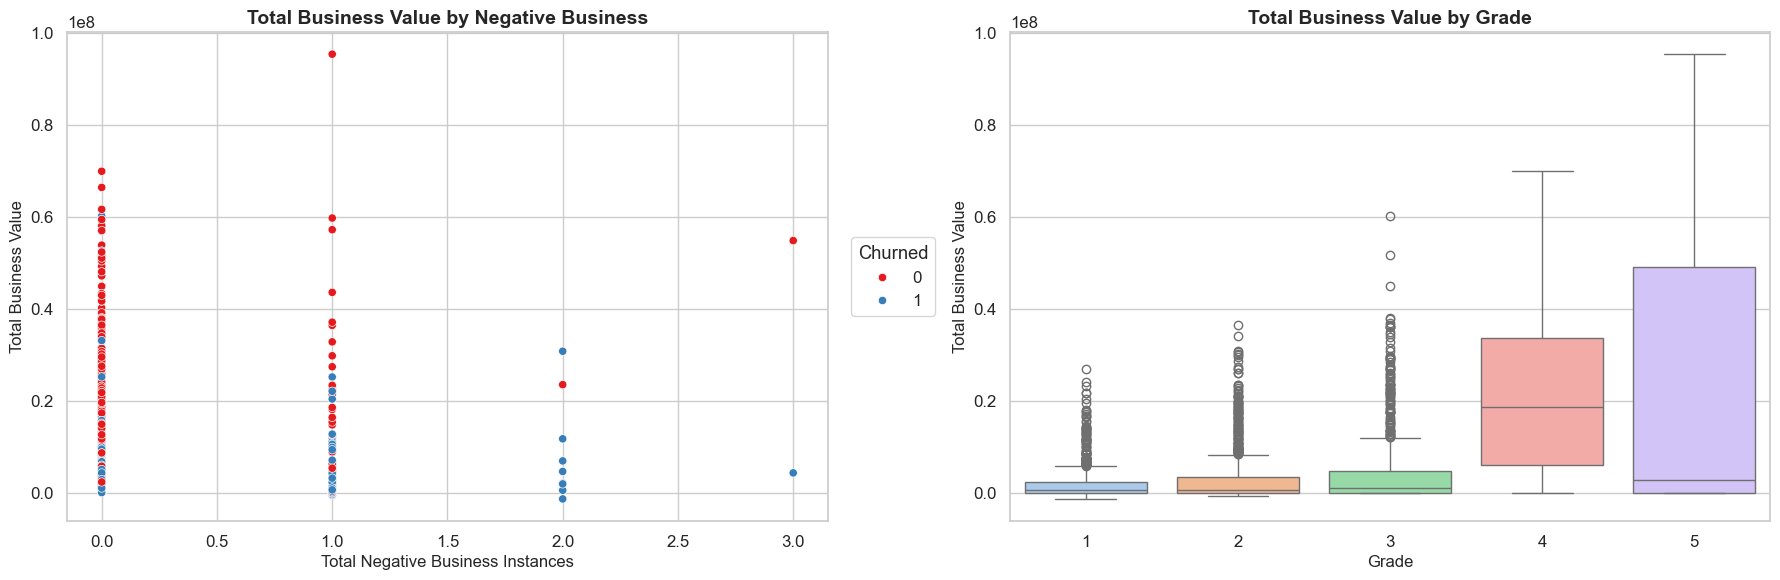

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

sns.scatterplot(
    data=merged_df,
    x="Total_Had_Negative_Business",
    y="Total_Business_Value",
    hue="Churned",
    palette="Set1",
    ax=ax[0]
)
ax[0].set_title("Total Business Value by Negative Business", fontsize=14, fontweight="bold")
ax[0].set_xlabel("Total Negative Business Instances", fontsize=12)
ax[0].set_ylabel("Total Business Value", fontsize=12)
ax[0].legend(title="Churned", loc="center left", bbox_to_anchor=(1.02, 0.5))

sns.boxplot(
    data=merged_df,
    x="Grade",
    y="Total_Business_Value",
    palette="pastel",
    ax=ax[1]
)
ax[1].set_title("Total Business Value by Grade", fontsize=14, fontweight="bold")
ax[1].set_xlabel("Grade", fontsize=12)
ax[1].set_ylabel("Total Business Value", fontsize=12)

plt.tight_layout()
plt.show()

### **Observations**

**Total Business Value by Negative Business (Churn-wise)**

* **Churned drivers (blue)** are more concentrated at lower `Total Business Value` across all negative business instances.
* **Non-churned drivers (red)** show a wider spread, often with **higher business values**, even when negative business instances exist.
* This suggests that **negative business alone doesnâ€™t guarantee churn**, but **low value + negative experience** is more churn-inducing.

**Right Plot: Total Business Value by Grade**

* A **clear upward trend** is visible: higher **grades correlate strongly** with **higher total business value**.
* **Grade 5 drivers** contribute significantly more business on average, with a **larger spread and higher upper quartile**.
* This highlights the **importance of retaining high-grade drivers**, as they generate disproportionately high business value.

In [44]:
df = df.sort_values(['City', 'ReportingYear'])

df['rating_1_flag'] = (df['Quarterly Rating'] == 1).astype(int)
df['rating_2_flag'] = (df['Quarterly Rating'] == 2).astype(int)
df['rating_3_flag'] = (df['Quarterly Rating'] == 3).astype(int)
df['rating_4_flag'] = (df['Quarterly Rating'] == 4).astype(int)

city_agg = (
    df.groupby(['City', 'ReportingYear'], as_index=False)
    .agg({
        'rating_1_flag': 'sum',
        'rating_2_flag': 'sum',
        'rating_3_flag': 'sum',
        'rating_4_flag': 'sum'
    })
    .rename(columns={
        'rating_1_flag': 'Total_Rating_1',
        'rating_2_flag': 'Total_Rating_2',
        'rating_3_flag': 'Total_Rating_3',
        'rating_4_flag': 'Total_Rating_4'
    })
)

city_agg['Rating_Chg_1'] = city_agg.groupby('City')['Total_Rating_1'].transform(lambda x: (x - x.shift(1)) / x).round(3)
city_agg['Rating_Chg_2'] = city_agg.groupby('City')['Total_Rating_2'].transform(lambda x: (x - x.shift(1)) / x).round(3)
city_agg['Rating_Chg_3'] = city_agg.groupby('City')['Total_Rating_3'].transform(lambda x: (x - x.shift(1)) / x).round(3)
city_agg['Rating_Chg_4'] = city_agg.groupby('City')['Total_Rating_4'].transform(lambda x: (x - x.shift(1)) / x).round(3)

rating_df = city_agg[['City', 'ReportingYear', 'Rating_Chg_1', 'Rating_Chg_2', 'Rating_Chg_3', 'Rating_Chg_4']].dropna()
df.drop(columns=['rating_1_flag', 'rating_2_flag', 'rating_3_flag', 'rating_4_flag'], inplace=True)

rating_df.head()

City  ReportingYear  Rating_Chg_1  Rating_Chg_2  Rating_Chg_3  Rating_Chg_4
1   C1           2020        -0.385        -0.659         0.016        -0.435
3  C10           2020         0.280        -0.085         0.050         0.179
5  C11           2020        -0.116        -0.763        -0.364        -0.143
7  C12           2020         0.191        -0.284         0.260         0.146
9  C13           2020        -0.273        -0.354         0.068        -0.333

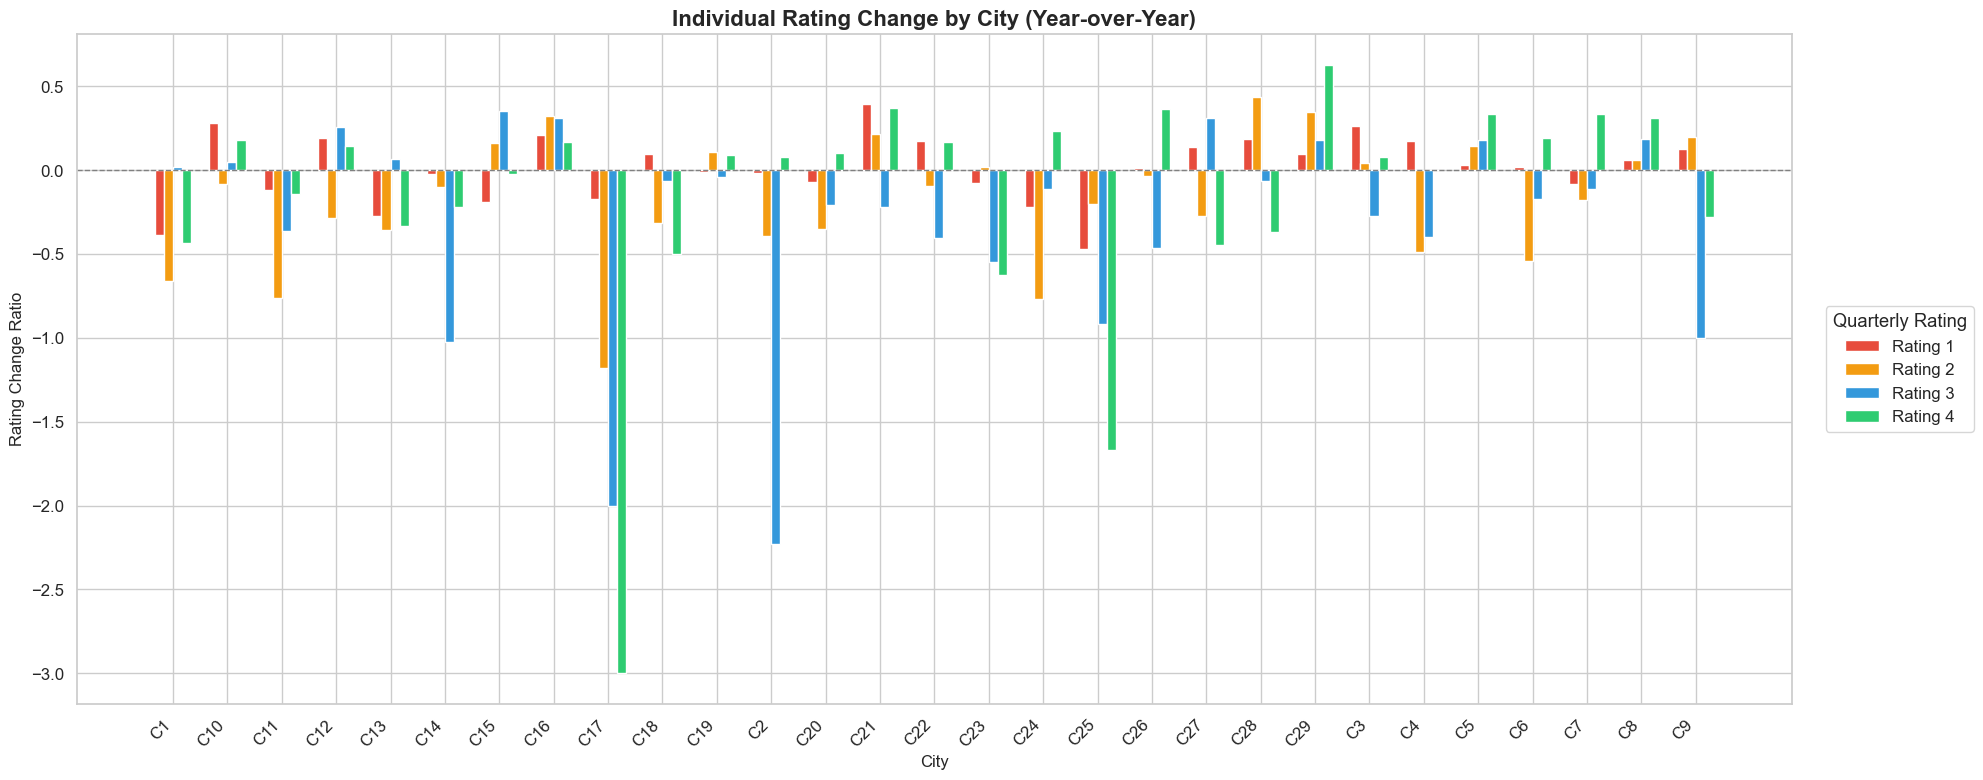

In [45]:
rating_df_sorted = rating_df.sort_values("City").reset_index(drop=True)
cities = rating_df_sorted["City"]
x = np.arange(len(cities)) * 1.2 

bar_width = 0.2

fig, ax = plt.subplots(figsize=(20, 8))
sns.set_style("whitegrid")

ax.bar(x - 1.5 * bar_width, rating_df_sorted["Rating_Chg_1"], width=bar_width, label='Rating 1', color="#e74c3c")
ax.bar(x - 0.5 * bar_width, rating_df_sorted["Rating_Chg_2"], width=bar_width, label='Rating 2', color="#f39c12")
ax.bar(x + 0.5 * bar_width, rating_df_sorted["Rating_Chg_3"], width=bar_width, label='Rating 3', color="#3498db")
ax.bar(x + 1.5 * bar_width, rating_df_sorted["Rating_Chg_4"], width=bar_width, label='Rating 4', color="#2ecc71")

ax.set_xticks(x)
ax.set_xticklabels(cities, rotation=45, ha='right')
ax.set_ylabel("Rating Change Ratio", fontsize=12)
ax.set_xlabel("City", fontsize=12)
ax.set_title("Individual Rating Change by City (Year-over-Year)", fontsize=16, fontweight='bold')

ax.axhline(0, color='gray', linestyle='--', linewidth=1)

ax.legend(title="Quarterly Rating", bbox_to_anchor=(1.02, 0.5), loc="center left", borderaxespad=0)

plt.tight_layout()
plt.show()

### **Observations**

* **C29** showed the **highest positive change** in **4-star ratings**, indicating strong year-over-year improvement in top performance.
* **C17** experienced the **largest overall drop** across **all rating types**, signaling a severe performance decline.
* **C2**, **C14**, and **C9** had **significant declines in 3-star ratings**, suggesting mid-tier performers struggled in these cities.
* **C6** and **C28** maintained **consistently positive or stable changes** across most ratings.
* **C11** and **C12** also showed **moderate positive shifts** in early-quarter ratings (Rating 1 and 2), indicating a good start but mixed trends later.

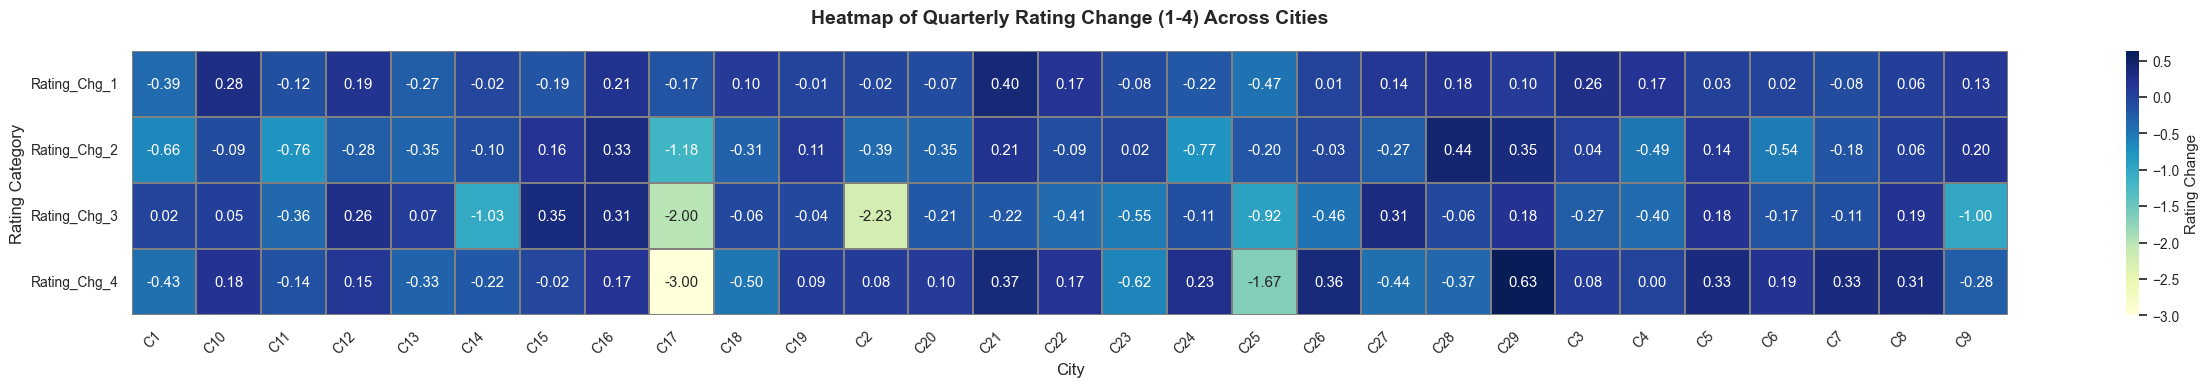

In [46]:
heatmap_df = rating_df[['City', 'Rating_Chg_1', 'Rating_Chg_2', 'Rating_Chg_3', 'Rating_Chg_4']]
heatmap_df = heatmap_df.set_index("City").T  

plt.figure(figsize=(25, 4))
sns.set(style="white", font_scale=0.9)

ax = sns.heatmap(
    heatmap_df,
    cmap="YlGnBu",
    annot=True,
    fmt=".2f",
    linewidths=0.3,
    linecolor="gray",
    cbar_kws={"label": "Rating Change"}
)

plt.title("Heatmap of Quarterly Rating Change (1-4) Across Cities", fontsize=14, weight='bold', pad=20)
plt.xlabel("City", fontsize=12)
plt.ylabel("Rating Category", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### **Observations**

* **C17** shows the **sharpest negative shift** in **Rating 4 (-3.00)** and **Rating 3 (-2.00)** â€” signaling drastic degradation in higher-tier feedback.
* **C2** experienced a **major drop** in **Rating 3 (-2.23)**, indicating a steep decline in mid-tier performance.
* **C18** had consistently poor performance, with all ratings showing negative values, especially **Rating 4 (-1.67)** and **Rating 2 (-1.18)**.
* **C29** stands out with the **highest positive gain** in **Rating 4 (+0.63)**, showing improvement in top-tier perception.
* **C25** faced a broad decline, notably **Rating 3 (-0.92)** and **Rating 4 (-1.67)**.
* Cities like **C3**, **C28**, and **C6** maintained relatively **balanced or improving trends**, with mild positive changes across ratings.


In [47]:
df['reporting_month_year'] = pd.to_datetime(df['reporting_month_year'])

quarterly_agg = (
    df.groupby(['Driver_ID', 'ReportingYear_Quarter', 'reporting_month_year'])['Quarterly Rating']
    .max()
    .reset_index()
)

for i in range(1, 5):
    quarterly_agg[f'rating_{i}_flag'] = (quarterly_agg['Quarterly Rating'] == i).astype(int)

rating_df = (
    quarterly_agg.groupby('reporting_month_year')[
        ['rating_1_flag', 'rating_2_flag', 'rating_3_flag', 'rating_4_flag']
    ]
    .sum()
    .reset_index()
    .rename(columns={
        'rating_1_flag': 'Total_Rating_1',
        'rating_2_flag': 'Total_Rating_2',
        'rating_3_flag': 'Total_Rating_3',
        'rating_4_flag': 'Total_Rating_4',
    })
    .sort_values('reporting_month_year')
)

rating_df.head()

reporting_month_year  Total_Rating_1  Total_Rating_2  Total_Rating_3  \
0           2019-01-01             426             318             188   
1           2019-02-01             348             318             188   
2           2019-03-01             279             315             187   
3           2019-04-01             325             242             154   
4           2019-05-01             292             243             154   

   Total_Rating_4  
0              90  
1              90  
2              89  
3              73  
4              75

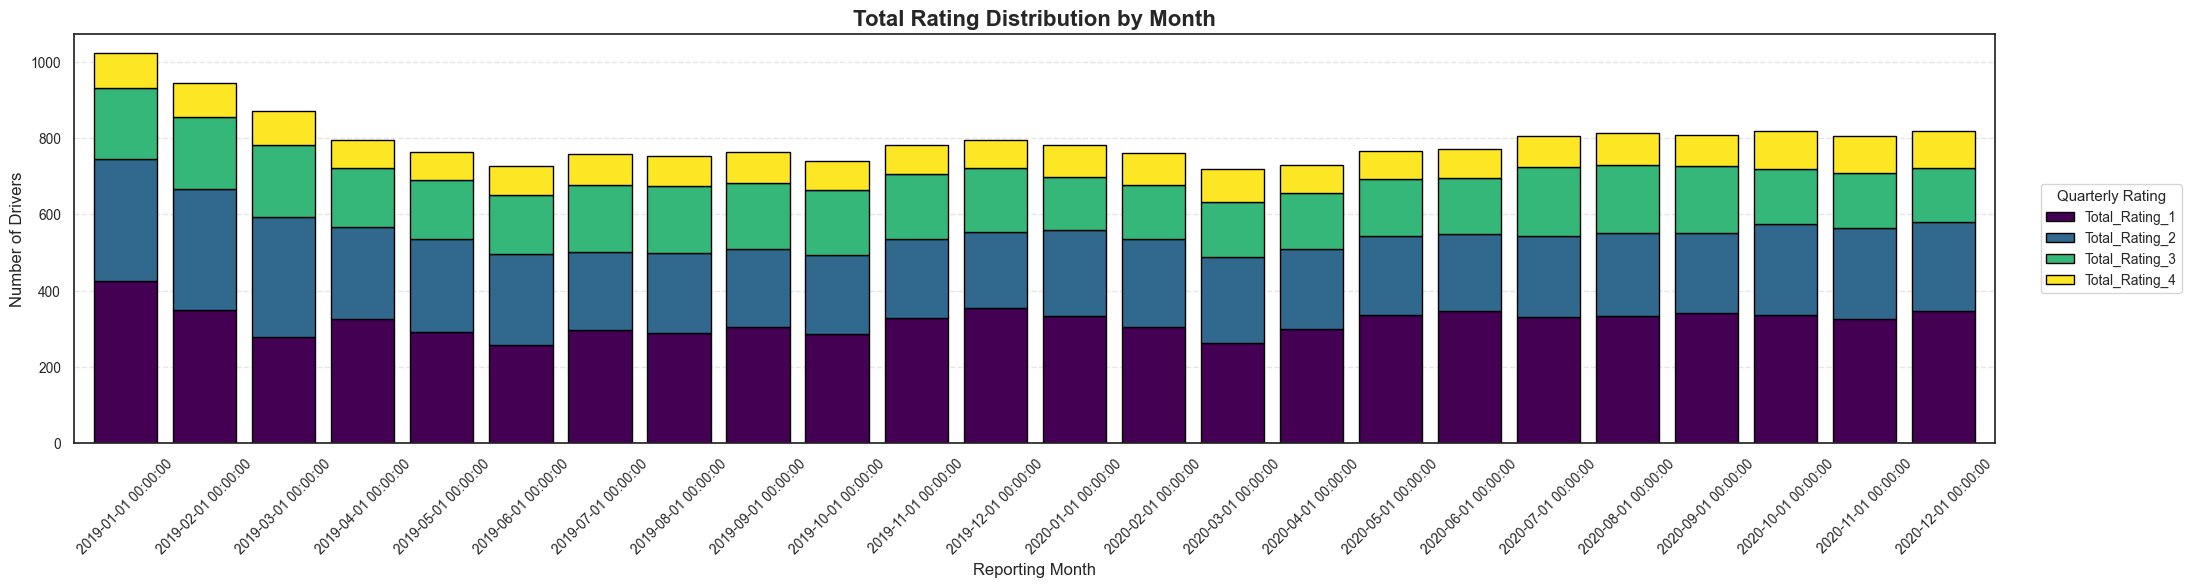

In [48]:
fig, ax = plt.subplots(figsize=(22, 6))

rating_df.plot(
    kind="bar",
    x="reporting_month_year",
    y=["Total_Rating_1", "Total_Rating_2", "Total_Rating_3", "Total_Rating_4"],
    stacked=True,
    width=0.8,
    cmap="viridis",
    edgecolor="black",
    ax=ax
)

ax.set_title("Total Rating Distribution by Month", fontsize=16, fontweight='bold')
ax.set_xlabel("Reporting Month", fontsize=12)
ax.set_ylabel("Number of Drivers", fontsize=12)
ax.tick_params(axis='x', rotation=45)

ax.legend(
    title="Quarterly Rating",
    bbox_to_anchor=(1.02, 0.5),
    loc="center left",
    frameon=True
)

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### **Observations**
* The chart shows the **monthly trend in driver ratings** over time from January 2019 to December 2020.
* **Rating 1** (lowest rating) consistently had the **highest count of drivers**, indicating a large portion of drivers were rated at the bottom level throughout.
* After a dip in mid-2019, the **total number of ratings started increasing** steadily again from early 2020.
* **Rating 4** (highest rating) maintained the **lowest share**, suggesting that very few drivers consistently achieved the top performance tier.
* The stable proportions after mid-2019 indicate a **more consistent rating pattern** month-over-month.
* Overall, the stacked bars reflect that **driver performance distribution remained skewed towards lower ratings**.


In [49]:
df_sorted = df.sort_values(["Driver_ID", "reporting_month_year"])

df_sorted["rating_1_flag"] = (df_sorted["Quarterly Rating"] == 1).astype(int)
df_sorted["rating_2_flag"] = (df_sorted["Quarterly Rating"] == 2).astype(int)
df_sorted["rating_3_flag"] = (df_sorted["Quarterly Rating"] == 3).astype(int)
df_sorted["rating_4_flag"] = (df_sorted["Quarterly Rating"] == 4).astype(int)

df_sorted["ReportingYear_Quarter"] = pd.to_datetime(df_sorted["reporting_month_year"]).dt.to_period("Q")

quarterly_agg = (
    df_sorted
    .groupby(["Driver_ID", "City", "ReportingYear_Quarter"], as_index=False)
    [["rating_1_flag", "rating_2_flag", "rating_3_flag", "rating_4_flag"]]
    .max()
)

rating_df = (
    quarterly_agg
    .groupby("City", as_index=False)
    [["rating_1_flag", "rating_2_flag", "rating_3_flag", "rating_4_flag"]]
    .sum()
    .rename(columns={
        "rating_1_flag": "Total_Rating_1",
        "rating_2_flag": "Total_Rating_2",
        "rating_3_flag": "Total_Rating_3",
        "rating_4_flag": "Total_Rating_4"
    })
)

rating_df.head()

City  Total_Rating_1  Total_Rating_2  Total_Rating_3  Total_Rating_4
0   C1             114              79              43              19
1  C10             128              98              40              18
2  C11              81              55              26              15
3  C12             125              85              43              26
4  C13             114              38              48              21

In [50]:
rating_df['Total'] = rating_df[['Total_Rating_1', 'Total_Rating_2', 'Total_Rating_3', 'Total_Rating_4']].sum(axis=1)

rating_df['Rating_1_Perc'] = (rating_df['Total_Rating_1'] / rating_df['Total']) * 100
rating_df['Rating_2_Perc'] = (rating_df['Total_Rating_2'] / rating_df['Total']) * 100
rating_df['Rating_3_Perc'] = (rating_df['Total_Rating_3'] / rating_df['Total']) * 100
rating_df['Rating_4_Perc'] = (rating_df['Total_Rating_4'] / rating_df['Total']) * 100

rating_df = rating_df.drop(columns=['Total'])
rating_df.head()

City  Total_Rating_1  Total_Rating_2  Total_Rating_3  Total_Rating_4  \
0   C1             114              79              43              19   
1  C10             128              98              40              18   
2  C11              81              55              26              15   
3  C12             125              85              43              26   
4  C13             114              38              48              21   

   Rating_1_Perc  Rating_2_Perc  Rating_3_Perc  Rating_4_Perc  
0      44.705882      30.980392      16.862745       7.450980  
1      45.070423      34.507042      14.084507       6.338028  
2      45.762712      31.073446      14.689266       8.474576  
3      44.802867      30.465950      15.412186       9.318996  
4      51.583710      17.194570      21.719457       9.502262

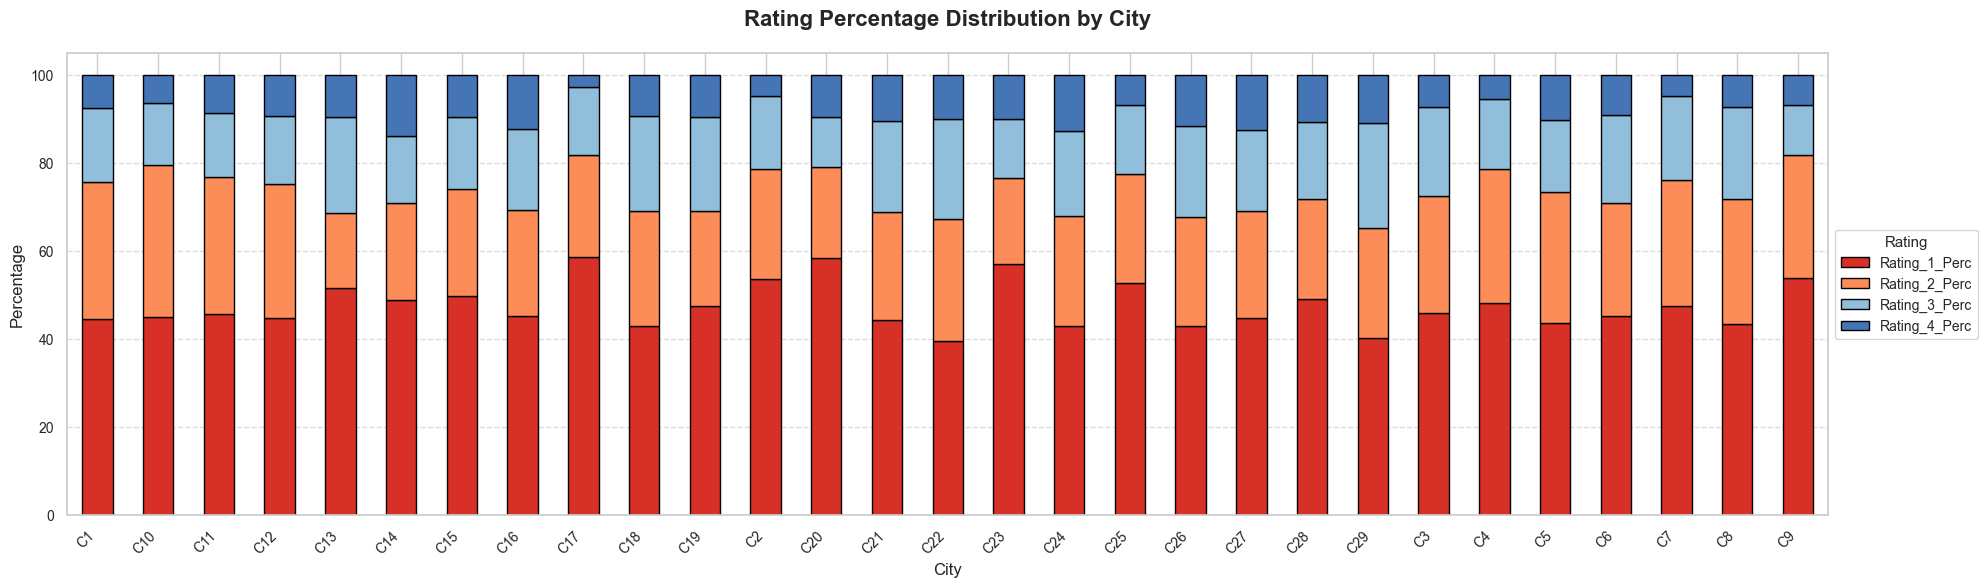

In [51]:
sns.set_style("whitegrid")

palette = ["#d73027", "#fc8d59", "#91bfdb", "#4575b4"] 

fig, ax = plt.subplots(figsize=(20, 6))

rating_df.set_index("City")[["Rating_1_Perc", "Rating_2_Perc", "Rating_3_Perc", "Rating_4_Perc"]].plot(
    kind="bar",
    stacked=True,
    ax=ax,
    color=palette,
    edgecolor="black"
)

ax.set_title("Rating Percentage Distribution by City", fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel("City", fontsize=12)
ax.set_ylabel("Percentage", fontsize=12)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

ax.yaxis.grid(True, linestyle="--", alpha=0.7)

ax.legend(title="Rating", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=10)

plt.tight_layout()
plt.show()

### **Observations**

* **Rating 1** (lowest rating) consistently dominates across all cities, contributing to over **40â€“55%** of the driver ratings, indicating performance concerns are widespread.
* Cities like **C17, C2, and C20** have the **highest proportion of Rating 1**, suggesting more drivers with lower performance in these areas.
* **C12 and C13** show relatively **better distributions**, with a higher share of **Ratings 3 and 4**, indicating better-performing drivers.
* **Rating 4** (best rating) stays the **least common** across most cities, rarely exceeding 10%, highlighting a general scarcity of top-rated drivers.
* **Balanced distributions** are observed in cities like **C13 and C19**, where mid-tier ratings (2 and 3) are more prominent than extreme values.

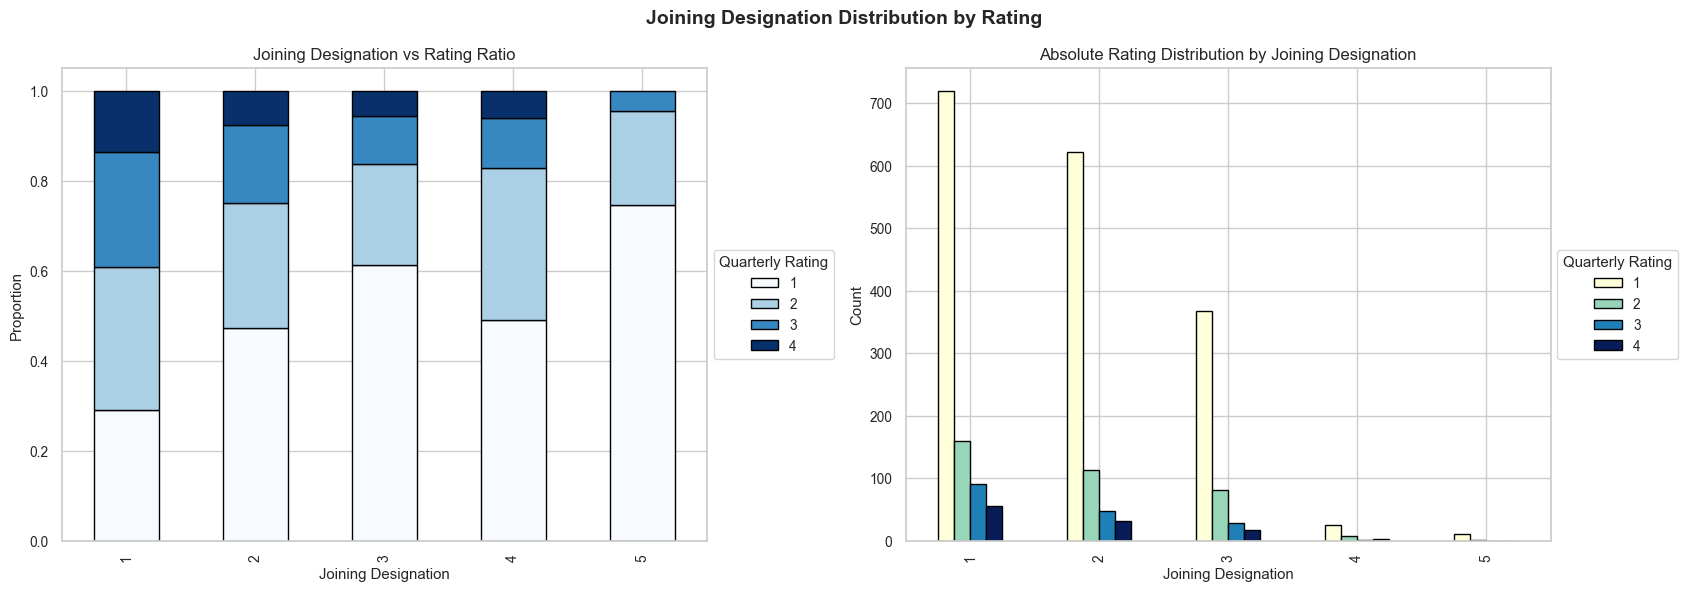

In [52]:
sns.set_style("whitegrid")

rating_counts = merged_df.groupby("Joining_Designation")["Quarterly_Rating"].value_counts().unstack().fillna(0)

rating_ratios = pd.crosstab(
    df["Joining Designation"],
    df["Quarterly Rating"],
    normalize="index"
)

fig, ax = plt.subplots(1, 2, figsize=(17, 6))

rating_ratios.plot(
    kind="bar",
    stacked=True,
    cmap="Blues",
    edgecolor="black",
    ax=ax[0]
)
ax[0].set_title("Joining Designation vs Rating Ratio", fontsize=12)
ax[0].set_ylabel("Proportion")
ax[0].set_xlabel("Joining Designation")
ax[0].legend(
    title="Quarterly Rating",
    bbox_to_anchor=(1, 0.5),
    loc="center left"
)

rating_counts.plot(
    kind="bar",
    stacked=False,
    cmap="YlGnBu",
    edgecolor="black",
    ax=ax[1]
)
ax[1].set_title("Absolute Rating Distribution by Joining Designation", fontsize=12)
ax[1].set_ylabel("Count")
ax[1].set_xlabel("Joining Designation")
ax[1].legend(
    title="Quarterly Rating",
    bbox_to_anchor=(1, 0.5),
    loc="center left"
)

plt.suptitle("Joining Designation Distribution by Rating", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


### **Observations**

* **Lower Joining Designations (1 and 2)** have a **higher proportion of drivers** with better ratings (Ratings 3 and 4), suggesting better performance or retention.
* **Designation 1** shows the most balanced spread, with a notable share of **Rating 2 and Rating 3**, and the **highest count overall**.
* As **Joining Designation increases (3 to 5)**, there's a **sharp rise in Rating 1 proportion**, indicating **poorer performance** among higher-designation joiners.
* **Designation 5** has **more than 70% of drivers** rated as **Rating 1**, and almost **no presence** in Ratings 3 and 4.
* The **absolute counts** confirm that **Designation 1 and 2** dominate in volume, with hundreds of drivers, while higher designations are fewer but tend to underperform.

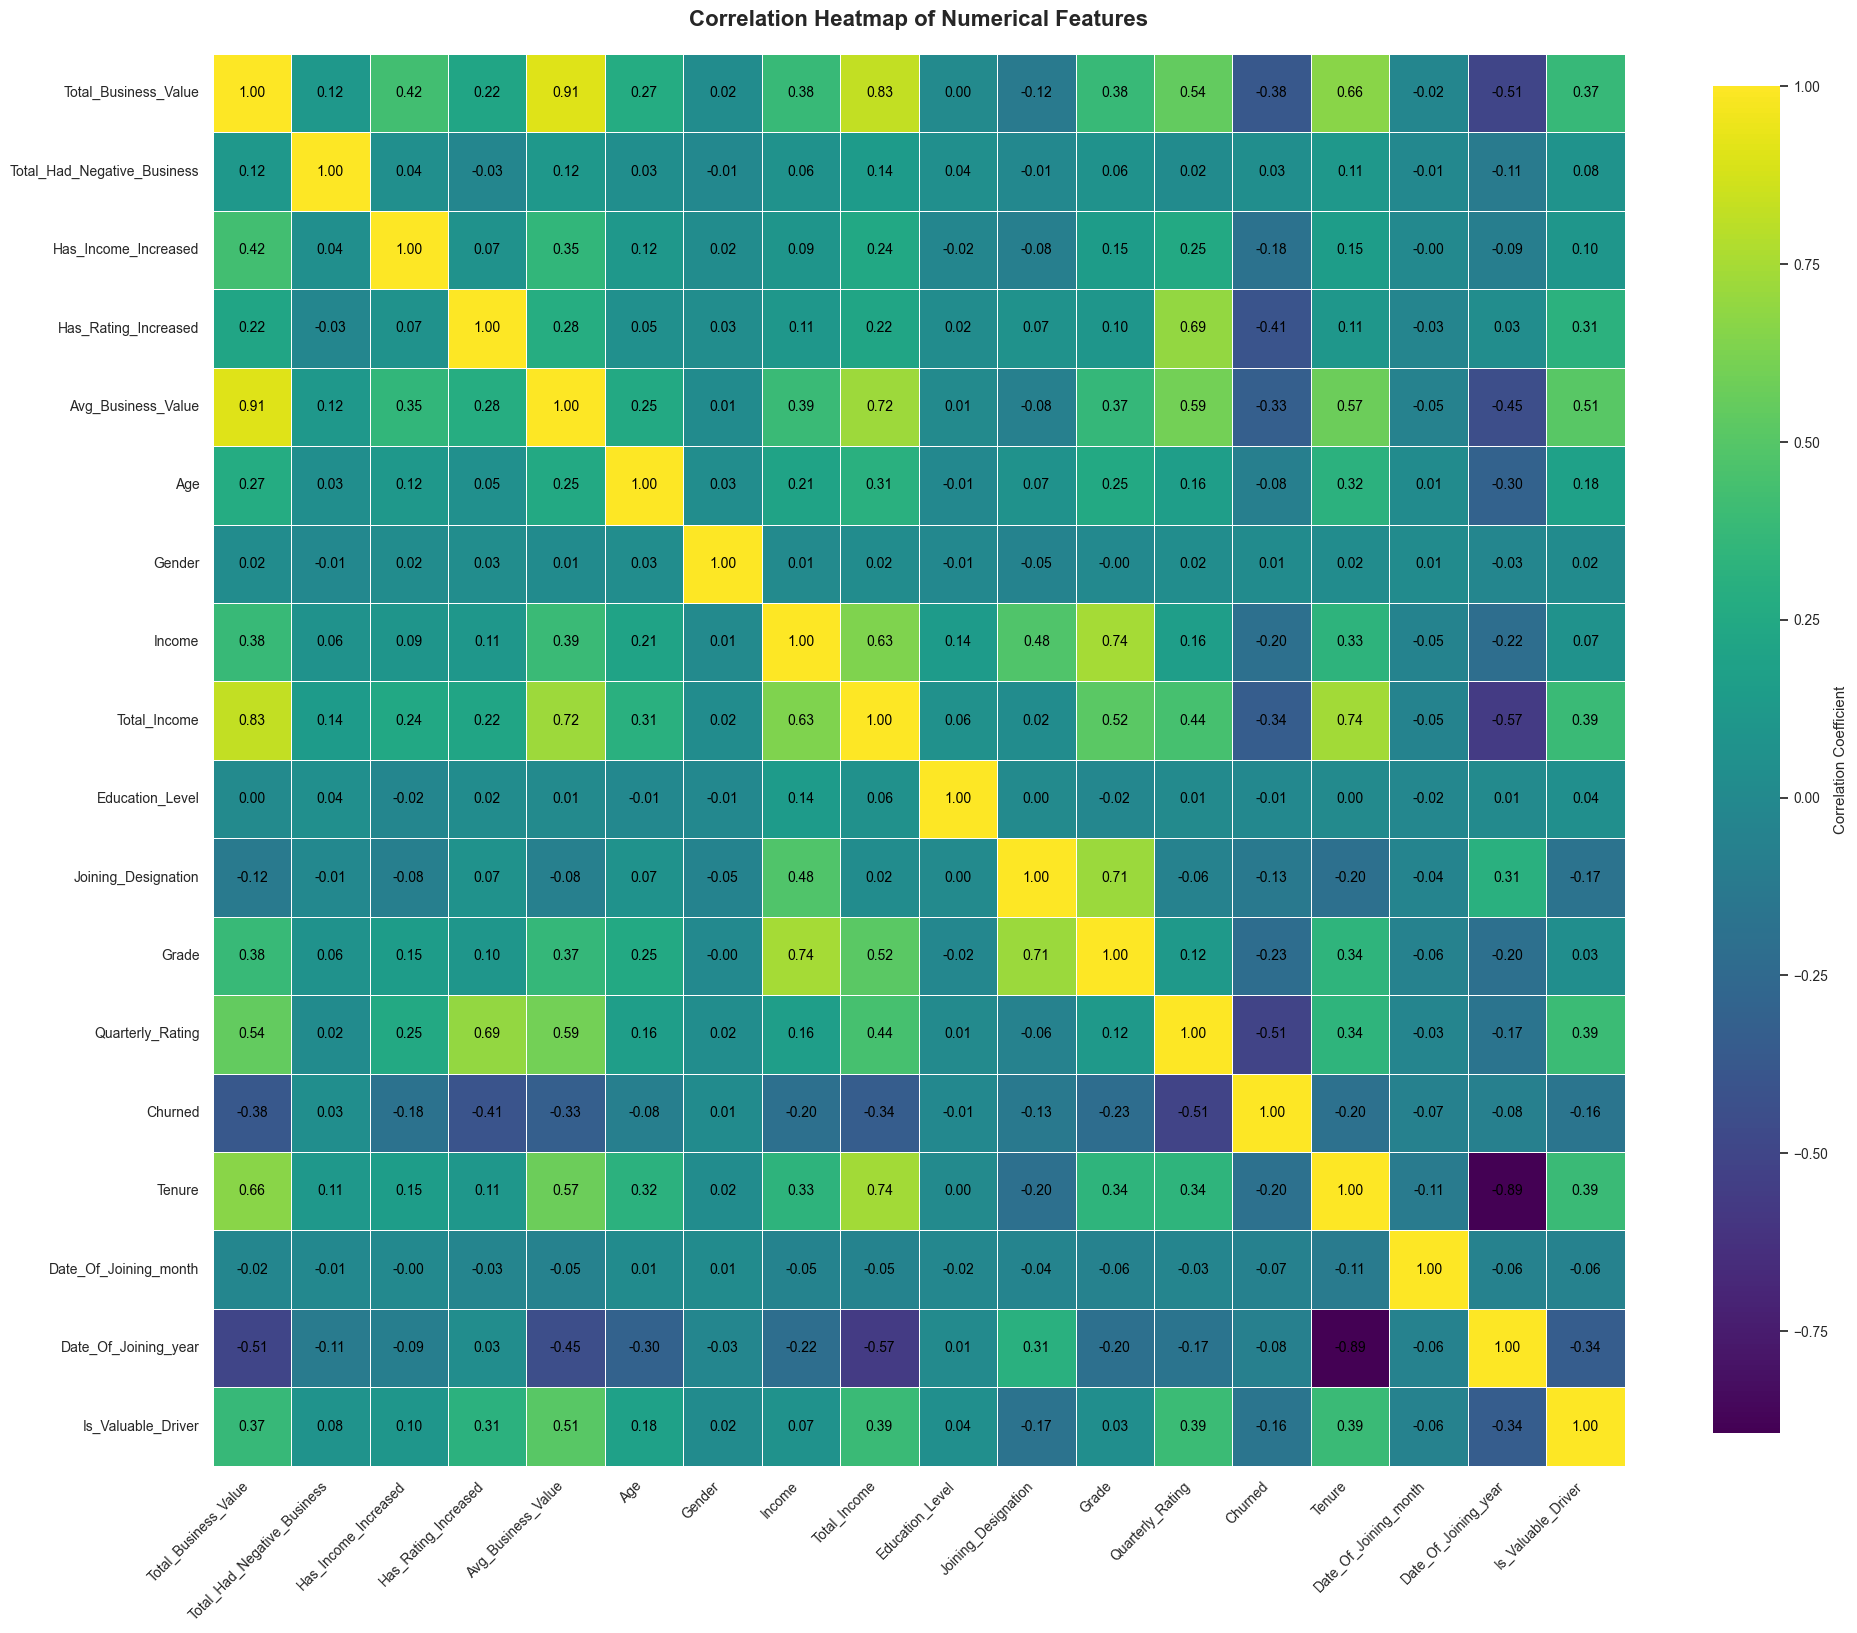

In [53]:
merged_df_corr = merged_df.select_dtypes(include=[np.number]).drop("Driver_ID", axis=1).corr()

plt.figure(figsize=(20, 18))

sns.heatmap(
    merged_df_corr,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    linewidths=0.5,
    linecolor="white",
    square=True,
    cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"},
    annot_kws={"fontsize": 10, "color": "black"}
)

plt.title("Correlation Heatmap of Numerical Features", fontsize=16, fontweight="bold", pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.tight_layout()
plt.show()

### **Observations**

* **Strong Positive Correlations:**

  * `Total_Business_Value` has a **very high correlation** with:

    * `Avg_Business_Value` (**0.91**)
    * `Total_Income` (**0.83**)
    * `Grade` (**0.83**)
    * `Quarterly_Rating` (**0.54**)
  * `Total_Income` is highly correlated with:

    * `Income` (**0.74**)
    * `Grade` (**0.74**)
    * `Tenure` (**0.74**)

* **Key Indicators of High Performance:**

  * `Quarterly_Rating` correlates positively with:

    * `Has_Rating_Increased` (**0.65**)
    * `Avg_Business_Value` (**0.59**)
    * `Grade` (**0.44**)
    * `Total_Business_Value` (**0.54**)

* **Indicators of Churn:**

  * `Churned` has a **moderate negative correlation** with:

    * `Tenure` (**-0.43**)
    * `Quarterly_Rating` (**-0.51**)
    * `Total_Business_Value` (**-0.38**)
    * `Is_Valuable_Driver` (**-0.34**)
    * `Date_Of_Joining_year` (**-0.57**) â†’ More recent joiners churn more.

* **Interesting Observations:**

  * `Is_Valuable_Driver` is positively associated with:

    * `Quarterly_Rating` (**0.39**)
    * `Tenure` (**0.39**)
    * `Total_Income` (**0.39**)
    * `Total_Business_Value` (**0.37**)

* **Low or No Correlation:**

  * `Gender`, `Education_Level`, and `Age` have weak or negligible correlations with most performance or value indicators.

In [54]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    precision_recall_curve,
    roc_curve,
    accuracy_score,
    f1_score,
    average_precision_score,
    precision_score,
    recall_score
)

import joblib

### **Handling Class Imbalance with SMOTE**

In [55]:
merged_df.drop(columns=['Date_Of_Joining','Last_Reporting_Month','Last_Working_Date'], inplace=True)

X = merged_df.drop(columns='Churned')
y = merged_df['Churned']

le = LabelEncoder()
X['City'] = le.fit_transform(X['City'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("After SMOTE:")
print(pd.Series(y_train_smote).value_counts())

After SMOTE:
Churned
0    1292
1    1292
Name: count, dtype: int64


In [56]:
train_data = pd.concat([pd.DataFrame(X_train_smote, columns=X.columns),
                      pd.Series(y_train_smote, name='Churned')],
                     axis=1)

train_data['City'] = le.inverse_transform(train_data['City'].astype(int))
train_data

Driver_ID  Total_Business_Value  Total_Had_Negative_Business  \
0          2627                     0                            0   
1          1730                     0                            0   
2          2499                     0                            0   
3          2200              29040450                            0   
4           539                     0                            0   
...         ...                   ...                          ...   
2579       1019                     0                            0   
2580        795                     0                            0   
2581       2201               1721674                            0   
2582       1223               1285183                            0   
2583       2408               1734907                            0   

      Has_Income_Increased  Has_Rating_Increased  Avg_Business_Value  \
0                        0                     0                   0   
1                        0                     0                   0   
2                        0                     0                   0   
3                        0                     1             1210018   
4                        0                     0                   0   
...                    ...                   ...                 ...   
2579                     0                     0                   0   
2580                     0                     0                   0   
2581                     0                     0              182301   
2582                     0                     1              206646   
2583                     0                     1              296295   

            Age    Gender  Income  Total_Income  ...  City  \
0     34.000000  1.000000  104058        208116  ...    C7   
1     42.000000  0.000000   51579         51579  ...    C9   
2     27.000000  0.000000   75458        226374  ...   C17   
3     35.000000  0.000000   69756       1674144  ...   C15   
4     36.000000  0.000000  109296        109296  ...   C24   
...         ...       ...     ...           ...  ...   ...   
2579  34.695618  0.652191  107889        215778  ...   C26   
2580  37.068097  0.321984   52592         52592  ...    C7   
2581  31.171340  0.434268   47769        429668  ...   C27   
2582  37.000000  0.732972   47923        299856  ...    C2   
2583  34.878630  0.121370   57771        336215  ...    C7   

     Joining_Designation  Grade  Quarterly_Rating  Tenure  \
0                      3      3                 1     203   
1                      1      1                 1     524   
2                      2      2                 1      84   
3                      1      3                 3    1654   
4                      2      3                 1     943   
...                  ...    ...               ...     ...   
2579                   3      3                 1     315   
2580                   2      2                 1      46   
2581                   1      1                 1     333   
2582                   1      1                 2     129   
2583                   2      2                 2     187   

      Date_Of_Joining_month  Date_Of_Joining_year  Is_Valuable_Driver  \
0                         6                  2020                   0   
1                         5                  2018                   0   
2                         6                  2019                   0   
3                         6                  2016                   1   
4                         6                  2016                   0   
...                     ...                   ...                 ...   
2579                      2                  2020                   0   
2580                     11                  2020                   0   
2581                      6                  2019                   1   
2582                      8                  2020                   1   
2583               

In [57]:
test_data = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)
test_data['City'] = le.inverse_transform(test_data['City'].astype(int))
test_data

Driver_ID  Total_Business_Value  Total_Had_Negative_Business  \
0         1103                     0                            0   
1          899                307100                            0   
2           46                338290                            0   
3          559               1722620                            0   
4          358               5175130                            0   
..         ...                   ...                          ...   
472       2269                     0                            0   
473       2386               5303160                            0   
474       2527               1450030                            0   
475        228              10390120                            0   
476       1612              12641110                            1   

     Has_Income_Increased  Has_Rating_Increased  Avg_Business_Value   Age  \
0                       0                     0                   0  26.0   
1                       0                     0              102366  29.0   
2                       0                     0              112763  36.0   
3                       0                     1              344524  41.0   
4                       0                     0              369652  40.0   
..                    ...                   ...                 ...   ...   
472                     0                     0                   0  33.0   
473                     0                     1              589240  27.0   
474                     0                     0              131820  25.0   
475                     0                     0              611183  45.0   
476                     0                     0              526712  35.0   

     Gender  Income  Total_Income  ...  City Joining_Designation  Grade  \
0       0.0   40318        201590  ...    C1                   1      1   
1       0.0   28565         85695  ...   C20                   1      1   
2       1.0   42171        126513  ...   C25                   1      1   
3       0.0   44342        221710  ...   C27                   1      1   
4       1.0  117830       1649620  ...   C26                   3      3   
..      ...     ...           ...  ...   ...                 ...    ...   
472     0.0   46043        276258  ...    C8                   3      3   
473     0.0   48747        438723  ...   C21                   1      1   
474     0.0   16206        178266  ...    C5                   1      1   
475     0.0   53385        907545  ...    C6                   1      1   
476     0.0   69697       1672728  ...   C27                   2      2   

     Quarterly_Rating  Tenure  Date_Of_Joining_month  Date_Of_Joining_year  \
0                   1     143                      7                  2020   
1                   1     272                      6                  2018   
2                   1     122                     10                  2018   
3                   3     139                      8                  2020   
4                   1     429                     10                  2019   
..                ...     ...                    ...                   ...   
472                 1     154                      4                  2020   
473                 3     256                      4                  2020   
474                 1     405                     10                  2019   
475                 1    1259                      7                  2016   
476                 1     637                     10                  2018   

     Is_Valuable_Driver  Churned_str Churned  
0                     0            1       1  
1                     1            1       1  
2                     1            1       1  
3                     1            0       0  
4                     1            0       0  
..                  ...          ...     ...  
472                   0            1       1  
473                   1            0 

In [58]:
train_data.shape

(2584, 21)

### **Random Forest Classifier**

In [59]:
categorical_cols = ['City']

numerical_cols = [
    'Total_Business_Value', 'Total_Had_Negative_Business', 'Has_Income_Increased',
    'Has_Rating_Increased', 'Avg_Business_Value', 'Age', 'Gender', 'Income',
    'Total_Income', 'Education_Level', 'Joining_Designation', 'Grade',
    'Quarterly_Rating', 'Tenure', 'Date_Of_Joining_month', 'Date_Of_Joining_year',
    'Is_Valuable_Driver'
]

feature_columns = categorical_cols + numerical_cols

X_train_rf = train_data[feature_columns]
y_train_rf = train_data['Churned']
X_test_rf = test_data[feature_columns]
y_test_rf = test_data['Churned']

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
    ('num', StandardScaler(), numerical_cols)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

param_grid = param_grid = {
    "classifier__n_estimators": [200, 250, 300, 350, 400],
    "classifier__max_depth": [5, 10, 15, 20, 25, 30]
}

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_rf, y_train_rf)
y_pred_rf = grid.predict(X_test_rf)

joblib.dump(grid.best_estimator_, "S:/Project_3/models/rf_model.pkl")

best_rf = joblib.load("S:/Project_3/models/rf_model.pkl")
rf_model = best_rf.named_steps['classifier']
print("NumTrees:", rf_model.n_estimators, "MaxDepth:", rf_model.max_depth)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
NumTrees: 250 MaxDepth: 25


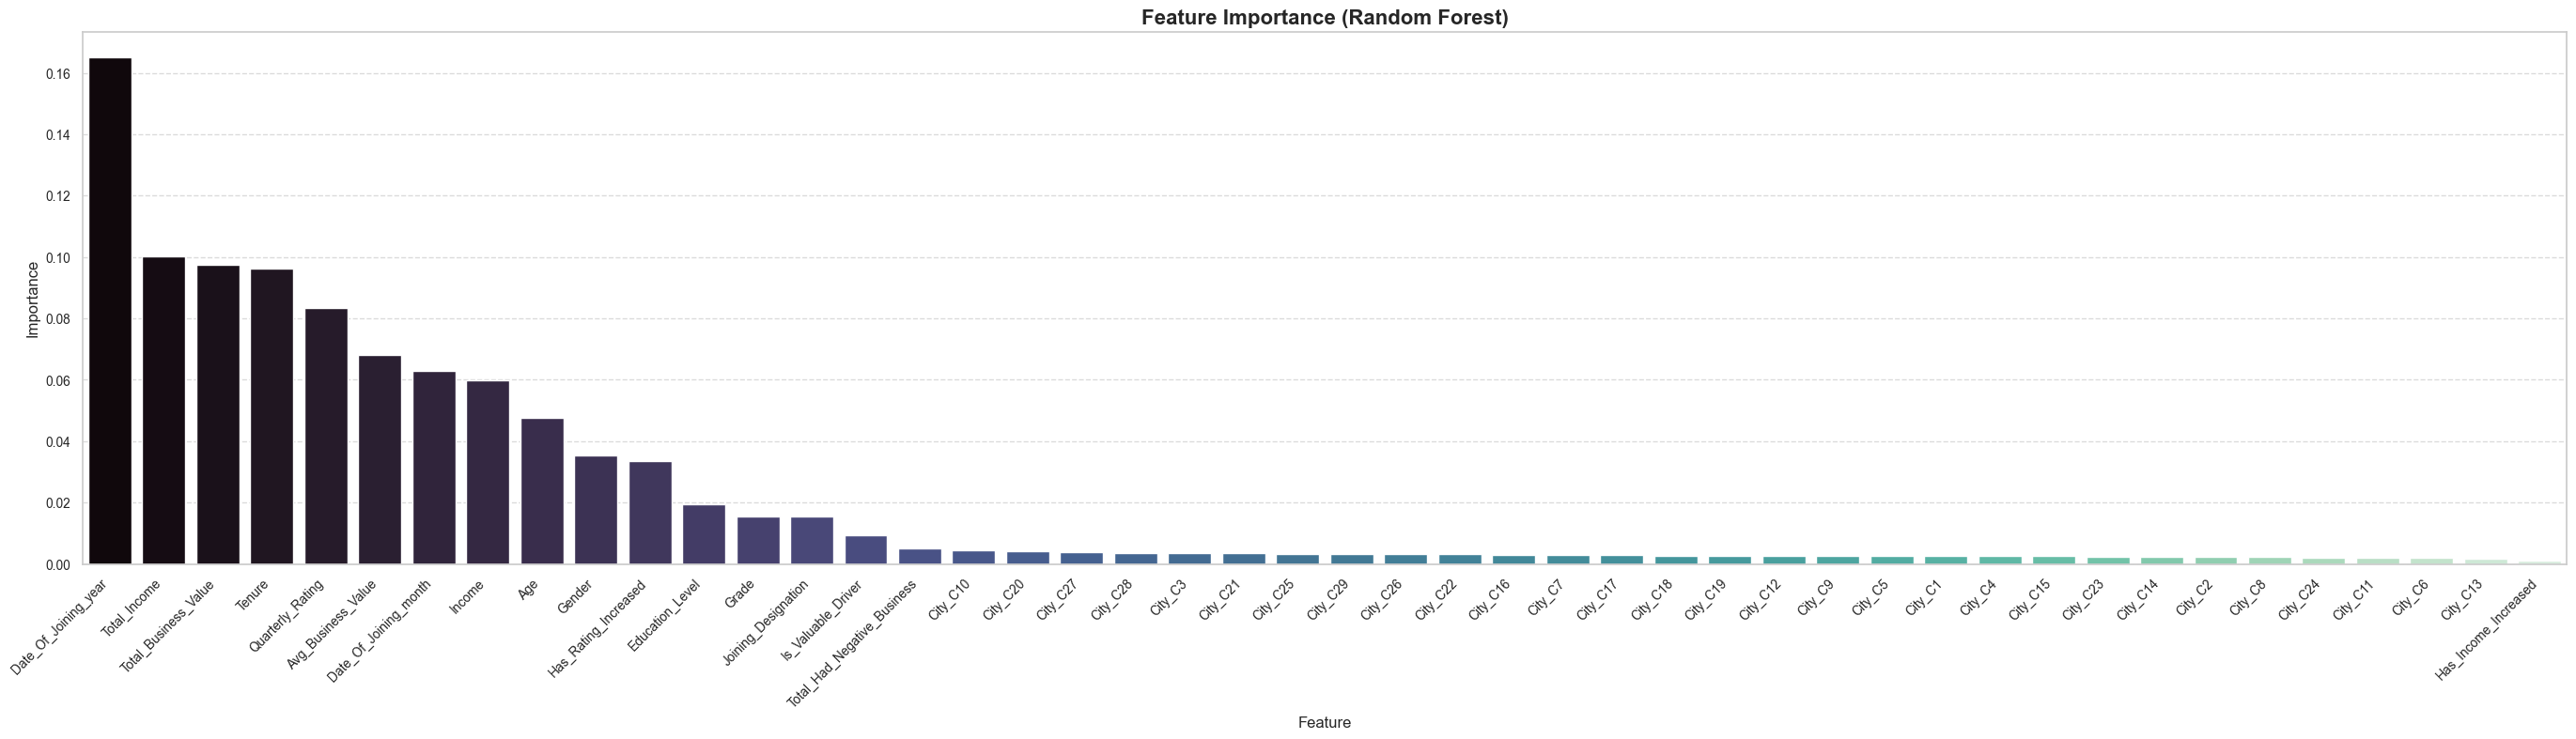

In [60]:
preprocessor = best_rf.named_steps['preprocessor']
rf_model = best_rf.named_steps['classifier']

cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
num_features = numerical_cols
all_features = np.concatenate([cat_features, num_features])

importances = rf_model.feature_importances_

feat_imp_df = pd.DataFrame({
    "Feature": all_features,
    "Importance": importances
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(max(10, len(all_features) * 0.6), 8))
sns.barplot(data=feat_imp_df, x="Feature", y="Importance", palette="mako")

plt.title("Feature Importance (Random Forest)", fontsize=16, weight="bold")
plt.xlabel("Feature", fontsize=12)
plt.ylabel("Importance", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

### **Observations**
- We can see that Joining Year is the most important feature followed by Total Income.

In [61]:
y_pred_rf = best_rf.predict(X_test_rf)
y_prob_rf = best_rf.predict_proba(X_test_rf)[:, 1] 
y_true_rf = y_test_rf

In [62]:
def print_metrics(y_true, y_pred, y_prob):
    print(classification_report(y_true, y_pred))
    print("Accuracy: ", accuracy_score(y_true, y_pred))
    print("F1 Score: ", f1_score(y_true, y_pred))
    print("AUC: ", roc_auc_score(y_true, y_prob))

def get_best_threshold(y_true, y_prob):
    thresholds = np.arange(0.0, 1.0, 0.01)

    precisions = []
    recalls = []
    f1s = []

    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        precisions.append(precision_score(y_true, y_pred))
        recalls.append(recall_score(y_true, y_pred))
        f1s.append(f1_score(y_true, y_pred))

    best_index = np.argmax(f1s)
    best_threshold = thresholds[best_index]

    print(f'Best threshold: {best_threshold:.2f}')
    print(f'Precision at best threshold: {precisions[best_index]:.3f}')
    print(f'Recall at best threshold: {recalls[best_index]:.3f}')
    print(f'F1 score at best threshold: {f1s[best_index]:.3f}')

    return best_threshold

print_metrics(y_true_rf, y_pred_rf, y_prob_rf)

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       153
           1       0.94      0.90      0.92       324

    accuracy                           0.90       477
   macro avg       0.88      0.89      0.88       477
weighted avg       0.90      0.90      0.90       477

Accuracy:  0.8951781970649895
F1 Score:  0.9213836477987422
AUC:  0.9641934963285727


In [63]:
best_threshold = get_best_threshold(y_true_rf, y_prob_rf)
y_pred_thresh = (y_prob_rf >= best_threshold).astype(int)

Best threshold: 0.45
Precision at best threshold: 0.933
Recall at best threshold: 0.938
F1 score at best threshold: 0.935


In [64]:
print_metrics(y_true_rf, y_pred_thresh, y_prob_rf)

              precision    recall  f1-score   support

           0       0.87      0.86      0.86       153
           1       0.93      0.94      0.94       324

    accuracy                           0.91       477
   macro avg       0.90      0.90      0.90       477
weighted avg       0.91      0.91      0.91       477

Accuracy:  0.9119496855345912
F1 Score:  0.9353846153846154
AUC:  0.9641934963285727


### **Observations**

- With these new adjustment the, the f1 score increased by 1.4%.

### **Insights**
- A Recall of 94% means that out of all churned drivers, the model was correct 94% of times
- A precision of 93% means that out of all churned drivers predicted, 93% were actually churned.

In [65]:
def plot_two_evaluation_plots(y_true, y_prob):

    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    thresholds = np.append(thresholds, 1.0)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_score = roc_auc_score(y_true, y_prob)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=100, gridspec_kw={'wspace': 0.25})

    axs[0].plot(thresholds, precision, label="Precision", color="green")
    axs[0].plot(thresholds, recall, label="Recall", color="orange")
    axs[0].set_xlabel("Threshold")
    axs[0].set_ylabel("Score")
    axs[0].set_title("Precision & Recall vs Threshold")
    axs[0].grid(True, linestyle="--", alpha=0.5)

    axs[1].plot(fpr, tpr, label=f"AUC = {auc_score:.2f}", color="blue")
    axs[1].plot([0, 1], [0, 1], 'k--', lw=1)
    axs[1].set_xlabel("False Positive Rate")
    axs[1].set_ylabel("True Positive Rate")
    axs[1].set_title("ROC Curve")
    axs[1].grid(True, linestyle="--", alpha=0.5)

    handles0, labels0 = axs[0].get_legend_handles_labels()
    handles1, labels1 = axs[1].get_legend_handles_labels()

    fig.legend(handles0 + handles1, labels0 + labels1,
               loc='center left', bbox_to_anchor=(0.9, 0.5),
               frameon=False, fontsize=11)

    plt.tight_layout(rect=[0, 0, 1.02, 1])
    plt.show()

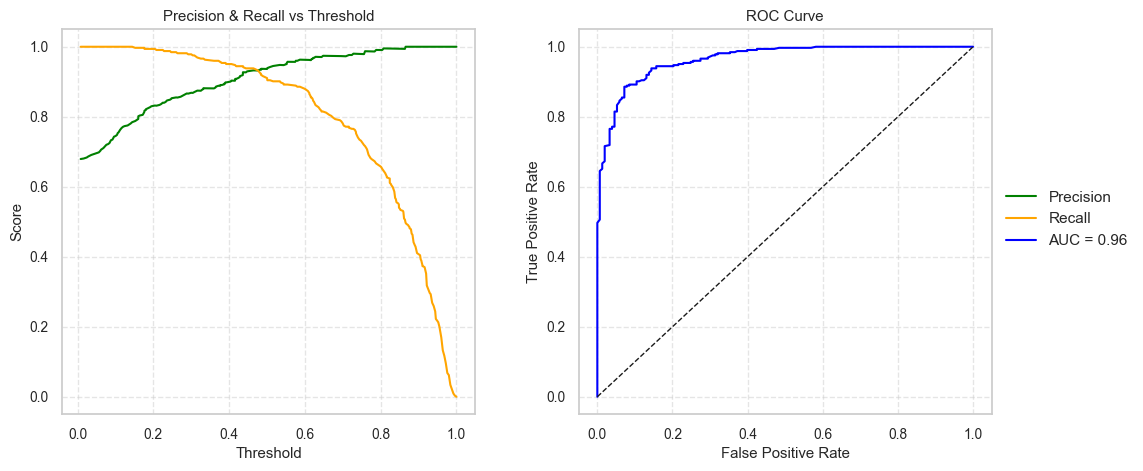

In [66]:
plot_two_evaluation_plots(y_true_rf, y_prob_rf)

In [67]:
def plot_pr_and_confusion_matrix(y_true, y_prob, y_pred, normalize='true'):

    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    cm = confusion_matrix(y_true, y_pred, normalize=normalize, labels=[0, 1])

    fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'wspace': 0.25})

    axs[0].plot(recall, precision, label='Precision-Recall', color='purple')
    axs[0].set_xlabel("Recall")
    axs[0].set_ylabel("Precision")
    axs[0].set_title("Precision-Recall Curve")
    axs[0].grid(True, linestyle="--", alpha=0.5)

    sns.heatmap(cm, annot=True, cmap="viridis", fmt='.2f', 
                xticklabels=[0, 1], yticklabels=[0, 1], ax=axs[1])
    axs[1].set_title('Confusion Matrix')
    axs[1].set_xlabel('Predicted')
    axs[1].set_ylabel('Actual')

    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.9, 0.5), frameon=False, fontsize=11)

    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.show()

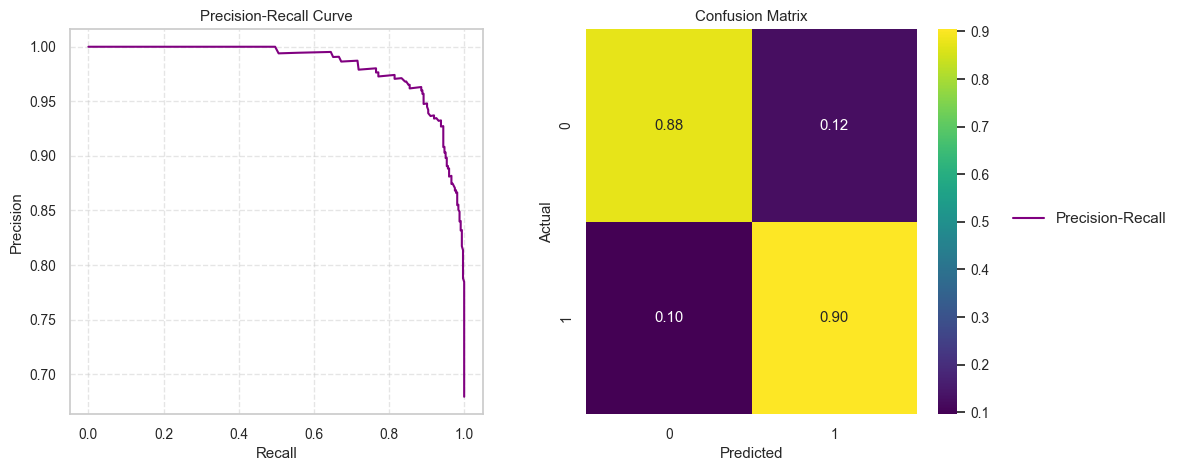

In [68]:
plot_pr_and_confusion_matrix(y_true_rf, y_prob_rf, y_pred_rf)

### **Observations**

- 88% of the actual negative cases (class 0) were correctly predicted by the model as not having churned.
- 12% of the actual negative cases (class 0) were incorrectly predicted by the model as having churned.
- 10% of the actual positive cases (class 1) were incorrectly predicted by the model as not having churned.
- 90% of the actual positive cases (class 1) were correctly predicted by the model as having churned.

### **Gradient Boosting Classifier**

In [69]:
categorical_cols = ['City']

numerical_cols = [
    'Total_Business_Value', 'Total_Had_Negative_Business', 'Has_Income_Increased',
    'Has_Rating_Increased', 'Avg_Business_Value', 'Age', 'Gender', 'Income',
    'Total_Income', 'Education_Level', 'Joining_Designation', 'Grade',
    'Quarterly_Rating', 'Tenure', 'Date_Of_Joining_month', 'Date_Of_Joining_year',
    'Is_Valuable_Driver'
]

feature_columns = categorical_cols + numerical_cols

X_train_gbt = train_data[feature_columns]
y_train_gbt = train_data['Churned']
X_test_gbt = test_data[feature_columns]
y_test_gbt = test_data['Churned']

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
    ('num', StandardScaler(), numerical_cols)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

maxDepth_values = np.random.choice(range(3, 10), size=4, replace=False)
stepSize_values = [0.1, 0.2, 0.3, 0.4]
maxIter_values = [30, 50, 100, 150, 200]

param_grid = {
    "classifier__max_depth": list(maxDepth_values),
    "classifier__learning_rate": stepSize_values,
    "classifier__n_estimators": maxIter_values
}

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train_gbt, y_train_gbt)

y_pred_gbt = grid.predict(X_test_gbt)
joblib.dump(grid.best_estimator_, "S:/Project_3/models/gb_model.pkl")

best_gb = joblib.load("S:/Project_3/models/gb_model.pkl")
gb_model = best_gb.named_steps['classifier']
print("Best MaxDepth:", gb_model.max_depth)
print("Best LearningRate:", gb_model.learning_rate)
print("Best NumEstimators:", gb_model.n_estimators)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


Best MaxDepth: 6
Best LearningRate: 0.3
Best NumEstimators: 200


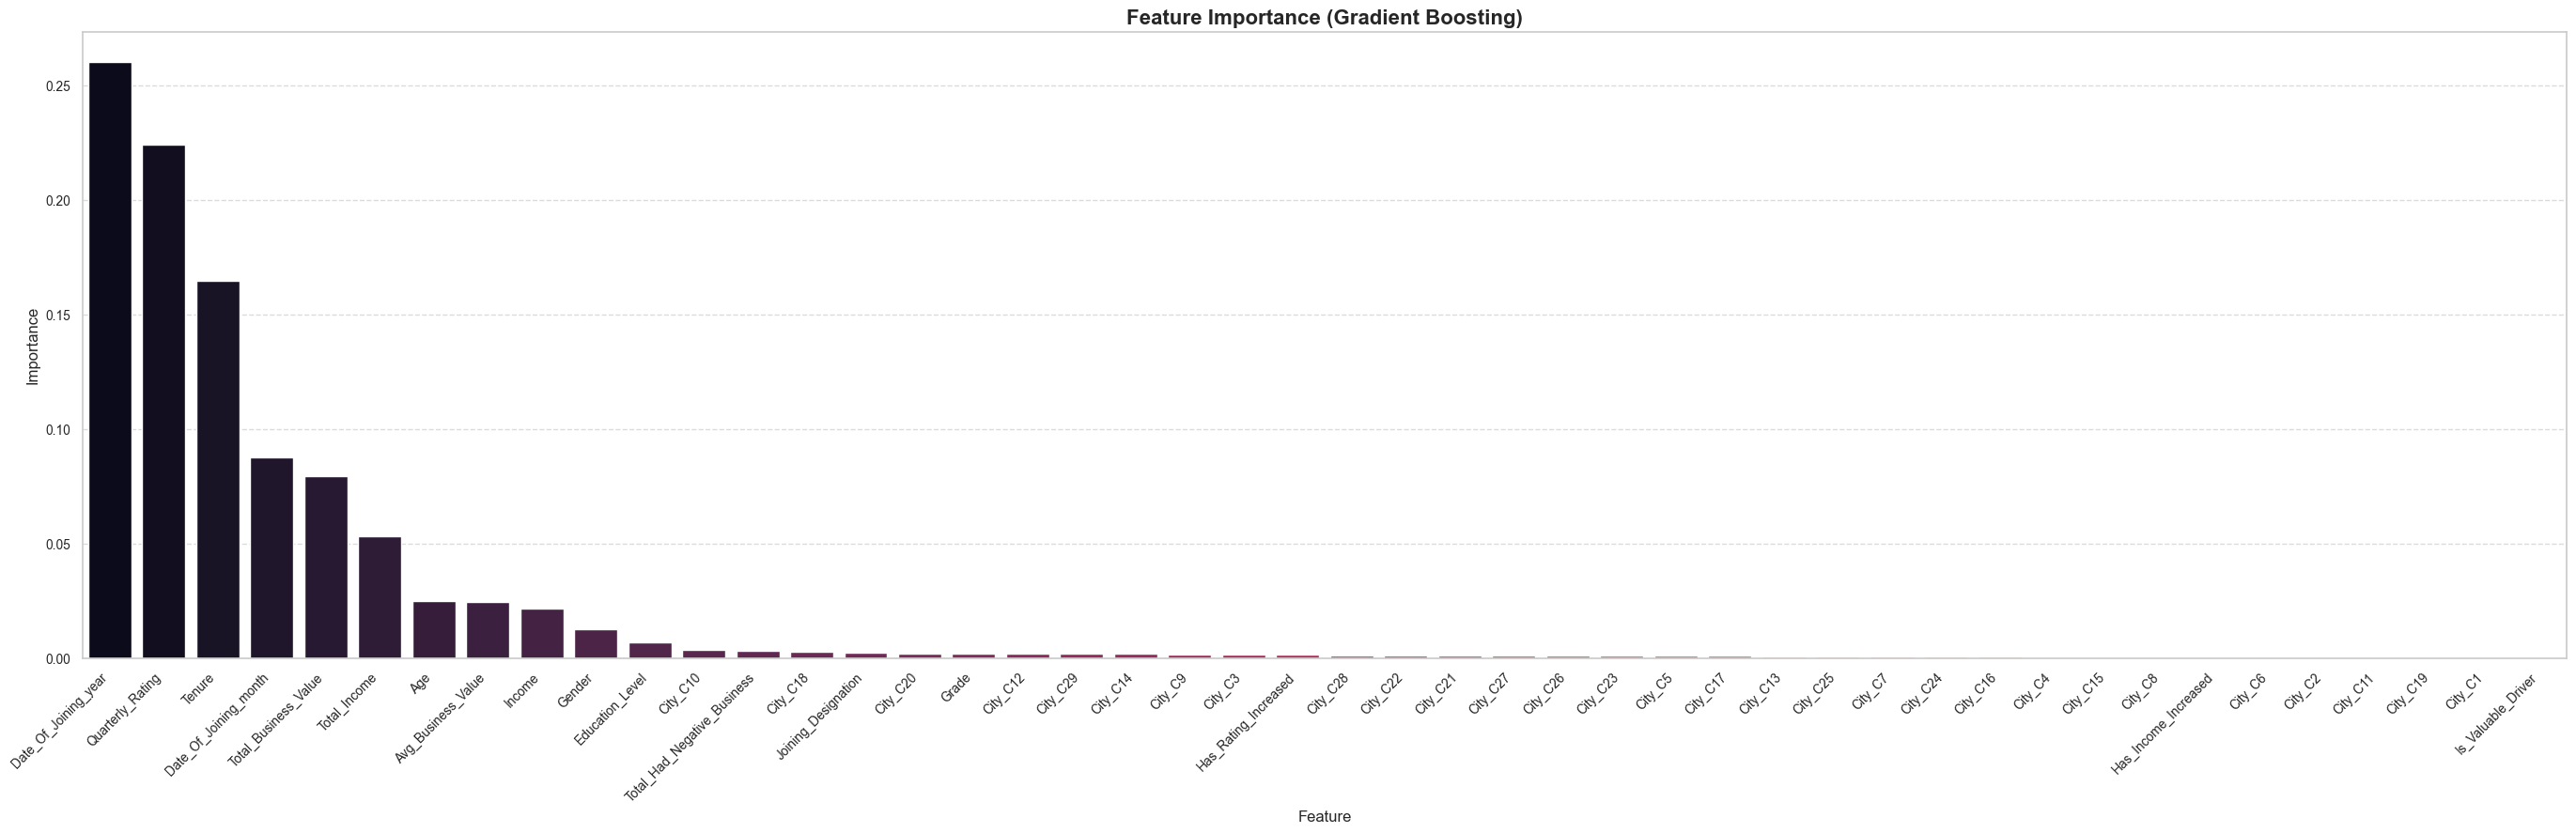

In [70]:
preprocessor = best_gb.named_steps['preprocessor']
gb_model = best_gb.named_steps['classifier']

cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
num_features = numerical_cols
all_features = np.concatenate([cat_features, num_features])

importances = gb_model.feature_importances_

feat_imp_df = pd.DataFrame({
    "Feature": all_features,
    "Importance": importances
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(max(10, len(all_features) * 0.6), 9))
sns.barplot(data=feat_imp_df, x="Feature", y="Importance", palette="rocket")

plt.title("Feature Importance (Gradient Boosting)", fontsize=16, weight="bold")
plt.xlabel("Feature", fontsize=12)
plt.ylabel("Importance", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

### **Observations**

- We can see that Joining Year is the most important feature followed by Quarterly Rating.

In [71]:
y_pred_gbt = best_gb.predict(X_test_gbt)
y_prob_gbt = gb_model.predict_proba(preprocessor.transform(X_test_gbt))[:, 1]
y_true_gbt = y_test_gbt

In [72]:
print_metrics(y_true_gbt, y_pred_gbt, y_prob_gbt)

              precision    recall  f1-score   support

           0       0.88      0.91      0.89       153
           1       0.96      0.94      0.95       324

    accuracy                           0.93       477
   macro avg       0.92      0.92      0.92       477
weighted avg       0.93      0.93      0.93       477

Accuracy:  0.9308176100628931
F1 Score:  0.9486780715396579
AUC:  0.9763576212377956


In [73]:
best_threshold = get_best_threshold(y_true_gbt, y_prob_gbt)
y_pred_thresh = (y_prob_gbt >= best_threshold).astype(int)

Best threshold: 0.27
Precision at best threshold: 0.954
Recall at best threshold: 0.957
F1 score at best threshold: 0.955


In [74]:
print_metrics(y_true_gbt, y_pred_thresh, y_prob_gbt)

              precision    recall  f1-score   support

           0       0.91      0.90      0.90       153
           1       0.95      0.96      0.96       324

    accuracy                           0.94       477
   macro avg       0.93      0.93      0.93       477
weighted avg       0.94      0.94      0.94       477

Accuracy:  0.939203354297694
F1 Score:  0.9553158705701078
AUC:  0.9763576212377956


### **Observations**

- With these new adjustment the, the f1 score increased by 0.7%.

### **Insights**
- A Recall of 96% means that out of all churned drivers, the model was correct 96% of times
- A precision of 95% means that out of all churned drivers predicted, 95% were actually churned.

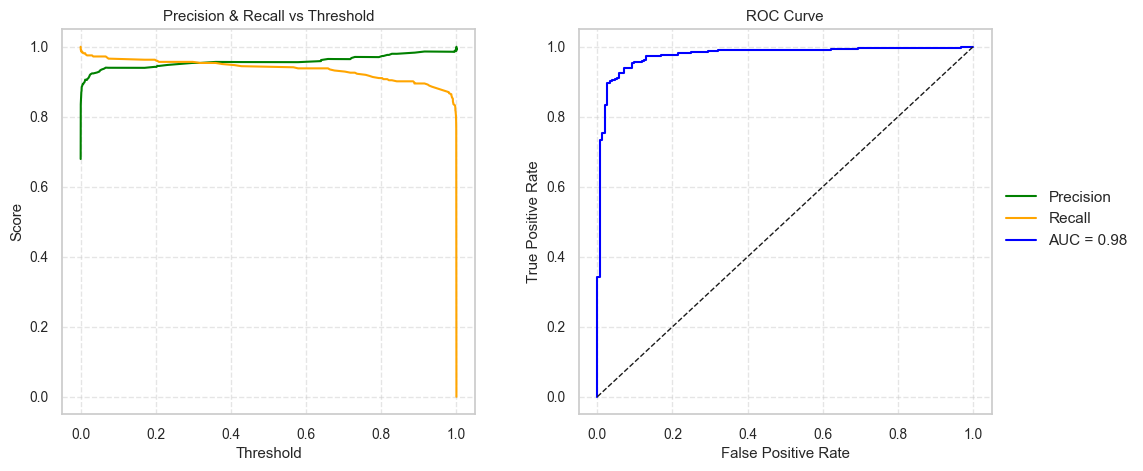

In [75]:
plot_two_evaluation_plots(y_true_gbt, y_prob_gbt)

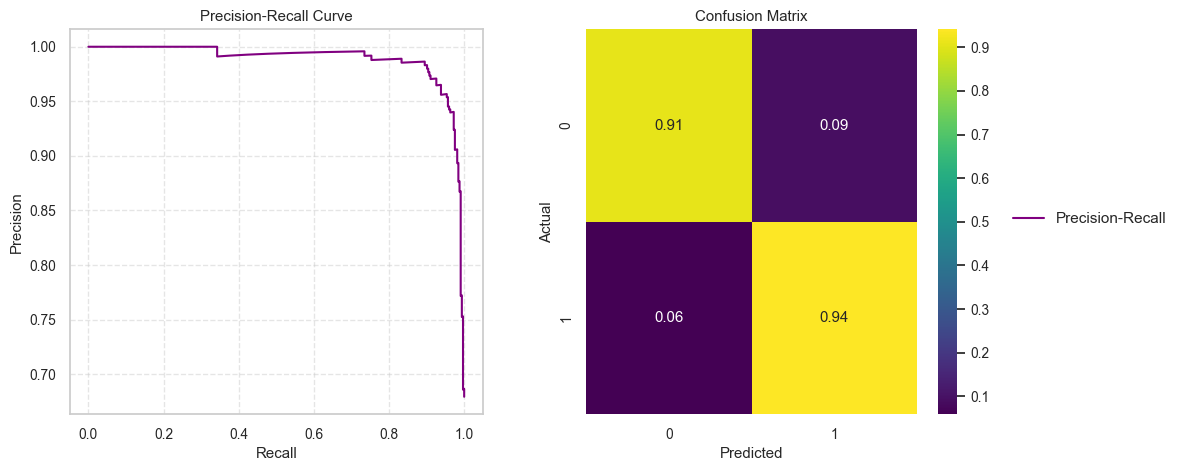

In [76]:
plot_pr_and_confusion_matrix(y_true_gbt, y_prob_gbt, y_pred_gbt)

### **Observations**

- 91% of the actual negative cases (class 0) were correctly predicted by the model as not having churned.
- 9% of the actual negative cases (class 0) were incorrectly predicted by the model as having churned.
- 6% of the actual positive cases (class 1) were incorrectly predicted by the model as not having churned.
- 94% of the actual positive cases (class 1) were correctly predicted by the model as having churned.

### **XGB Classifier**

In [77]:
categorical_cols = ['City']

numerical_cols = [
    'Total_Business_Value', 'Total_Had_Negative_Business', 'Has_Income_Increased',
    'Has_Rating_Increased', 'Avg_Business_Value', 'Age', 'Gender', 'Income',
    'Total_Income', 'Education_Level', 'Joining_Designation', 'Grade',
    'Quarterly_Rating', 'Tenure', 'Date_Of_Joining_month', 'Date_Of_Joining_year',
    'Is_Valuable_Driver'
]

feature_columns = categorical_cols + numerical_cols

X_train_xgb = train_data[feature_columns]
y_train_xgb = train_data['Churned']
X_test_xgb = test_data[feature_columns]
y_test_xgb = test_data['Churned']

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
    ('num', StandardScaler(), numerical_cols)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

param_grid = {
    "classifier__max_depth": [3, 5, 7, 10],
    "classifier__learning_rate": [0.1, 0.2, 0.3],
    "classifier__n_estimators": [150, 200, 250],
    "classifier__subsample": [0.8, 1.0]
}

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train_xgb, y_train_xgb)

y_pred_xgb = grid.predict(X_test_xgb)
joblib.dump(grid.best_estimator_, "S:/Project_3/models/xgb_model.pkl")

best_xgb = joblib.load("S:/Project_3/models/xgb_model.pkl")
xgb_model = best_xgb.named_steps['classifier']

print("Best MaxDepth:", xgb_model.max_depth)
print("Best LearningRate:", xgb_model.learning_rate)
print("Best NumEstimators:", xgb_model.n_estimators)
print("Best Subsample:", xgb_model.subsample)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


Best MaxDepth: 10
Best LearningRate: 0.1
Best NumEstimators: 200
Best Subsample: 0.8


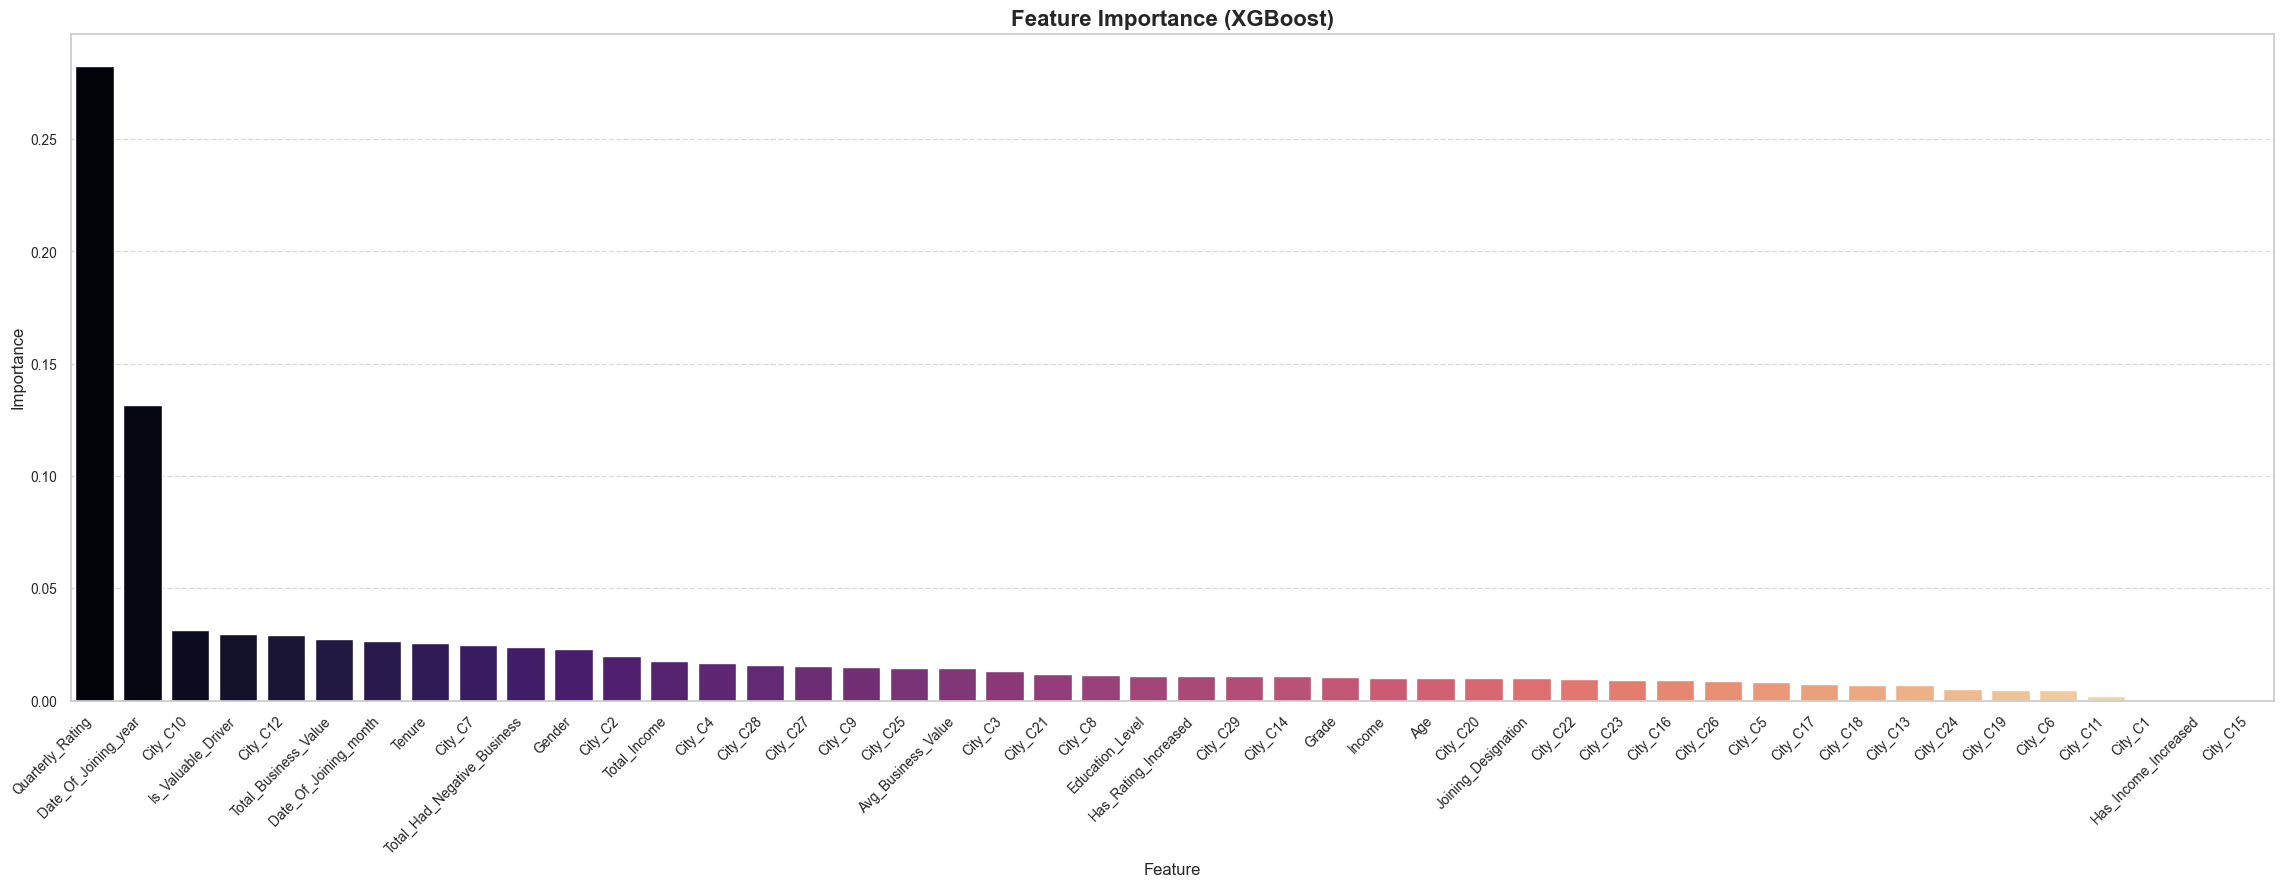

In [78]:
preprocessor = best_xgb.named_steps['preprocessor']
xgb_model = best_xgb.named_steps['classifier']

cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
num_features = numerical_cols
all_features = np.concatenate([cat_features, num_features])

importances = xgb_model.feature_importances_

feat_imp_df = pd.DataFrame({
    "Feature": all_features,
    "Importance": importances
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(max(12, len(all_features) * 0.5), 9))
sns.barplot(data=feat_imp_df, x="Feature", y="Importance", palette="magma")

plt.title("Feature Importance (XGBoost)", fontsize=16, weight="bold")
plt.xlabel("Feature", fontsize=12)
plt.ylabel("Importance", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

### **Observations**
- We can see that Quarterly Rating is the most important feature followed by Joining Year.

In [79]:
y_pred_xgb = best_xgb.predict(X_test_xgb)
y_prob_xgb = xgb_model.predict_proba(preprocessor.transform(X_test_xgb))[:, 1]
y_true_xgb = y_test_xgb

In [80]:
print_metrics(y_true_xgb, y_pred_xgb, y_prob_xgb)

              precision    recall  f1-score   support

           0       0.87      0.92      0.90       153
           1       0.96      0.94      0.95       324

    accuracy                           0.93       477
   macro avg       0.92      0.93      0.92       477
weighted avg       0.93      0.93      0.93       477

Accuracy:  0.9308176100628931
F1 Score:  0.9483568075117371
AUC:  0.9749051884128137


In [81]:
best_threshold = get_best_threshold(y_true_xgb, y_prob_xgb)
y_pred_thresh = (y_prob_xgb >= best_threshold).astype(int)

Best threshold: 0.37
Precision at best threshold: 0.959
Recall at best threshold: 0.941
F1 score at best threshold: 0.950


In [82]:
print_metrics(y_true_xgb, y_pred_thresh, y_prob_xgb)

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       153
           1       0.96      0.94      0.95       324

    accuracy                           0.93       477
   macro avg       0.92      0.93      0.92       477
weighted avg       0.93      0.93      0.93       477

Accuracy:  0.9329140461215933
F1 Score:  0.9501557632398754
AUC:  0.9749051884128137


### **Observations**

- With these new adjustment the, the f1 score increased by 0.2%.

### **Insights**
- A Recall of 94% means that out of all churned drivers, the model was correct 94% of times
- A precision of 96% means that out of all churned drivers predicted, 96% were actually churned.

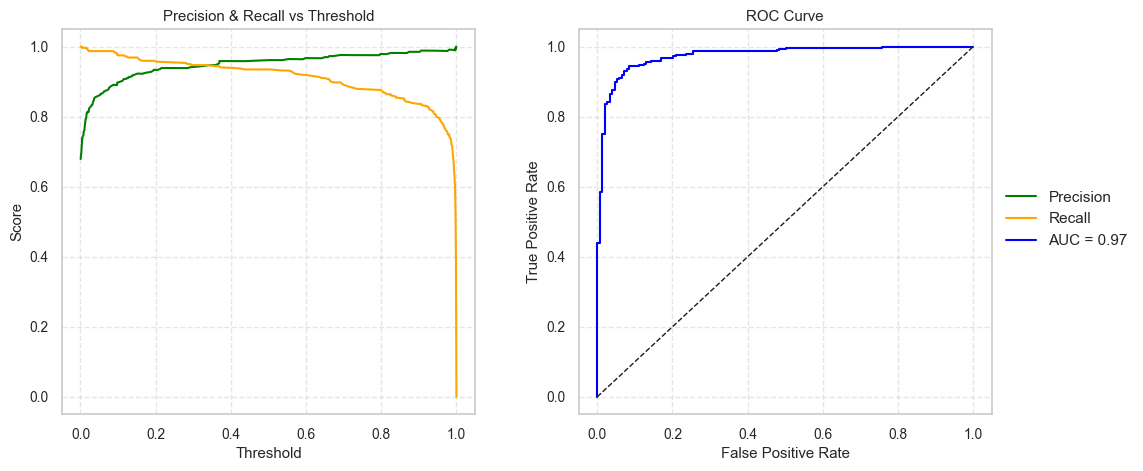

In [83]:
plot_two_evaluation_plots(y_true_xgb, y_prob_xgb)

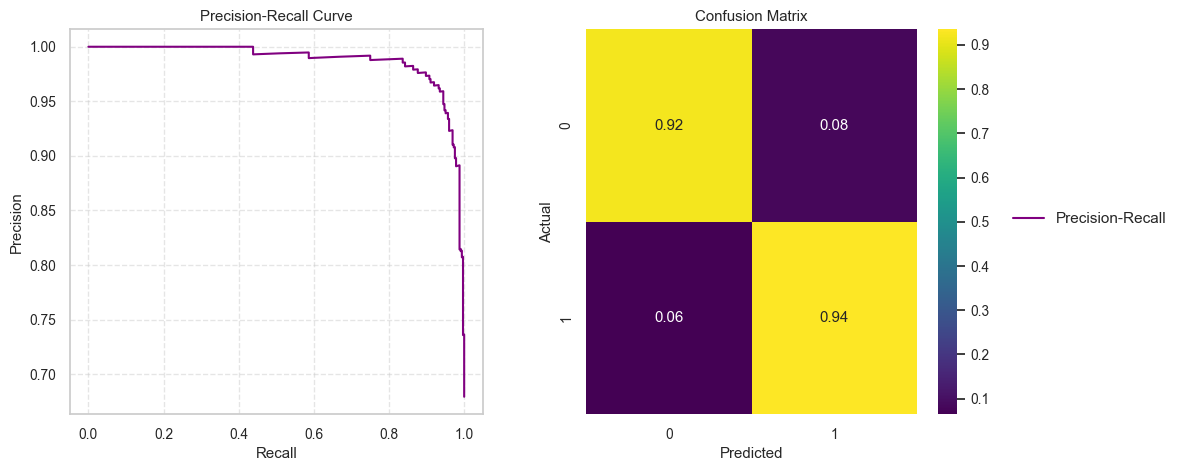

In [84]:
plot_pr_and_confusion_matrix(y_true_xgb, y_prob_xgb, y_pred_xgb)

### **Observations**

- 92% of the actual negative cases (class 0) were correctly predicted by the model as not having churned.
- 8% of the actual negative cases (class 0) were incorrectly predicted by the model as having churned.
- 6% of the actual positive cases (class 1) were incorrectly predicted by the model as not having churned.
- 94% of the actual positive cases (class 1) were correctly predicted by the model as having churned.

### **LGBM Classifier**

In [85]:
import optuna

categorical_cols = ['City']

numerical_cols = [
    'Total_Business_Value', 'Total_Had_Negative_Business', 'Has_Income_Increased',
    'Has_Rating_Increased', 'Avg_Business_Value', 'Age', 'Gender', 'Income',
    'Total_Income', 'Education_Level', 'Joining_Designation', 'Grade',
    'Quarterly_Rating', 'Tenure', 'Date_Of_Joining_month', 'Date_Of_Joining_year',
    'Is_Valuable_Driver'
]

feature_columns = categorical_cols + numerical_cols

X_train_lgbm = train_data[feature_columns]
y_train_lgbm = train_data['Churned']
X_test_lgbm = test_data[feature_columns]
y_test_lgbm = test_data['Churned']

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
    ('num', StandardScaler(), numerical_cols)
])

def objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    num_leaves = trial.suggest_int("num_leaves", 15, 300)
    max_depth = trial.suggest_int("max_depth", 3, 15)
    min_child_samples = trial.suggest_int("min_child_samples", 5, 100)
    min_child_weight = trial.suggest_float("min_child_weight", 1e-3, 10.0, log=True)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)
    reg_alpha = trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True)
    reg_lambda = trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True)
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LGBMClassifier(
            learning_rate=learning_rate,
            n_estimators=n_estimators,
            num_leaves=num_leaves,
            max_depth=max_depth,
            min_child_samples=min_child_samples,
            min_child_weight=min_child_weight,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            random_state=42,
            verbosity=-1,
            class_weight="balanced"
        ))
    ])

    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
        X_train_lgbm, y_train_lgbm, test_size=0.2, random_state=42)

    pipeline.fit(X_train_split, y_train_split)
    y_val_pred = pipeline.predict(X_val_split)
    f1 = f1_score(y_val_split, y_val_pred)

    return f1

study = optuna.create_study(direction="maximize")
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=50)

print("Best Trial:")
print(f"  F1 Score: {study.best_trial.value:.4f}")
print("  Params:")
for k, v in study.best_trial.params.items():
    print(f"    {k}: {v}")


best_params = study.best_trial.params

final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(
        learning_rate=best_params["learning_rate"],
        n_estimators=best_params["n_estimators"],
        subsample=best_params["subsample"],
        random_state=42,
        verbosity=-1,
        class_weight="balanced"
    ))
])

final_pipeline.fit(X_train_lgbm, y_train_lgbm)
joblib.dump(final_pipeline, "S:/Project_3/models/lgbm_model.pkl")

y_pred_lgbm = final_pipeline.predict(X_test_lgbm)
y_prob_lgbm = final_pipeline.predict_proba(X_test_lgbm)[:, 1]
print("Test F1 Score:", f1_score(y_test_lgbm, y_pred_lgbm))

[I 2025-08-02 10:00:19,086] A new study created in memory with name: no-name-9ddbb337-7199-4055-82bf-ad6eb20cc3af


Best Trial:
  F1 Score: 0.9300
  Params:
    learning_rate: 0.26945236131637285
    n_estimators: 343
    num_leaves: 55
    max_depth: 6
    min_child_samples: 7
    min_child_weight: 0.610773181233964
    subsample: 0.780059130140367
    colsample_bytree: 0.6559244349381841
    reg_alpha: 0.0010469740104326246
    reg_lambda: 0.26828844319992223
Test F1 Score: 0.9463722397476341


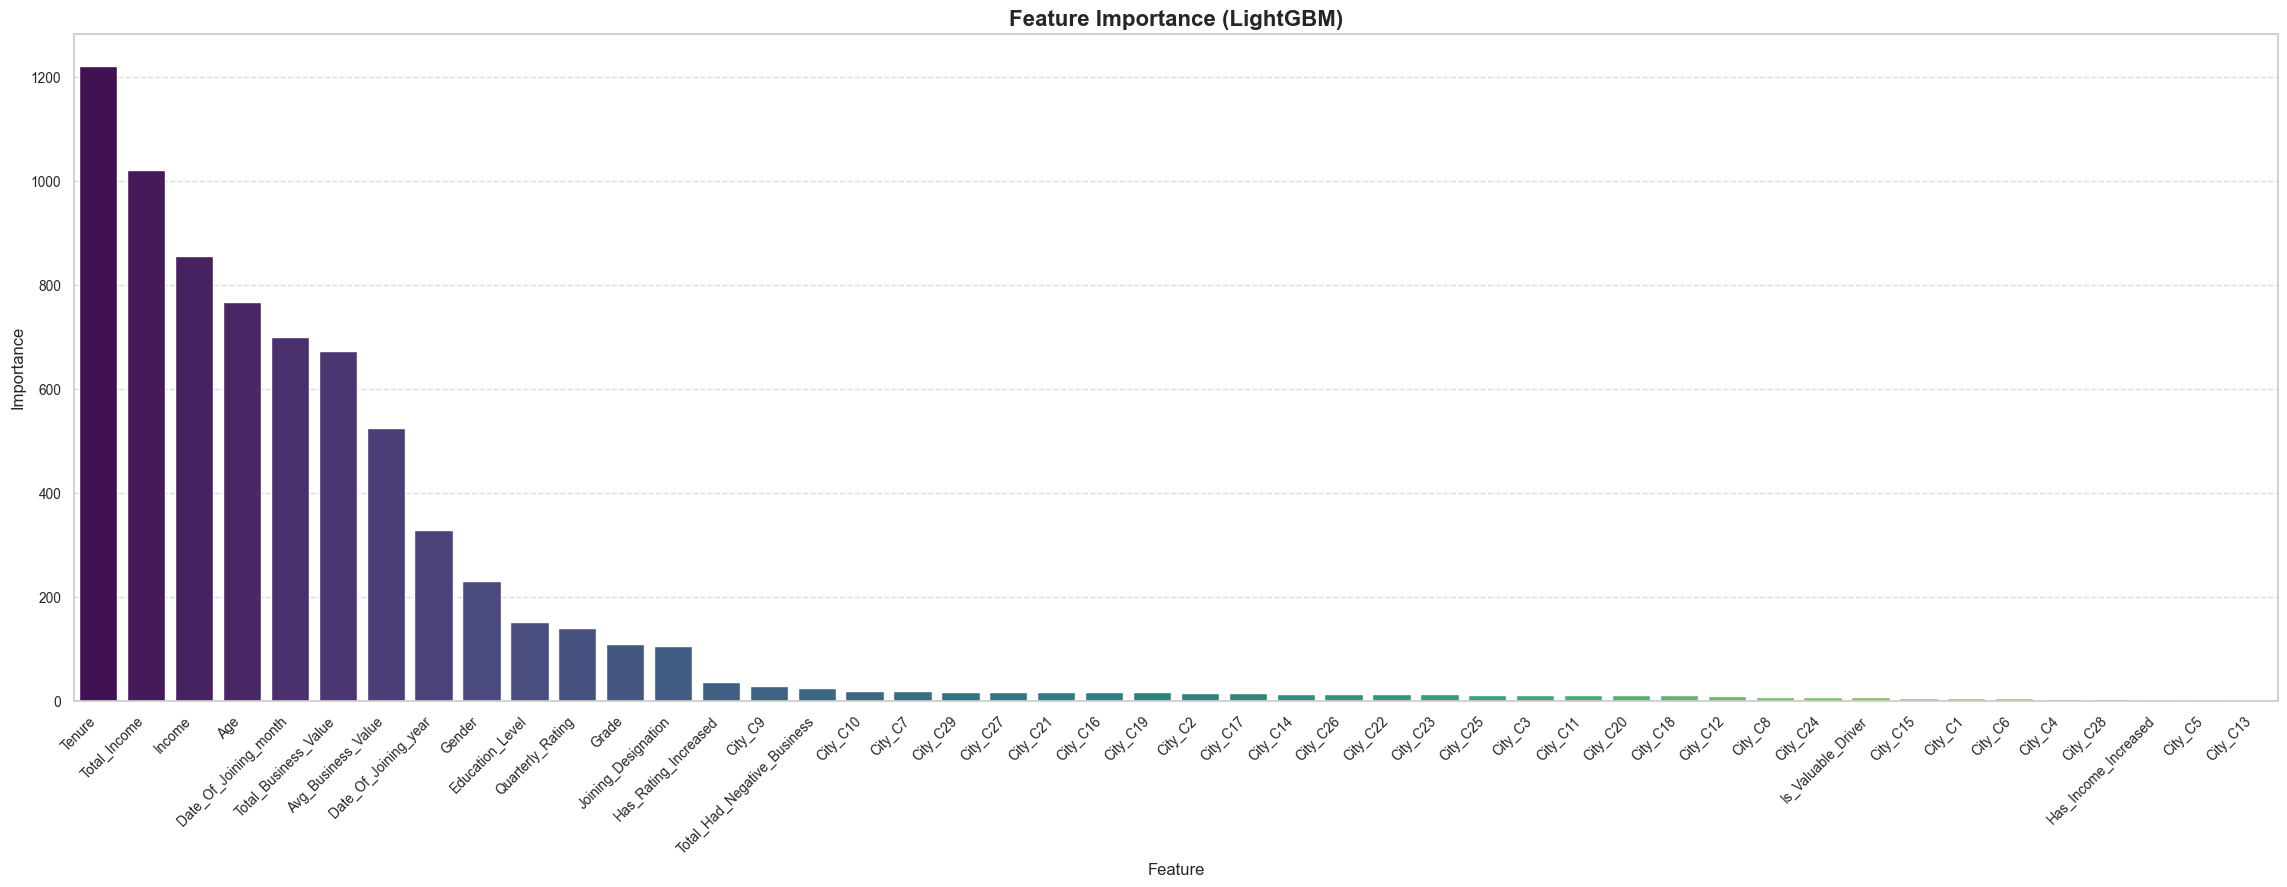

In [86]:
preprocessor = final_pipeline.named_steps['preprocessor']
lgbm_model = final_pipeline.named_steps['classifier']

cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
num_features = numerical_cols
all_features = np.concatenate([cat_features, num_features])

importances = lgbm_model.feature_importances_

feat_imp_df = pd.DataFrame({
    "Feature": all_features,
    "Importance": importances
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(max(12, len(all_features) * 0.5), 9))
sns.barplot(data=feat_imp_df, x="Feature", y="Importance", palette="viridis")

plt.title("Feature Importance (LightGBM)", fontsize=16, weight="bold")
plt.xlabel("Feature", fontsize=12)
plt.ylabel("Importance", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

### **Observations**
- We can see that Tenure is the most important feature followed by Total Income.

In [87]:
y_pred_lgbm = final_pipeline.predict(X_test_lgbm)
y_prob_lgbm = final_pipeline.predict_proba(X_test_lgbm)[:, 1]
y_true_lgbm = y_test_lgbm

In [88]:
print_metrics(y_true_lgbm, y_pred_lgbm, y_prob_lgbm)

              precision    recall  f1-score   support

           0       0.86      0.93      0.89       153
           1       0.97      0.93      0.95       324

    accuracy                           0.93       477
   macro avg       0.91      0.93      0.92       477
weighted avg       0.93      0.93      0.93       477

Accuracy:  0.9287211740041929
F1 Score:  0.9463722397476341
AUC:  0.9763777939159203


In [89]:
best_threshold = get_best_threshold(y_true_lgbm, y_prob_lgbm)
y_pred_thresh = (y_prob_lgbm >= best_threshold).astype(int)

Best threshold: 0.12
Precision at best threshold: 0.966
Recall at best threshold: 0.957
F1 score at best threshold: 0.961


In [90]:
print_metrics(y_true_lgbm, y_pred_thresh, y_prob_lgbm)

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       153
           1       0.97      0.96      0.96       324

    accuracy                           0.95       477
   macro avg       0.94      0.94      0.94       477
weighted avg       0.95      0.95      0.95       477

Accuracy:  0.9475890985324947
F1 Score:  0.9612403100775194
AUC:  0.9763777939159203


### **Observations**
- With these new adjustment the, the f1 score increased by 1.5%.

### **Insights**
- A Recall of 96% means that out of all churned drivers, the model was correct 96% of times
- A precision of 97% means that out of all churned drivers predicted, 97% were actually churned.

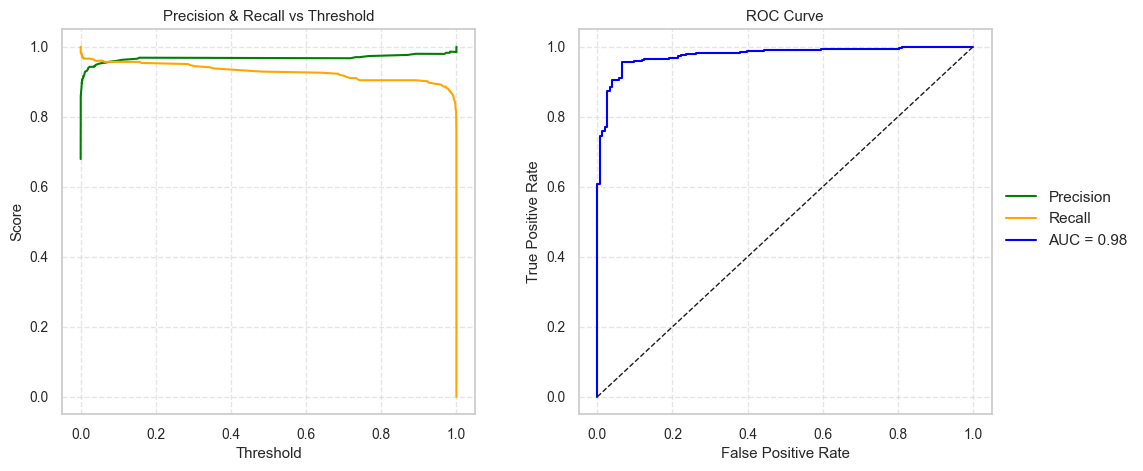

In [91]:
plot_two_evaluation_plots(y_true_lgbm, y_prob_lgbm)

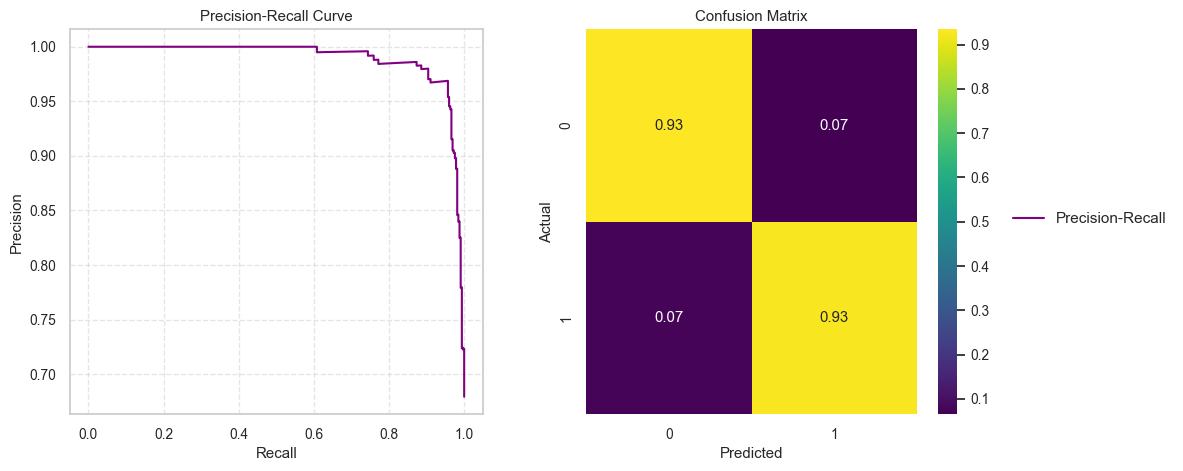

In [92]:
plot_pr_and_confusion_matrix(y_true_lgbm, y_prob_lgbm, y_pred_lgbm)

### **Observations**

- 93% of the actual negative cases (class 0) were correctly predicted by the model as not having churned.
- 7% of the actual negative cases (class 0) were incorrectly predicted by the model as having churned.
- 7% of the actual positive cases (class 1) were incorrectly predicted by the model as not having churned.
- 93% of the actual positive cases (class 1) were correctly predicted by the model as having churned.

### **Model Comparison**

In [93]:
import joblib

best_rf = joblib.load("S:/Project_3/models/rf_model.pkl")
best_gbt = joblib.load("S:/Project_3/models/gb_model.pkl")
best_xgb = joblib.load("S:/Project_3/models/xgb_model.pkl")
best_lgbm = joblib.load("S:/Project_3/models/lgbm_model.pkl")

In [94]:
y_prob_rf = best_rf.predict_proba(X_test_rf)[:, 1]
y_prob_gbt = best_gbt.predict_proba(X_test_gbt)[:, 1]
y_prob_xgb = best_xgb.predict_proba(X_test_xgb)[:, 1]
y_prob_lgbm = best_lgbm.predict_proba(X_test_lgbm)[:, 1]

In [95]:
best_threshold_rf = get_best_threshold(y_true_rf, y_prob_rf)
best_threshold_gbt = get_best_threshold(y_true_gbt, y_prob_gbt)
best_threshold_xgb = get_best_threshold(y_true_xgb, y_prob_xgb)
best_threshold_lgbm = get_best_threshold(y_true_lgbm, y_prob_lgbm)

y_pred_rf = (y_prob_rf >= best_threshold_rf).astype(int)
y_pred_gbt = (y_prob_gbt >= best_threshold_gbt).astype(int)
y_pred_xgb = (y_prob_xgb >= best_threshold_xgb).astype(int)
y_pred_lgbm = (y_prob_lgbm >= best_threshold_lgbm).astype(int)

Best threshold: 0.45
Precision at best threshold: 0.933
Recall at best threshold: 0.938
F1 score at best threshold: 0.935
Best threshold: 0.27
Precision at best threshold: 0.954
Recall at best threshold: 0.957
F1 score at best threshold: 0.955
Best threshold: 0.37
Precision at best threshold: 0.959
Recall at best threshold: 0.941
F1 score at best threshold: 0.950
Best threshold: 0.12
Precision at best threshold: 0.966
Recall at best threshold: 0.957
F1 score at best threshold: 0.961


In [96]:
print("Random Forest:\n", classification_report(y_true_rf, y_pred_rf))
print("GBT:\n", classification_report(y_true_gbt, y_pred_gbt))
print("XGBoost:\n", classification_report(y_true_xgb, y_pred_xgb))
print("LightGBM:\n", classification_report(y_true_lgbm, y_pred_lgbm))

Random Forest:
               precision    recall  f1-score   support

           0       0.87      0.86      0.86       153
           1       0.93      0.94      0.94       324

    accuracy                           0.91       477
   macro avg       0.90      0.90      0.90       477
weighted avg       0.91      0.91      0.91       477

GBT:
               precision    recall  f1-score   support

           0       0.91      0.90      0.90       153
           1       0.95      0.96      0.96       324

    accuracy                           0.94       477
   macro avg       0.93      0.93      0.93       477
weighted avg       0.94      0.94      0.94       477

XGBoost:
               precision    recall  f1-score   support

           0       0.88      0.92      0.90       153
           1       0.96      0.94      0.95       324

    accuracy                           0.93       477
   macro avg       0.92      0.93      0.92       477
weighted avg       0.93      0.93      0.9

In [97]:
columns = ["Model", "F1", "Accuracy", "Precision", "Recall", "AUC"]

results = [
    ("Random Forest", f1_score(y_true_rf, y_pred_rf), accuracy_score(y_true_rf, y_pred_rf), precision_score(y_true_rf, y_pred_rf), recall_score(y_true_rf, y_pred_rf), roc_auc_score(y_true_rf, y_prob_rf)),
    ("Gradient Boosting", f1_score(y_true_gbt, y_pred_gbt), accuracy_score(y_true_gbt, y_pred_gbt), precision_score(y_true_gbt, y_pred_gbt), recall_score(y_true_gbt, y_pred_gbt), roc_auc_score(y_true_gbt, y_prob_gbt)),
    ("XGBoost", f1_score(y_true_xgb, y_pred_xgb), accuracy_score(y_true_xgb, y_pred_xgb), precision_score(y_true_xgb, y_pred_xgb), recall_score(y_true_xgb, y_pred_xgb), roc_auc_score(y_true_xgb, y_prob_xgb)),
    ("LightGBM", f1_score(y_true_lgbm, y_pred_lgbm), accuracy_score(y_true_lgbm, y_pred_lgbm), precision_score(y_true_lgbm, y_pred_lgbm), recall_score(y_true_lgbm, y_pred_lgbm), roc_auc_score(y_true_lgbm, y_prob_lgbm))
]

results_df = pd.DataFrame(results, columns=columns).sort_values("F1", ascending=False)
results_df

Model        F1  Accuracy  Precision    Recall       AUC
3           LightGBM  0.961240  0.947589   0.965732  0.956790  0.976378
1  Gradient Boosting  0.955316  0.939203   0.953846  0.956790  0.976358
2            XGBoost  0.950156  0.932914   0.959119  0.941358  0.974905
0      Random Forest  0.935385  0.911950   0.932515  0.938272  0.964193

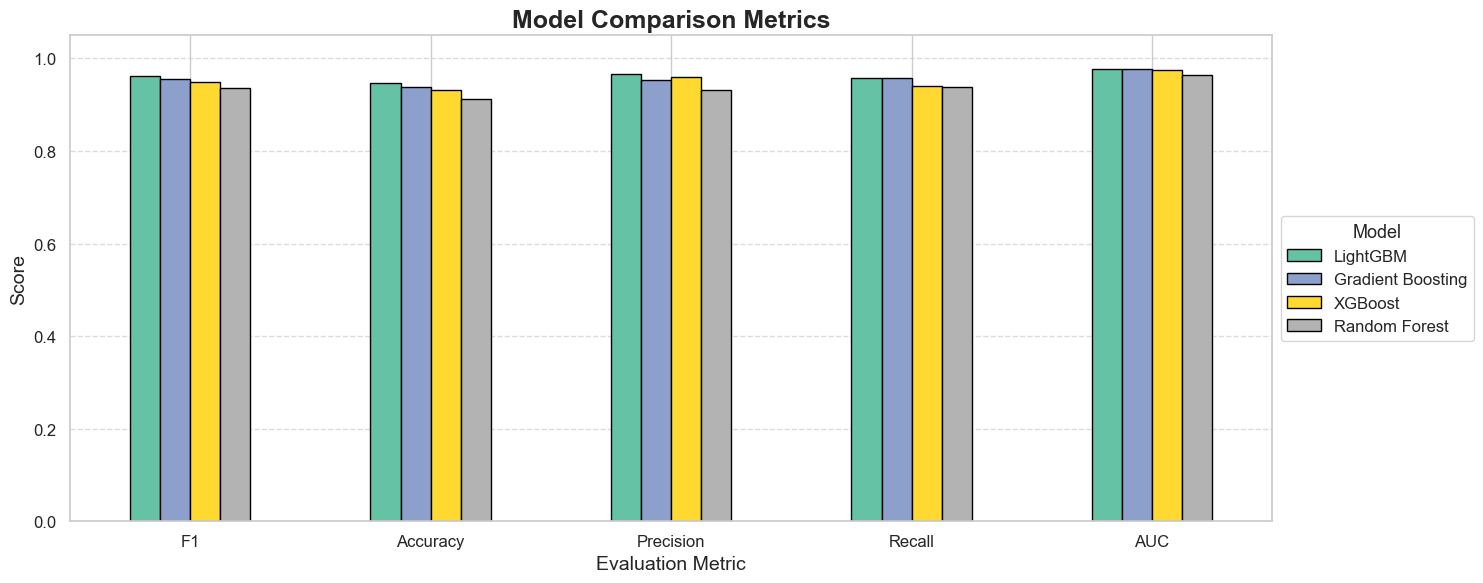

In [98]:
sns.set(style="whitegrid")

ax = results_df.set_index("Model").T.plot(
    kind="bar",
    figsize=(15, 6),
    colormap="Set2",
    edgecolor='black'
)

plt.title("Model Comparison Metrics", fontsize=18, fontweight="bold")
plt.ylabel("Score", fontsize=14)
plt.xlabel("Evaluation Metric", fontsize=14)
plt.ylim(0, 1.05)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(
    title="Model",
    bbox_to_anchor=(1, 0.5),
    loc='center left',
    fontsize=12,
    title_fontsize=13
)
plt.tight_layout()
plt.show()

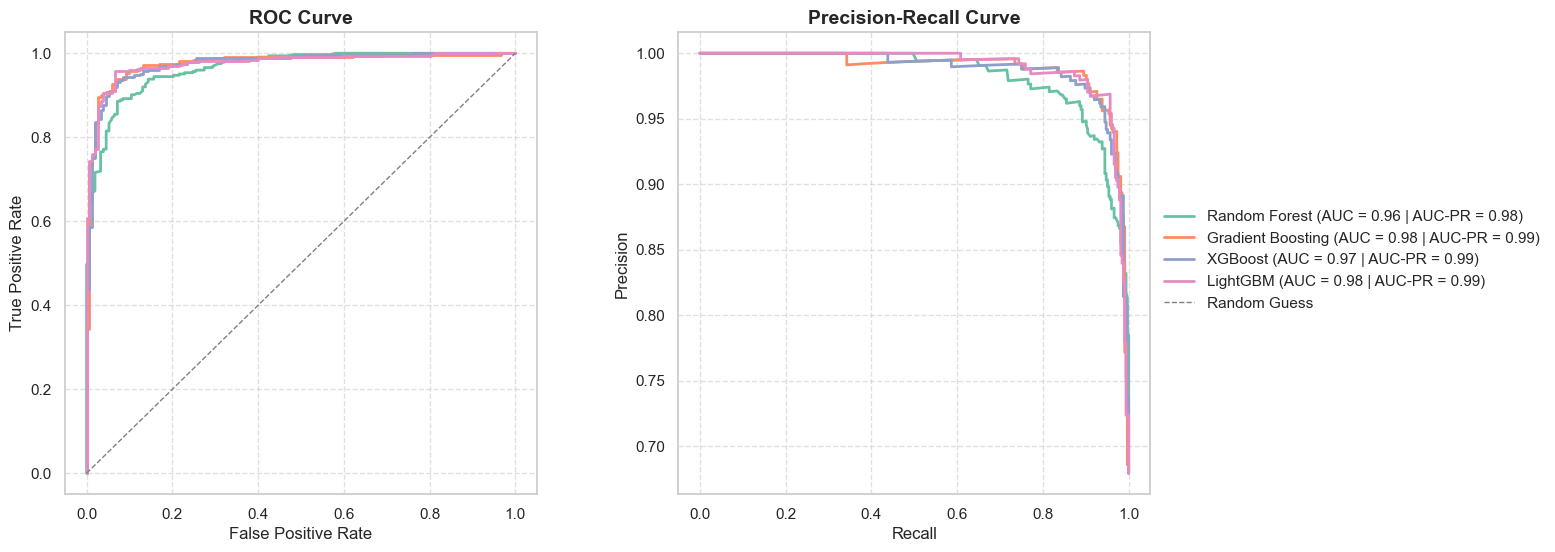


Best Model by AUC: LightGBM (0.9764)
Best Model by AUC-PR: LightGBM (0.9895)


In [99]:
def plot_roc_and_pr_curves(y_true_dict, y_prob_dict, palette=None):
    
    if palette is None:
        palette = sns.color_palette("Set2", len(y_true_dict))

    fig, axs = plt.subplots(1, 2, figsize=(14, 6), dpi=100, gridspec_kw={'wspace': 0.3})
    
    auc_scores = {}
    auc_pr_scores = {}
    combined_labels = []

    for i, model in enumerate(y_true_dict.keys()):
        y_true = y_true_dict[model]
        y_prob = y_prob_dict[model]

        fpr, tpr, _ = roc_curve(y_true, y_prob)
        auc_score = roc_auc_score(y_true, y_prob)
        auc_scores[model] = auc_score

        precision, recall, _ = precision_recall_curve(y_true, y_prob)
        auc_pr = average_precision_score(y_true, y_prob)
        auc_pr_scores[model] = auc_pr

        label = f"{model} (AUC = {auc_score:.2f} | AUC-PR = {auc_pr:.2f})"
        combined_labels.append(label)

        axs[0].plot(fpr, tpr, label=label, color=palette[i], linewidth=2)
        axs[1].plot(recall, precision, label=label, color=palette[i], linewidth=2)

    axs[0].plot([0, 1], [0, 1], linestyle="--", color="gray", linewidth=1, label="Random Guess")

    axs[0].set_title("ROC Curve", fontsize=14, fontweight="bold")
    axs[0].set_xlabel("False Positive Rate")
    axs[0].set_ylabel("True Positive Rate")
    axs[0].grid(True, linestyle="--", alpha=0.6)

    axs[1].set_title("Precision-Recall Curve", fontsize=14, fontweight="bold")
    axs[1].set_xlabel("Recall")
    axs[1].set_ylabel("Precision")
    axs[1].grid(True, linestyle="--", alpha=0.6)

    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="center left", bbox_to_anchor=(0.9, 0.5), frameon=False, fontsize=11)

    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.show()

    best_auc_model = max(auc_scores, key=auc_scores.get)
    best_aucpr_model = max(auc_pr_scores, key=auc_pr_scores.get)

    print(f"\nBest Model by AUC: {best_auc_model} ({auc_scores[best_auc_model]:.4f})")
    print(f"Best Model by AUC-PR: {best_aucpr_model} ({auc_pr_scores[best_aucpr_model]:.4f})")

y_true_dict = {"Random Forest": y_true_rf, "Gradient Boosting": y_true_gbt, "XGBoost": y_true_xgb, "LightGBM": y_true_lgbm}
y_prob_dict = {"Random Forest": y_prob_rf, "Gradient Boosting": y_prob_gbt, "XGBoost": y_prob_xgb, "LightGBM": y_prob_lgbm}

plot_roc_and_pr_curves(y_true_dict, y_prob_dict)

### **Final Pipeline**

In [103]:
from joblib import dump

best_params_full = {
    'learning_rate': 0.26945236131637285,
    'n_estimators': 343,
    'num_leaves': 55,
    'max_depth': 6,
    'min_child_samples': 7,
    'min_child_weight': 0.610773181233964,
    'subsample': 0.780059130140367,
    'colsample_bytree': 0.6559244349381841,
    'reg_alpha': 0.0010469740104326246,
    'reg_lambda': 0.26828844319992223,
    'random_state': 42,
    'verbosity': -1,
    'class_weight': 'balanced'
}

categorical_cols = ['City']
numerical_cols = [
    'Total_Business_Value', 'Total_Had_Negative_Business', 'Has_Income_Increased',
    'Has_Rating_Increased', 'Avg_Business_Value', 'Age', 'Gender', 'Income',
    'Total_Income', 'Education_Level', 'Joining_Designation', 'Grade',
    'Quarterly_Rating', 'Tenure', 'Date_Of_Joining_month', 'Date_Of_Joining_year',
    'Is_Valuable_Driver'
]

feature_columns = categorical_cols + numerical_cols

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
    ('num', StandardScaler(), numerical_cols)
])

X_train_final = train_data[feature_columns]
y_train_final = train_data['Churned']
X_test_final = test_data[feature_columns]
y_test_final = test_data['Churned']

final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(**best_params_full))
])

final_pipeline.fit(X_train_final, y_train_final)
dump(final_pipeline, 'final_pipeline_model_lgbm.joblib')
print("âœ… Final pipeline model saved as 'final_pipeline_model_lgbm.joblib'")

âœ… Final pipeline model saved as 'final_pipeline_model_lgbm.joblib'


In [104]:
y_test_probs = final_pipeline.predict_proba(X_test_final)[:, 1]
y_test_preds = (y_test_probs >= 0.80).astype(int) 

print(classification_report(y_test_final, y_test_preds))
print("F1 Score:", f1_score(y_test_final, y_test_preds))
print("AUC:", roc_auc_score(y_test_final, y_test_probs))

              precision    recall  f1-score   support

           0       0.80      0.94      0.87       153
           1       0.97      0.89      0.93       324

    accuracy                           0.91       477
   macro avg       0.89      0.92      0.90       477
weighted avg       0.92      0.91      0.91       477

F1 Score: 0.9292604501607717
AUC: 0.972484467037844


In [105]:
test_row = merged_df[merged_df['Driver_ID'] == 11]

X_test_row = test_row[feature_columns]

probability = final_pipeline.predict_proba(X_test_row)[0][1] 
prediction = int(probability >= 0.87)  

print("Probability of churn:", probability)
print("Predicted class:", prediction)
print("Actual class:", test_row['Churned'].values[0])

Probability of churn: 0.002809706743263367
Predicted class: 0
Actual class: 0


## **Driver Churn Prediction â€“ Final Project Summary**

### 1. **Driver Demographics & General Trends**

* Most drivers are **aged between 28â€“38**, with a **right-skewed** age distribution.
* **1404 male** and **977 female** drivers; **668 churned females**, **948 churned males**.
* **Education level** and **gender** have **little impact** on churn.
* Most drivers joined at **Designation 1**, which also sees **high churn**.

### 2. **Income & Business Value**

* Income follows a **positively skewed** distribution.
* Majority earn **â‚¹40kâ€“â‚¹70k**; few earn above â‚¹1.5L.
* **Only 43 drivers** had an income increase â†’ **Income growth is strongly linked to retention**.
* Drivers with higher **total and average business value** are less likely to churn.

### 3. **Tenure & Performance Ratings**

* Tenure is **right-skewed**; short-tenure drivers churn more.
* Drivers with **Quarterly Rating 1 or 2** have **significantly higher churn**.
* **No drivers** received a rating of 5.
* Higher **grades (4 and 5)** contribute **more business** and **churn less**.
* **Quarterly Rating** is **positively correlated** with performance and retention.

### 4. **City-Level Insights**

* **City C13** has the **highest churn rate** (>80%); **C20** has the **highest absolute churn**.
* **C29** has the **lowest churn rate** and **highest revenue**.
* **C13** shows the **best revenue-to-expense ratio**.
* **Performance trends** vary across cities:

  * **C17** shows a **sharp performance decline**, while
  * **C29** shows **strong rating improvements**.

### 5. **Joining Date Impact**

* Drivers who joined in **2018â€“2019** saw the **highest churn**.
* **Joining month** also influences churn; May, Jan, and Feb show higher churn rates.

### 6. **Negative Business Impact**

* More **negative business months** â†’ higher churn probability.
* **2 negative months** â†’ \~90% churn rate.
* **3 negative months** â†’ lower churn (possible anomaly or small sample).

### 7. **Correlations**

* `Churned` is **negatively correlated** with:

  * `Tenure` (-0.43)
  * `Quarterly_Rating` (-0.51)
  * `Total_Business_Value` (-0.38)
* `Quarterly_Rating`, `Grade`, and `Income` are **positively correlated** with `Total_Income` and `Business Value`.

---

Here is your updated markdown based on the new metrics you provided:

---

## **Modeling Observations**

### Model Comparison:

| Model                 | F1 Score | Accuracy | Precision | Recall | **AUC**    |
| --------------------- | -------- | -------- | --------- | ------ | ---------- |
| **LightGBM**          | 0.9612   | 0.9476   | 0.9657    | 0.9568 | **0.9764** |
| **Gradient Boosting** | 0.9553   | 0.9392   | 0.9538    | 0.9568 | **0.9764** |
| **XGBoost**           | 0.9502   | 0.9329   | 0.9591    | 0.9414 | **0.9749** |
| **Random Forest**     | 0.9354   | 0.9120   | 0.9325    | 0.9383 | **0.9642** |

### Final Model: **LightGBM**

* **Best performing** model in terms of **F1 Score**, **AUC**, and **AUC-PR (0.9895)**.
* **Precision:** 96.6%
* **Recall:** 95.7%
* **F1 Score:** **0.961**
* **AUC:** **0.9764**
* **Best threshold:** 0.12

---

## **Key Takeaways**

* **Performance rating**, **tenure**, **total income**, and **joining year** are the **strongest predictors** of churn.
* Drivers with **no income or rating increase** are **far more likely to leave**.
* **City-level** analysis helps target **problem areas** like C13, C17, and C2 for intervention.
* **High business value drivers** and those in **higher grades** should be **prioritized for retention**.
* The **LightGBM model** offers the most reliable predictions for churn and can be used in production with high confidence.